# **<span style="color:#8B0000">Анализ спроса на самокаты в сервисе шеринга</span>**

## О проекте

Этот проект посвящен изучению спроса на самокаты с целью оптимизации бизнес-процессов и повышения эффективности работы сервиса.  
В ходе исследования будет обработана информация о поездках, погодных условиях и проверена гипотеза о влиянии различных факторов на уровень спроса.

## Цель проекта

Главная цель проекта — выявить, какие факторы влияют на спрос в сервисе.

## План исследования

### Анализ данных
- Изучение качества данных.  
- Выявление аномалий и пропусков.  
- Предварительная обработка информации.

### Расчеты и исследования
- Определение итоговой стоимости поездок и оценка эффективности акций.  
- Анализ почасового трафика и популярности точек аренды.  
- Исследование влияния погодных условий на спрос.

### Проверка гипотез
- Оценка влияния дождя, дня недели и других факторов на спрос и продолжительность поездок.

### Регрессионное моделирование
- Прогнозирование спроса на основе временных и погодных факторов.

### Визуализация
- Создание дашборда для мониторинга ключевых показателей.  
- Презентация основных выводов.

## Ожидаемые результаты

В результате выполнения проекта будут получены следующие результаты:

- Рекомендации по оптимизации работы сервиса.  
- Инсайты о влиянии погоды, времени суток и других факторов на уровень спроса.  
- Дашборд для мониторинга ключевых показателей.

## **<span style="color:#00008B">Подключение библиотек</span>**

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from matplotlib.ticker import MultipleLocator, MaxNLocator
from matplotlib.gridspec import GridSpec
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.stats import ttest_ind, shapiro, mannwhitneyu, kruskal, chi2_contingency, chisquare, f_oneway, pearsonr, spearmanr
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

**Обратите внимание! Для коректной работы билиотеки "ydata-profiling" нужен python ниже версии 3.13.0.**

In [2]:
!pip install -U ydata-profiling

In [3]:
from ydata_profiling import ProfileReport

C:\Users\mailm\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **<span style="color:#8B0000">Спринт 1 - предобработка</span>**

## **<span style="color:#00008B">Путь до папки </span>**

In [4]:
current_dir = os.getcwd()
print(current_dir)
PATH_OUT = current_dir

df  = pd.read_csv(PATH_OUT+"//csv/rides.csv", 
                 sep=',', encoding='utf-8', decimal=',')
df2 = pd.read_csv(PATH_OUT+"//csv/weather.csv", 
                 sep=',', encoding='utf-8', decimal=',')

C:\Users\mailm\Yandex_AD_scooters\Jupyter notebooks


## **<span style="color:#00008B">Полезные функции для работы  </span>**

In [5]:
def clean_data_with_threshold(df, variable, threshold, flag):
    """
    Очищает DataFrame, удаляя значения в указанной переменной, которые находятся за пределами заданного порога.
    Создает boxplot до и после очистки.

    Args:
        df (pd.DataFrame): Входной DataFrame.
        variable (str): Название столбца для очистки.
        threshold (float): Пороговое значение.
        flag (str):  Если 'below', удаляет значения меньше порога.
                     Если 'above', удаляет значения больше порога.
                     Если 'both', удаляет значения как меньше, так и больше порога (нужен кортеж из двух значений).

    Returns:
        pd.DataFrame: Очищенный DataFrame.
    """

    # Boxplot до очистки
    plot_numeric_boxplots(df)

    # Очистка данных
    if flag == 'below':
        cleaned_df = df[df[variable] >= threshold].copy()
    elif flag == 'above':
        cleaned_df = df[df[variable] <= threshold].copy()
    elif flag == 'both':
        cleaned_df = df[(df[variable] >= threshold[0]) & (df[variable] <= threshold[1])].copy()
    else:
        raise ValueError("Недопустимое значение флага. Должно быть 'below', 'above' или 'both'.")


    # Boxplot после очистки
    plot_numeric_boxplots(cleaned_df)
    
    return cleaned_df

## **<span style="color:#00008B">Графики для просмотра данных </span>**

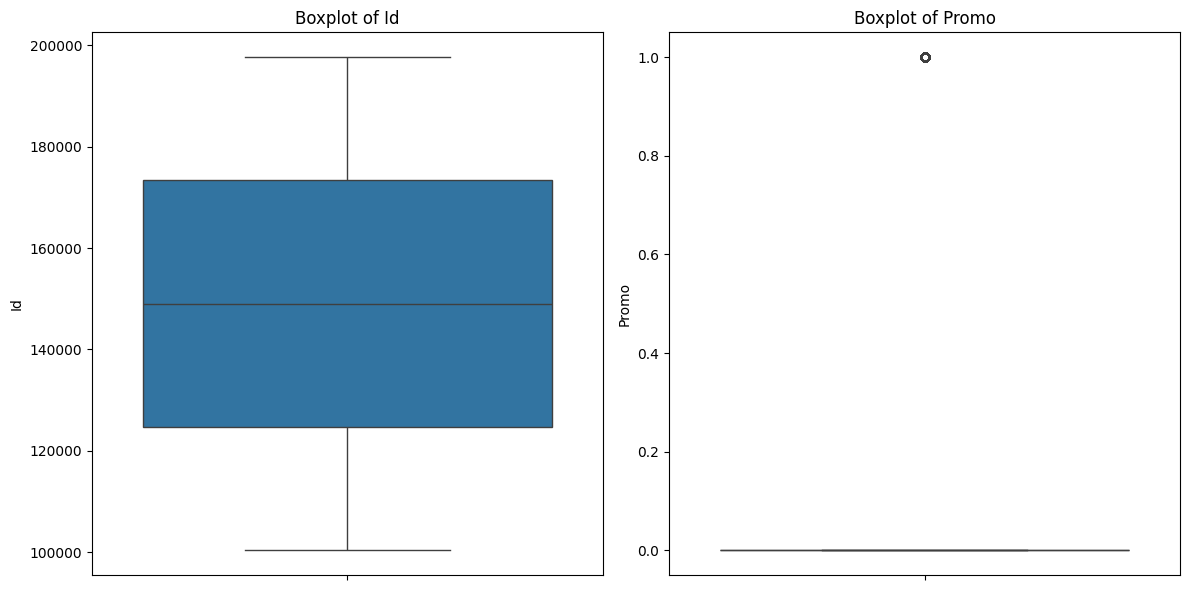

In [6]:
def plot_numeric_boxplots(df, figsize=(12, 6), plot_per_row=2):
    """
    Строит boxplot'ы для всех числовых столбцов в DataFrame.
    
    Параметры:
    -----------
    df : pandas.DataFrame
        Входной DataFrame с данными
    figsize : tuple, optional
        Размер графика (ширина, высота) в дюймах, по умолчанию (12, 6)
    plot_per_row : int, optional
        Количество boxplot'ов в одной строке, по умолчанию 2
    
    Возвращает:
    --------
    None
        Отображает графики, но не возвращает значений
    """
    # Выбираем все числовые столбцы (включая int, float и другие числовые типы)
    numeric_columns = df.select_dtypes(include=['number']).columns
    n_columns = len(numeric_columns)
    
    if n_columns == 0:
        print("No numeric columns found in the DataFrame")
        return
    
    # Вычислить необходимое количество строк
    n_rows = (n_columns + plot_per_row - 1) // plot_per_row
    
    # Создание подзаголовков
    fig, axes = plt.subplots(n_rows, plot_per_row, figsize=(figsize[0], figsize[1] * n_rows))
    
    # Сгладить массив осей для упрощения итерации
    axes = np.array(axes).flatten()
    
    # Создание коробочных графиков
    for idx, column in enumerate(numeric_columns):
        sns.boxplot(data=df, y=column, ax=axes[idx])
        axes[idx].set_title(f'Boxplot of {column}')
        axes[idx].set_ylabel(column)
    
    # Удалить пустые подзаголовки, если таковые имеются
    for idx in range(len(numeric_columns), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

# df = pd.DataFrame(your_data)
plot_numeric_boxplots(df)
# plot_numeric_boxplots(df2) - No numeric columns found in the DataFrame

## **<span style="color:#00008B">Просмотр имеюшихся данных  </span>**

#### <span style="color:#006400">Данные в rides.csv</span>

In [7]:
df.head(5)

Id           Start Date             End Date Start Location  \
0  100340  2023-04-22 09:01:03  2023-04-22 09:24:45       Шевченко   
1  100341  2023-04-22 09:01:07  2023-04-22 09:29:32         Чехова   
2  100342  2023-04-22 09:04:27  2023-04-22 09:42:46      Буденного   
3  100343  2023-04-22 09:06:34  2023-04-22 09:38:23          Труда   
4  100344  2023-04-22 09:09:27  2023-04-22 09:40:07   Первомайская   

    Start District End Location     End District Distance  Promo  
0    Юго-Восточный      Майская      Октябрьский   4069.0      0  
1         заречный   Спортивная      октябрьский   4515.0      0  
2      Октябрьский     Суворова        ленинский   4520.0      0  
3      Центральный      Рабочая  Северо-Западный   3881.0      0  
4  Северо-Западный    Юбилейная    Юго-Восточный   4029.0      0

In [8]:
#Анализирует DataFrame: проверяет пропуски, дубликаты, выводит статистику и примеры данных для числовых и категориальных столбцов
def check_data(data_df):
    print ('\033[5m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    #print(data_df.shape)

    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())

    ## Посмотрим на сами данные
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head(2)) #tail()

    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)

    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    display(data_df.describe(include='object').T)

    print('\033[1m' + '\nВывод уникальных значений по каждому категориаьному признаку:'+ '\033[0m')
    df_object = data_df.select_dtypes(include='object').columns

    for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(data_df[i].value_counts())


check_data(df)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102255 entries, 0 to 102254
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Id              102255 non-null  int64 
 1   Start Date      102255 non-null  object
 2   End Date        102255 non-null  object
 3   Start Location  102255 non-null  object
 4   Start District  102255 non-null  object
 5   End Location    102255 non-null  object
 6   End District    102255 non-null  object
 7   Distance        101022 non-null  object
 8   Promo           102255 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 7.0+ MB
None

Проверка пропусков
Количество пропусков: 1233
Доля пропусков: 0.2%
Доля строк содержащих пропуски: 1.2%

Проверка на дубликаты
Количество полных дубликатов:  4883

Первые пять строк датасета


Id           Start Date             End Date Start Location  \
0  100340  2023-04-22 09:01:03  2023-04-22 09:24:45       Шевченко   
1  100341  2023-04-22 09:01:07  2023-04-22 09:29:32         Чехова   

  Start District End Location End District Distance  Promo  
0  Юго-Восточный      Майская  Октябрьский   4069.0      0  
1       заречный   Спортивная  октябрьский   4515.0      0


Описание количественных данных:


count           mean           std       min       25%       50%  \
Id     102255.0  149024.057679  28110.574992  100340.0  124682.5  149028.0   
Promo  102255.0       0.019755      0.139156       0.0       0.0       0.0   

            75%       max  
Id     173372.5  197711.0  
Promo       0.0       1.0


Описание категориальных данных:


count unique                  top   freq
Start Date      102255  96526  2023-07-02 11:35:14      4
End Date        102255  95949                  NaT    579
Start Location  102255    463           Ломоносова   1675
Start District  102255     13          Центральный  18115
End Location    102255    495           Спортивная   1511
End District    102255     14          Центральный  18878
Distance        101022   6535                  4.0   1162


Вывод уникальных значений по каждому категориаьному признаку:
_Start Date


Start Date
2023-07-02 11:35:14    4
2023-07-15 18:09:14    4
2023-06-03 15:07:27    3
2023-06-02 20:02:05    3
2023-06-03 15:40:44    3
                      ..
2023-07-31 22:55:48    1
2023-07-31 22:57:28    1
2023-07-31 23:10:07    1
2023-07-31 23:12:40    1
2023-04-22 09:19:13    1
Name: count, Length: 96526, dtype: int64

_End Date


End Date
NaT                    579
2023-05-20 19:58:25      4
2023-05-17 19:30:32      4
2023-06-18 18:42:24      4
2023-07-03 20:07:12      4
                      ... 
2023-07-31 23:16:03      1
2023-07-31 23:13:04      1
2023-07-31 23:23:49      1
2023-07-31 23:33:50      1
2023-04-22 09:49:56      1
Name: count, Length: 95949, dtype: int64

_Start Location


Start Location
Ломоносова           1675
Луговая              1655
Майская              1648
Восточная            1584
Спортивная           1583
                     ... 
Ул. Московская          1
Ул. Северная            1
Ул. Энтузиастов         1
Ул. Матросова           1
Ул. Комсомольская       1
Name: count, Length: 463, dtype: int64

_Start District


Start District
Центральный        18115
Юго-Восточный      13542
Ленинский          11308
Северо-Западный    11304
Октябрьский         9729
центральный         8259
Заречный            6803
юго-восточный       5869
ленинский           5011
северо-западный     4973
октябрьский         4330
заречный            3011
северо западный        1
Name: count, dtype: int64

_End Location


End Location
Спортивная      1511
Восточная       1450
Ломоносова      1441
Буденного       1406
Луговая         1405
                ... 
ул почтовая        1
Ул. Заречная       1
Ул. Мичурина       1
Ул. Шевченко       1
ул матросова       1
Name: count, Length: 495, dtype: int64

_End District


End District
Центральный        18878
Юго-Восточный      14612
Ленинский          12090
Северо-Западный    12055
Октябрьский        10519
Заречный            7023
центральный         6808
юго-восточный       5203
северо-западный     4411
ленинский           4308
октябрьский         3794
заречный            2499
Северо Западный       33
северо западный       22
Name: count, dtype: int64

_Distance


Distance
4.0       1162
3.0        980
5.0        524
2.0        239
6.0        153
          ... 
6636.0       1
1645.0       1
6917.0       1
8338.0       1
8604.0       1
Name: count, Length: 6535, dtype: int64

#### <span style="color:#006400">Данные в weather.csv</span>

In [9]:
df2.head(5)

Datetime Temperature Precipitation Total Wind Gust Wind Speed  \
0                  NaN          °C                  mm      km/h       km/h   
1  2023-04-01T00:00:00    8.740245                 0.1      48.6  21.638964   
2  2023-04-01T01:00:00    9.040245                 0.2     55.44  22.493519   
3  2023-04-01T02:00:00    8.880245                 0.3      55.8   22.26477   
4  2023-04-01T03:00:00    8.690246                 0.3     55.44   21.94524   

  Cloud Cover Total Sunshine Duration  
0                 %               min  
1                90                 0  
2                74                 0  
3                72                 0  
4                77                 0

In [10]:
check_data(df2)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3673 entries, 0 to 3672
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Datetime             3672 non-null   object
 1   Temperature          3618 non-null   object
 2   Precipitation Total  3643 non-null   object
 3   Wind Gust            3673 non-null   object
 4   Wind Speed           3657 non-null   object
 5   Cloud Cover Total    3653 non-null   object
 6   Sunshine Duration    3661 non-null   object
dtypes: object(7)
memory usage: 201.0+ KB
None

Проверка пропусков
Количество пропусков: 134
Доля пропусков: 0.6%
Доля строк содержащих пропуски: 3.6%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


Datetime Temperature Precipitation Total Wind Gust Wind Speed  \
0                  NaN          °C                  mm      km/h       km/h   
1  2023-04-01T00:00:00    8.740245                 0.1      48.6  21.638964   

  Cloud Cover Total Sunshine Duration  
0                 %               min  
1                90                 0


Описание количественных данных:


count unique                  top  freq
Datetime             3672   3672  2023-08-31T23:00:00     1
Temperature          3618   1964            27.540245     9
Precipitation Total  3643     36                    0  2966
Wind Gust            3673    163           11.5199995    86
Wind Speed           3657    709            4.3349743    36
Cloud Cover Total    3653    197                    0   251
Sunshine Duration    3661    495                    0  1309


Описание категориальных данных:


count unique                  top  freq
Datetime             3672   3672  2023-08-31T23:00:00     1
Temperature          3618   1964            27.540245     9
Precipitation Total  3643     36                    0  2966
Wind Gust            3673    163           11.5199995    86
Wind Speed           3657    709            4.3349743    36
Cloud Cover Total    3653    197                    0   251
Sunshine Duration    3661    495                    0  1309


Вывод уникальных значений по каждому категориаьному признаку:
_Datetime


Datetime
2023-08-31T23:00:00    1
2023-04-01T00:00:00    1
2023-04-01T01:00:00    1
2023-04-01T02:00:00    1
2023-04-01T03:00:00    1
                      ..
2023-04-01T12:00:00    1
2023-04-01T11:00:00    1
2023-04-01T10:00:00    1
2023-04-01T09:00:00    1
2023-04-01T08:00:00    1
Name: count, Length: 3672, dtype: int64

_Temperature


Temperature
27.540245     9
25.610245     8
15.040245     8
11.250245     7
20.140245     6
             ..
15.410245     1
14.290245     1
14.850245     1
13.3102455    1
12.710245     1
Name: count, Length: 1964, dtype: int64

_Precipitation Total


Precipitation Total
0      2966
0.1     146
0.2     144
0.3      89
0.4      54
0.6      38
0.5      33
0.8      23
0.7      21
1.2      15
1.3      15
0.9      13
1.1      12
1.4      10
1         8
1.6       7
1.5       7
1.8       6
1.7       6
2.2       6
2.1       4
2.4       2
2.3       2
2         2
1.9       2
2.6       2
mm        1
2.9       1
3         1
5         1
5.8       1
3.3       1
3.9       1
3.4       1
2.8       1
2.7       1
Name: count, dtype: int64

_Wind Gust


Wind Gust
11.5199995    86
13.32         81
11.879999     73
13.679999     73
15.4800005    72
              ..
67.67999       1
65.520004      1
66.96          1
65.159996      1
58.679996      1
Name: count, Length: 163, dtype: int64

_Wind Speed


Wind Speed
4.3349743    36
5.3517847    34
6.28713      33
3.319036     33
4.0249224    32
             ..
23.132626     1
25.600533     1
22.42427      1
21.94524      1
22.26477      1
Name: count, Length: 709, dtype: int64

_Cloud Cover Total


Cloud Cover Total
0            251
100           97
1             56
98            48
20            45
            ... 
19.2           1
14.1           1
18.300001      1
14.400001      1
13.500001      1
Name: count, Length: 197, dtype: int64

_Sunshine Duration


Sunshine Duration
0            1309
60            143
41.81818       37
59.393936      31
4.8484864      28
             ... 
2.2343435       1
26.962963       1
19.630304       1
53.81818        1
32.435688       1
Name: count, Length: 495, dtype: int64

## **<span style="color:#00008B">Начало предобработки  </span>**

### <span style="color:#006400">Данные в rides.csv</span>

#### преобразуем все столбцы в стандард pep-8

In [11]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head(5)

id           start_date             end_date start_location  \
0  100340  2023-04-22 09:01:03  2023-04-22 09:24:45       Шевченко   
1  100341  2023-04-22 09:01:07  2023-04-22 09:29:32         Чехова   
2  100342  2023-04-22 09:04:27  2023-04-22 09:42:46      Буденного   
3  100343  2023-04-22 09:06:34  2023-04-22 09:38:23          Труда   
4  100344  2023-04-22 09:09:27  2023-04-22 09:40:07   Первомайская   

    start_district end_location     end_district distance  promo  
0    Юго-Восточный      Майская      Октябрьский   4069.0      0  
1         заречный   Спортивная      октябрьский   4515.0      0  
2      Октябрьский     Суворова        ленинский   4520.0      0  
3      Центральный      Рабочая  Северо-Западный   3881.0      0  
4  Северо-Западный    Юбилейная    Юго-Восточный   4029.0      0

#### Вычислим длительность сессии между 'Start Date' и 'End Date' в формате HH:MM:SS и дополнительно в минутах

In [12]:
def calculate_session_time(df):
    df = df.copy()
    df['start_date'] = pd.to_datetime(df['start_date'])
    df['end_date'] = pd.to_datetime(df['end_date'])
    df['session_time'] = df['end_date'] - df['start_date']
    df['session_time'] = df['session_time'].apply(
        lambda x: str(x).split()[-1] if 'days' in str(x) else str(x)
    )
    df['session_time_(minutes)'] = pd.to_timedelta(df['session_time']).dt.total_seconds() / 60
    return df

df = calculate_session_time(df)
df.to_csv("datafrem_data.csv")

#### наведем порядок в типах данных

##### Было: 

In [13]:
df.dtypes

id                                 int64
start_date                datetime64[ns]
end_date                  datetime64[ns]
start_location                    object
start_district                    object
end_location                      object
end_district                      object
distance                          object
promo                              int64
session_time                      object
session_time_(minutes)           float64
dtype: object

##### Стало:

In [14]:
# Преобразование столбцов с локациями в строковый тип (text/string)
location_columns = ['start_location', 'start_district', 'end_location', 'end_district']
df[location_columns] = df[location_columns].astype('string')

# Преобразуем в строку формата HH:MM:SS
df['session_time'] = pd.to_timedelta(df['session_time']).astype(str).str[-8:]
print(df.dtypes)

id                                 int64
start_date                datetime64[ns]
end_date                  datetime64[ns]
start_location            string[python]
start_district            string[python]
end_location              string[python]
end_district              string[python]
distance                          object
promo                              int64
session_time                      object
session_time_(minutes)           float64
dtype: object


тип данных в session_time можно сделать timedelta, но тогда будут указывать данные в формате дней:часов:минут:секунд а для красоты пока что оставлю 
тип object. (позже улдалить эту колонку(т.к есть Session Time (minutes)))

#### Преведем числовой столбец к целым числам, отбрасывая дробную часть и NaN

In [15]:
def convert_id_column(df, column='distance'):
    df = df.copy()
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame")
    
    df = df.dropna(subset=[column])
    df[column] = df[column].astype(str)
    df[column] = df[column].str.replace('.0$', '', regex=True) 
    df[column] = df[column].str.replace('nan', '', regex=True)
    df[column] = pd.to_numeric(df[column], downcast='integer')
    return df

df = convert_id_column(df)

#### Очистим и стандартизируем форматы адресов ()

In [16]:
df['start_location'] = list(map(lambda x: x.lower().replace('ул. ', '').replace('ул.', '').replace('ул ', ''), df['start_location']))
df['end_location'] = list(map(lambda x: x.lower().replace('ул. ', '').replace('ул.', '').replace('ул ', ''), df['end_location']))
df['start_district'] = list(map(lambda x: x.lower(), df['start_district']))
df['end_district'] = list(map(lambda x: x.lower(), df['end_district']))
df.head(5)

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo  \
0    юго-восточный      майская      октябрьский      4069      0   
1         заречный   спортивная      октябрьский      4515      0   
2      октябрьский     суворова        ленинский      4520      0   
3      центральный      рабочая  северо-западный      3881      0   
4  северо-западный    юбилейная    юго-восточный      4029      0   

  session_time  session_time_(minutes)  
0     00:23:42               23.700000  
1     00:28:25               28.416667  
2     00:38:19               38.316667  
3     00:31:49               31.816667  
4     00:30:40               30.666667

### <span style="color:#006400">Данные в weather.csv</span>

#### преобразуем все столбцы в стандард pep-8

In [17]:
df2.columns = df2.columns.str.lower().str.replace(' ', '_')
df2.head(5)

datetime temperature precipitation_total wind_gust wind_speed  \
0                  NaN          °C                  mm      km/h       km/h   
1  2023-04-01T00:00:00    8.740245                 0.1      48.6  21.638964   
2  2023-04-01T01:00:00    9.040245                 0.2     55.44  22.493519   
3  2023-04-01T02:00:00    8.880245                 0.3      55.8   22.26477   
4  2023-04-01T03:00:00    8.690246                 0.3     55.44   21.94524   

  cloud_cover_total sunshine_duration  
0                 %               min  
1                90                 0  
2                74                 0  
3                72                 0  
4                77                 0

#### наведем порядок в типах данных

##### Было: 

In [18]:
df2.dtypes

datetime               object
temperature            object
precipitation_total    object
wind_gust              object
wind_speed             object
cloud_cover_total      object
sunshine_duration      object
dtype: object

##### Стало: 

In [19]:
#первую строку надо удалить, чтобы типы преобразовать
units = {
    'temperature': '°C',
    'precipitation_total': 'mm',
    'wind_gust': 'km/h',
    'wind_speed': 'km/h',
    'cloud_cover_total': '%',
    'sunshine_duration': 'min'
}

df2 = df2.iloc[1:].reset_index(drop=True)

df2 = df2.astype({
    'datetime': 'datetime64[ns]',
    'temperature': 'float64',
    'precipitation_total': 'float64',
    'wind_gust': 'float64',
    'wind_speed': 'float64',
    'cloud_cover_total': 'float64',
    'sunshine_duration': 'float64'
})
print(df2.dtypes)
df.head(5)

datetime               datetime64[ns]
temperature                   float64
precipitation_total           float64
wind_gust                     float64
wind_speed                    float64
cloud_cover_total             float64
sunshine_duration             float64
dtype: object


id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo  \
0    юго-восточный      майская      октябрьский      4069      0   
1         заречный   спортивная      октябрьский      4515      0   
2      октябрьский     суворова        ленинский      4520      0   
3      центральный      рабочая  северо-западный      3881      0   
4  северо-западный    юбилейная    юго-восточный      4029      0   

  session_time  session_time_(minutes)  
0     00:23:42               23.700000  
1     00:28:25               28.416667  
2     00:38:19               38.316667  
3     00:31:49               31.816667  
4     00:30:40               30.666667

## **<span style="color:#00008B">Посмотрим на дубликаты и пропуски </span>**

### <span style="color:#006400">Данные в rides.csv</span>

#### Полные дубликаты и по столбцам

In [20]:
duplicates = df[df.duplicated()]  # keep=False
print(f"Найдено {len(duplicates)} полных дубликатов")

Найдено 4831 полных дубликатов


In [21]:
df.isna().sum()

id                          0
start_date                  0
end_date                  579
start_location              0
start_district              0
end_location                0
end_district                0
distance                    0
promo                       0
session_time                0
session_time_(minutes)    579
dtype: int64

при удалении полных дубликатов получим  101022 - 4831 = 96191 строк данных (сейчас показывает 579 пропусков, но после удаления полных дубликатов 
получим 555 пропусков (проверял в другом notebook)) из этого  следует 2 вывода 1) мы можем просто удалить данные пропуски т.к. они составляют 
всего лишь 0,58% от всех данных ((555 * 100)/96191) либо 2) проведем небольшое исследование данных пропусков: 

#### исследование пропусков в end_date 

In [22]:
#Выводит топ-5 стартовых точек поездок с пропущенными датами окончания (end_date)
missing_data = df[df['end_date'].isna()]
print("Типичные стартовые точки для поездок без end_date:")
print(missing_data['start_location'].value_counts().head(5))

Типичные стартовые точки для поездок без end_date:
start_location
спортивная    21
майская       16
восточная     15
ломоносова    13
луговая       13
Name: count, dtype: int64


In [23]:
# Заполнить пропуски средним временем поездки для этих локаций
# for location in ['Спортивная', 'Ломоносова', 'Майская', 'Восточная', 'Чехова']:
#     avg_time = df[df['start_location'] == location]['session_time_(minutes)'].mean()
#     df.loc[(df['start_location'] == location) & (df['end_date'].isna()), 'session_time_(minutes)'] = avg_time
#     df.loc[(df['start_location'] == location) & (df['end_date'].isna()), 'end_date'] = \
#         df['start_date'] + pd.to_timedelta(avg_time, unit='minutes')

таким образом мы можем заполнить пропуски средним временем поездки для часто встречаюшихся локаций - **вариант плохой, заполним дальше по коду**

#### Посмотрим на повторяющиеся значения в других столбцах

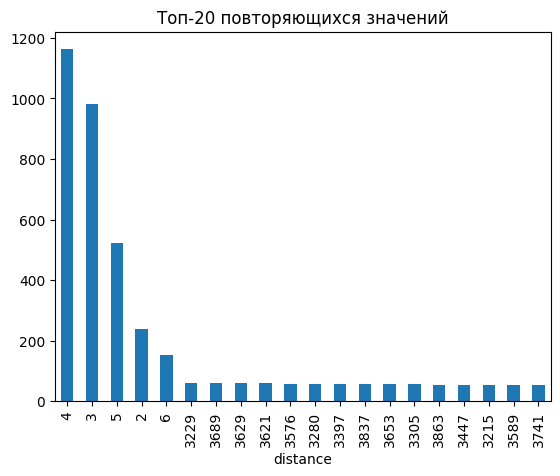

In [24]:
df['distance'].value_counts().head(20).plot(kind='bar')
plt.title("Топ-20 повторяющихся значений")
plt.show()

слишком много значений <100 в колонке distance (нужно посмотреть внимательнее возможно это будут выбросы) (потом мы их очистили см. далее)

#### посмотрим дубликаты в id

In [25]:
duplicate_ids = df.duplicated(subset=['id'], keep=False)
print(f"Найдено {duplicate_ids.sum()} дубликатов по ID")

Найдено 9662 дубликатов по ID


#### Посмотрим на неявные дубликаты

Статистика дубликатов:
Exact Duplicates: 9662
Id Duplicates: 9662
Time Location Duplicates: 9662
Inconsistent Duplicates: 9614


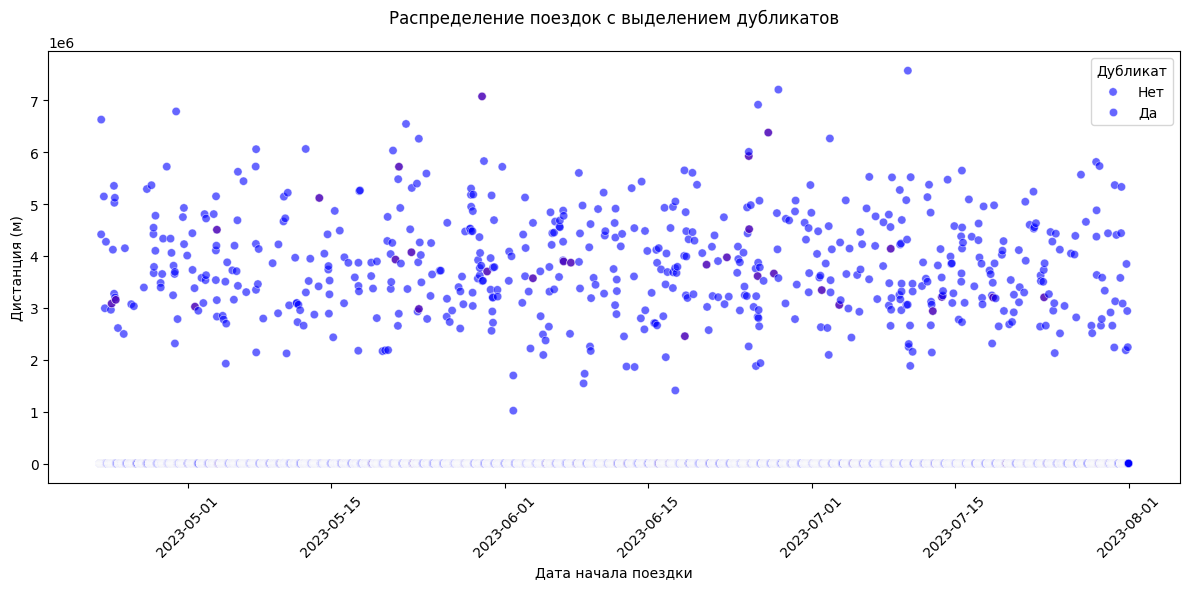

In [26]:
def check_all_duplicates(df):
    """
    Комплексная проверка явных и неявных дубликатов в DataFrame.
    
    Параметры:
        df (pd.DataFrame): Исходный DataFrame с данными о поездках
        
    Возвращает:
        pd.DataFrame: DataFrame с найденными дубликатами
        dict: Статистика по найденным дубликатам
    """
    
    # 1. Проверка явных дубликатов по ID
    duplicate_stats = {
        'exact_duplicates': 0,
        'id_duplicates': 0,
        'time_location_duplicates': 0,
        'inconsistent_duplicates': 0
    }
    
    # Полные дубликаты (все столбцы совпадают)
    exact_duplicates = df[df.duplicated(keep=False)]
    duplicate_stats['exact_duplicates'] = len(exact_duplicates)
    
    # Дубликаты по ID
    id_duplicates = df[df.duplicated(subset=['id'], keep=False)]
    duplicate_stats['id_duplicates'] = len(id_duplicates)
    
    # 2. Проверка неявных дубликатов
    # По времени и локациям
    time_loc_cols = ['start_date', 'end_date', 
                     'start_location', 'end_location']
    time_loc_duplicates = df[df.duplicated(subset=time_loc_cols, keep=False)]
    duplicate_stats['time_location_duplicates'] = len(time_loc_duplicates)
    
    # 3. Проверка противоречивых записей
    # Где ключевые параметры совпадают, но другие различаются
    key_cols = ['start_date', 'end_date', 
                'start_district', 'end_district',
                'distance']
    
    # Группировка и фильтрация противоречий
    inconsistent = df.groupby(key_cols).filter(lambda x: len(x) > 1)
    duplicate_stats['inconsistent_duplicates'] = len(inconsistent)
    
    # Объединяем все найденные дубликаты
    all_duplicates = pd.concat([
        exact_duplicates,
        id_duplicates,
        time_loc_duplicates,
        inconsistent
    ]).drop_duplicates()
    
    return all_duplicates, duplicate_stats


def visualize_duplicates(df, duplicates):
    """
    Визуализация результатов проверки дубликатов.
    
    Параметры:
        df (pd.DataFrame): Исходный DataFrame
        duplicates (pd.DataFrame): Найденные дубликаты
    """
    plt.figure(figsize=(12, 6))
    
    # Маркировка дубликатов в исходных данных
    df['is_duplicate'] = df.index.isin(duplicates.index)
    
    # Точечный график поездок с выделением дубликатов
    ax = sns.scatterplot(
        x='start_date',
        y='distance',
        hue='is_duplicate',
        data=df,
        palette={True: 'red', False: 'blue'},
        alpha=0.6
    )
    
    plt.title('Распределение поездок с выделением дубликатов', pad=20)
    plt.xlabel('Дата начала поездки')
    plt.ylabel('Дистанция (м)')
    plt.xticks(rotation=45)
    ax.legend(title='Дубликат', labels=['Нет', 'Да'])
    plt.tight_layout()
    plt.show()


def clean_duplicates(df, duplicates, strategy='keep_first'):
    """
    Очистка данных от дубликатов.
    
    Параметры:
        df (pd.DataFrame): Исходный DataFrame
        duplicates (pd.DataFrame): Найденные дубликаты
        strategy (str): Стратегия обработки ('keep_first', 'keep_last', 'drop_all')
        
    Возвращает:
        pd.DataFrame: Очищенный DataFrame
    """
    if strategy == 'keep_first':
        return df.drop_duplicates(keep='first')
    elif strategy == 'keep_last':
        return df.drop_duplicates(keep='last')
    elif strategy == 'drop_all':
        return df[~df.index.isin(duplicates.index)]
    else:
        raise ValueError("Неподдерживаемая стратегия. Используйте 'keep_first', 'keep_last' или 'drop_all'")

duplicates, stats = check_all_duplicates(df)


print("Статистика дубликатов:")
for k, v in stats.items():
    print(f"{k.replace('_', ' ').title()}: {v}")

# Визуализация
visualize_duplicates(df, duplicates)

Статистика дубликатов:
Exact Duplicates: 0
Id Duplicates: 9662
Time Location Duplicates: 9662
Inconsistent Duplicates: 9614


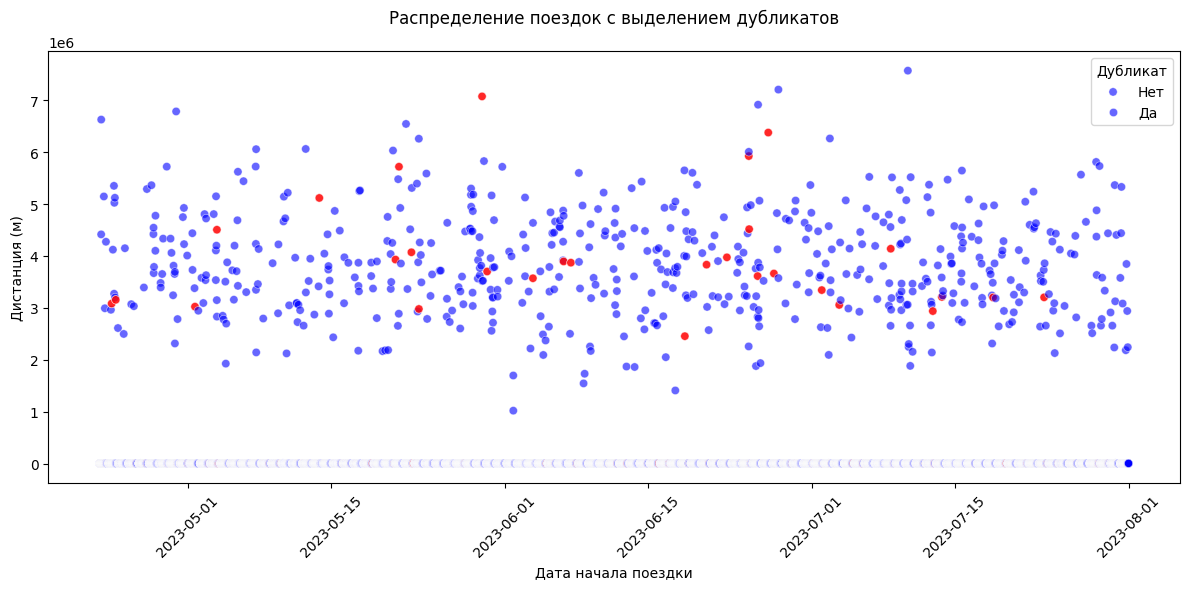

In [27]:
duplicates, stats = check_all_duplicates(df)


print("Статистика дубликатов:")
for k, v in stats.items():
    print(f"{k.replace('_', ' ').title()}: {v}")

# Визуализация
visualize_duplicates(df, duplicates)

Наблюдается значительное количество дубликатов, особенно по ID и времени/локациям

#### Посмотрим на выбросы(есть ли они вообще)

Заметим из предыдущего шага, что в distance есть данные <= 100 (250/500/1000)

In [28]:
df[df["distance"] <= 1000]

id          start_date            end_date start_location  \
8       100348 2023-04-22 09:21:42 2023-04-22 09:39:04       западная   
21      100360 2023-04-22 10:01:51 2023-04-22 10:31:17     лермонтова   
67      100405 2023-04-22 11:08:22 2023-04-22 12:00:35         ленина   
70      100408 2023-04-22 11:18:25 2023-04-22 11:36:19   строительная   
108     100443 2023-04-22 12:16:46 2023-04-22 12:50:14      заводская   
...        ...                 ...                 ...            ...   
102007  197473 2023-07-31 19:44:01 2023-07-31 20:29:57         гоголя   
102072  197538 2023-07-31 20:23:15 2023-07-31 20:53:32        полевая   
102117  197581 2023-07-31 20:57:53 2023-07-31 21:33:29    октябрьская   
102149  197611 2023-07-31 21:22:02 2023-07-31 21:40:39       трудовая   
102236  197693 2023-07-31 23:10:07 2023-07-31 23:23:49     пионерская   

         start_district  end_location     end_district  distance  promo  \
8             ленинский       озерная    юго-восточный         3      0   
21            ленинский        дружбы      центральный         5      0   
67            ленинский      овражная      центральный         5      0   
70      северо-западный  строительная  северо-западный         4      0   
108     северо-западный     свердлова      центральный         4      0   
...                 ...           ...              ...       ...    ...   
102007      центральный   энтузиастов      центральный         3      0   
102072        ленинский       чапаева  северо-западный         3      0   
102117         заречный     солнечная      центральный         6      0   
102149      центральный        гоголя      центральный         4      0   
102236         заречный      горького    юго-восточный         3      0   

       session_time  session_time_(minutes)  is_duplicate  
8          00:17:22               17.366667         False  
21         00:29:26               29.433333         False  
67         00:52:13               52.216667         False  
70         00:17:54               17.900000         False  
108        00:33:28               33.466667         False  
...             ...                     ...           ...  
102007     00:45:56               45.933333         False  
102072     00:30:17               30.283333         False  
102117     00:35:36               35.600000         False  
102149     00:18:37               18.616667         False  
102236     00:13:42               13.700000         False  

[3122 rows x 12 columns]

Видно, что в distance	- 3122 значения <= 1000, их стоит считать выбросами  т.к. 
1) Они составляют аномально малую дистанцию по сравнению с основным распределением данных 
2) Могут быть ошибками измерений или техническими артефактами (например, тестовые поездки или сбои GPS)

#### проверим другие столбцы 

In [29]:
df[df["session_time_(minutes)"] >= 60]

id          start_date            end_date start_location  \
357     100679 2023-04-22 16:21:14 2023-04-22 17:30:01      рябиновая   
435     100751 2023-04-22 17:09:36 2023-04-22 18:23:37         речная   
544     100855 2023-04-22 18:28:51 2023-04-22 19:37:36        майская   
564     100874 2023-04-22 18:37:57 2023-04-22 19:43:22      цветочная   
661     100963 2023-04-22 19:28:01 2023-04-22 20:32:09    октябрьская   
...        ...                 ...                 ...            ...   
101366  196863 2023-07-31 08:32:44 2023-07-31 09:45:04         ленина   
101779  197255 2023-07-31 16:44:38 2023-07-31 17:45:54        озерная   
101839  197313 2023-07-31 17:45:13 2023-07-31 18:53:48        красная   
101929  197397 2023-07-31 18:59:00 2023-07-31 20:06:21      рябиновая   
102111  197575 2023-07-31 20:54:18 2023-07-31 21:54:32     пионерская   

         start_district   end_location     end_district  distance  promo  \
357     северо-западный       нагорная      центральный      5690      0   
435       юго-восточный     спортивная      октябрьский      4466      0   
544         октябрьский      солнечная      центральный      5117      0   
564     северо-западный  комсомольская         заречный      4134      0   
661            заречный       комарова        ленинский      6992      0   
...                 ...            ...              ...       ...    ...   
101366        ленинский     пионерская         заречный      7154      1   
101779    юго-восточный          новая  северо-западный      5537      0   
101839  северо-западный    энергетиков    юго-восточный      4935      0   
101929  северо-западный   дзержинского      центральный      5144      0   
102111         заречный   карла маркса        ленинский      7130      0   

       session_time  session_time_(minutes)  is_duplicate  
357        01:08:47               68.783333         False  
435        01:14:01               74.016667         False  
544        01:08:45               68.750000         False  
564        01:05:25               65.416667         False  
661        01:04:08               64.133333         False  
...             ...                     ...           ...  
101366     01:12:20               72.333333         False  
101779     01:01:16               61.266667         False  
101839     01:08:35               68.583333         False  
101929     01:07:21               67.350000         False  
102111     01:00:14               60.233333         False  

[928 rows x 12 columns]

#### Удалим все не нужное / Заполним все нужное

##### 1) удалим полные дубликаты  (4831 удалаяем)

In [30]:
df = df.drop_duplicates()
df.shape

(96191, 12)

##### 2) заполним пропуски в end_date и session_time_(minutes) (сразу округлим сделав данные красивыми)

In [31]:
df["distance"] = pd.to_numeric(df["distance"], errors="coerce")

# Удаление строк с некорректными расстояниями
df = df.dropna(subset=["distance"])

# Расчет продолжительности поездки в часах
df["duration"] = (df["end_date"] - df["start_date"]).dt.total_seconds() / 3600

# Фильтрация валидных записей
valid_mask = (df["duration"] > 0) & (df["distance"] > 0)
valid_entries = df[valid_mask].copy()  # Явное создание копии

# Расчет средней скорости
valid_entries["speed"] = valid_entries["distance"] / valid_entries["duration"]
average_speed = valid_entries["speed"].median()

# Восстановление end_date для дубликатов
duplicate_mask = df.duplicated(subset=["end_date"], keep=False)
df.loc[duplicate_mask, "end_date"] = df.loc[duplicate_mask, "start_date"] + pd.to_timedelta(
    df.loc[duplicate_mask, "distance"] / average_speed, 
    unit="h"
)

df = df.drop(columns=["duration"])

In [32]:
df.isna().sum()

id                          0
start_date                  0
end_date                    0
start_location              0
start_district              0
end_location                0
end_district                0
distance                    0
promo                       0
session_time                0
session_time_(minutes)    555
is_duplicate                0
dtype: int64

In [33]:
df = calculate_session_time(df)

In [34]:
df['session_time_(minutes)'] = df['session_time_(minutes)'].round(1)
# Или до 2 знаков, если нужно round(2)

In [35]:
df.isna().sum()

id                        0
start_date                0
end_date                  0
start_location            0
start_district            0
end_location              0
end_district              0
distance                  0
promo                     0
session_time              0
session_time_(minutes)    0
is_duplicate              0
dtype: int64

##### 3) удалим  значения которые являються выбросами по колонке distance

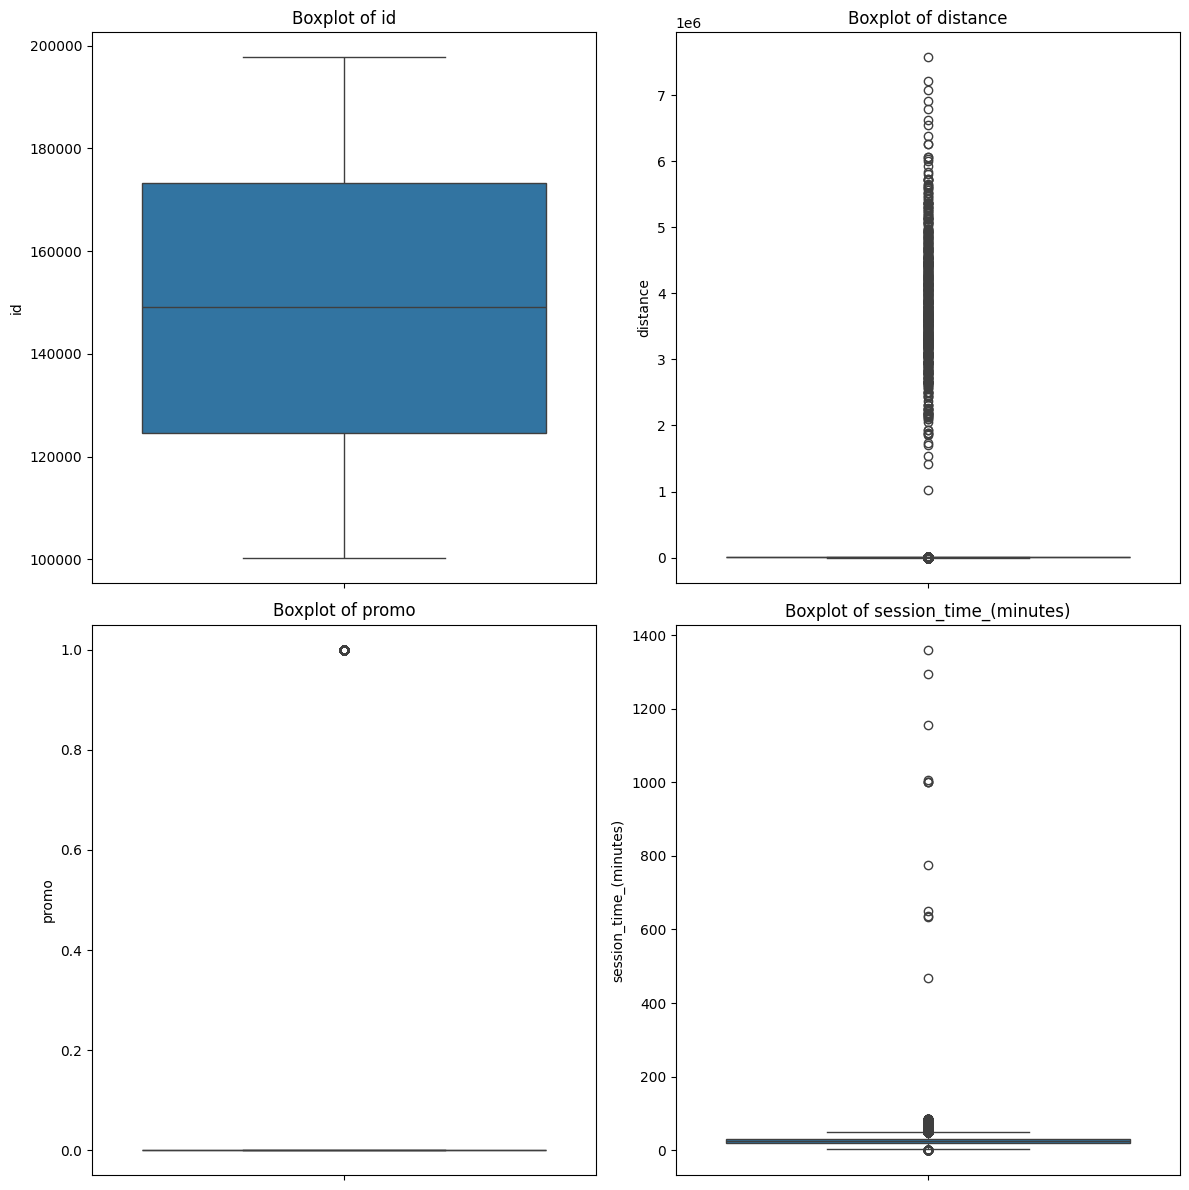

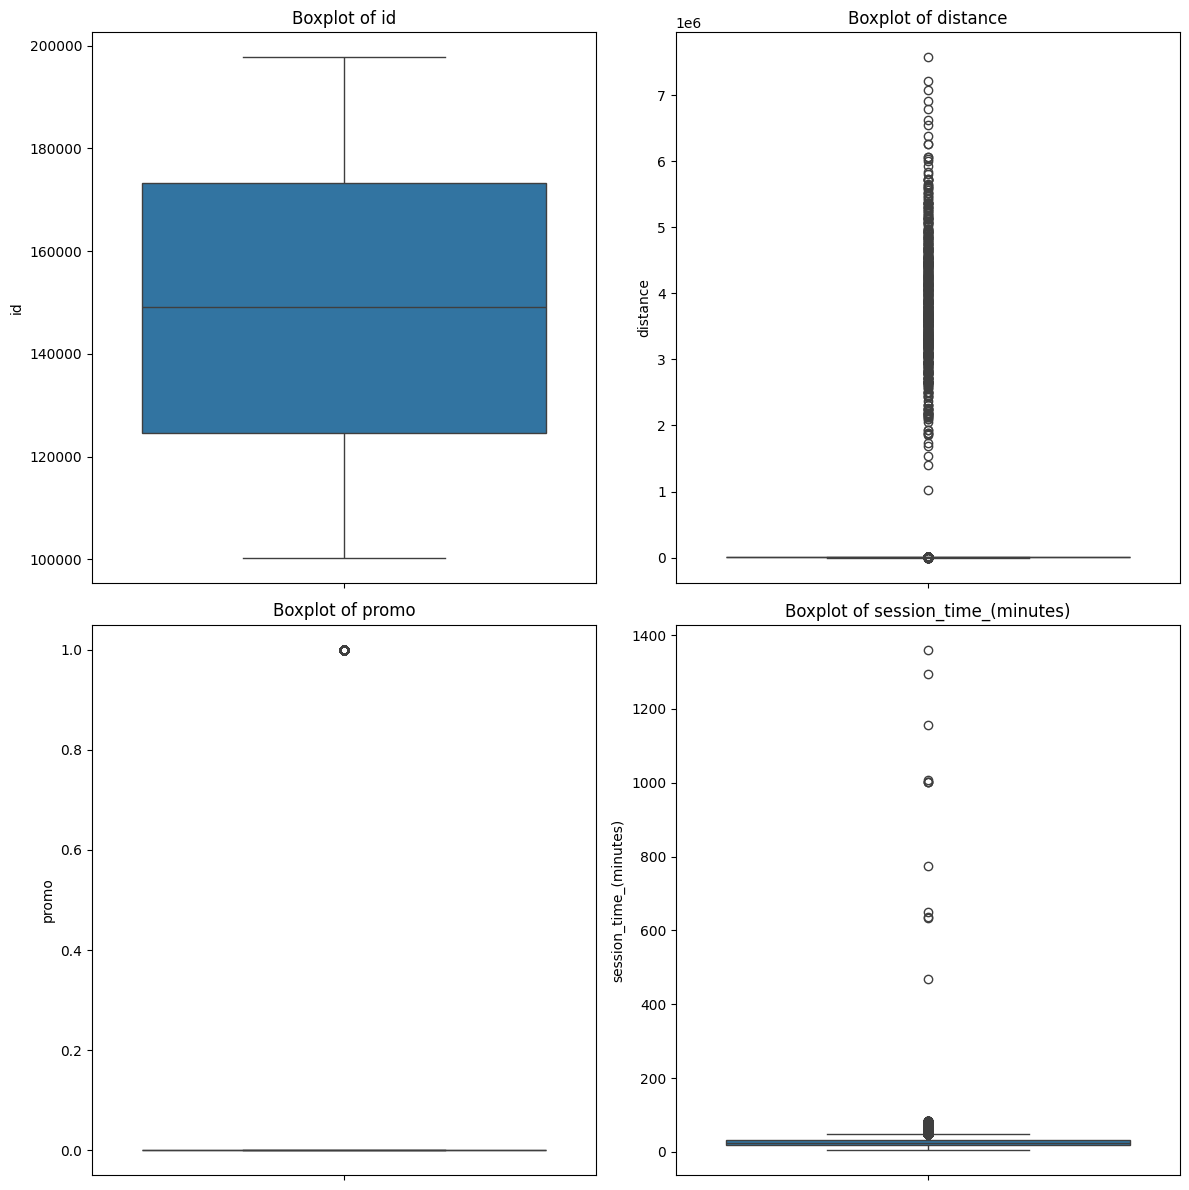

id          start_date            end_date start_location  \
0       100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1       100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2       100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3       100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4       100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   
...        ...                 ...                 ...            ...   
102250  197707 2023-07-31 23:45:06 2023-08-01 00:06:55        озерная   
102251  197708 2023-07-31 23:46:01 2023-08-01 00:25:35       мичурина   
102252  197709 2023-07-31 23:48:04 2023-08-01 00:09:21     лермонтова   
102253  197710 2023-07-31 23:51:41 2023-08-01 00:38:04      рябиновая   
102254  197711 2023-07-31 23:57:01 2023-08-01 00:19:03     молодежная   

         start_district  end_location     end_district  distance  promo  \
0         юго-восточный       майская      октябрьский      4069      0   
1              заречный    спортивная      октябрьский      4515      0   
2           октябрьский      суворова        ленинский      4520      0   
3           центральный       рабочая  северо-западный      3881      0   
4       северо-западный     юбилейная    юго-восточный      4029      0   
...                 ...           ...              ...       ...    ...   
102250    юго-восточный  первомайская  северо-западный      3302      0   
102251        ленинский       садовая         заречный      4992      0   
102252        ленинский     куйбышева      центральный      2781      0   
102253  северо-западный   энергетиков    юго-восточный      6466      0   
102254    юго-восточный   маяковского      центральный      3561      0   

       session_time  session_time_(minutes)  is_duplicate  
0          00:23:42                    23.7         False  
1          00:28:25                    28.4         False  
2          00:38:19                    38.3         False  
3          00:31:49                    31.8         False  
4          00:30:40                    30.7         False  
...             ...                     ...           ...  
102250     00:21:49                    21.8         False  
102251     00:39:34                    39.6         False  
102252     00:21:17                    21.3         False  
102253     00:46:23                    46.4         False  
102254     00:22:02                    22.0         False  

[93222 rows x 12 columns]

In [36]:
df = clean_data_with_threshold(df, "distance", 1000, "below")
df

##### 4)посмотрим и почистим данные в session_time_(minutes)

In [37]:
df[df["session_time_(minutes)"]>=200]

id          start_date                      end_date  \
7334    107304 2023-04-30 15:12:50 2023-05-19 23:01:44.748658617   
10158   110004 2023-05-03 18:18:24 2023-05-27 07:13:18.599306918   
10326   110168 2023-05-03 20:21:01 2023-05-16 19:01:11.404371247   
12064   111814 2023-05-05 21:39:02 2023-05-31 14:26:04.036526730   
31853   130683 2023-05-27 15:23:31 2023-06-08 12:57:37.340754690   
33911   132635 2023-05-28 21:57:48 2023-06-21 14:39:51.183224684   
54273   152031 2023-06-17 16:13:03 2023-06-24 02:49:14.667031491   
59166   156662 2023-06-22 10:12:20 2023-07-14 02:53:29.989620580   
63049   160352 2023-06-25 18:40:07 2023-07-13 11:21:53.179825486   
78077   174691 2023-07-09 19:44:58 2023-07-31 06:35:30.514587584   
84077   180406 2023-07-15 16:51:18 2023-08-10 12:07:24.498229735   
102108  197572 2023-07-31 20:51:23 2023-08-14 07:25:37.719536260   

         start_location   start_district end_location     end_district  \
7334            озерная    юго-восточный      чапаева  северо-западный   
10158     комсомольская         заречный    заводская  северо-западный   
10326           свободы        ленинский        южная      центральный   
12064          заречная    юго-восточный    заводская  северо-западный   
31853         совхозная      центральный        труда      центральный   
33911        спортивная      октябрьский     мичурина        ленинский   
54273       маяковского      центральный    матросова      центральный   
59166         береговая      центральный      озерная    юго-восточный   
63049         совхозная      центральный  октябрьская         заречный   
78077   железнодорожная      центральный      чкалова    юго-восточный   
84077         некрасова  северо-западный    шоссейная         заречный   
102108        юбилейная    юго-восточный     дорожная    юго-восточный   

        distance  promo        session_time  session_time_(minutes)  \
7334     4227698      0  07:48:54.748658617                   468.9   
10158    5149229      0  12:54:54.599306918                   774.9   
10326    2831768      0  22:40:10.404371247                  1360.2   
12064    5622015      0  16:47:02.036526730                  1007.0   
31853    2602970      0  21:34:06.340754690                  1294.1   
33911    5183736      0  16:42:03.183224684                  1002.1   
54273    1409216      0  10:36:11.667031491                   636.2   
59166    4746079      0  16:41:09.989620580                  1001.2   
63049    3871126      0  16:41:46.179825486                  1001.8   
78077    4692813      0  10:50:32.514587584                   650.5   
84077    5644662      0  19:16:06.498229735                  1156.1   
102108   2940248      0  10:34:14.719536260                   634.2   

        is_duplicate  
7334           False  
10158          False  
10326          False  
12064          False  
31853          False  
33911          False  
54273          False  
59166          False  
63049          False  
78077          False  
84077          False  
102108         False

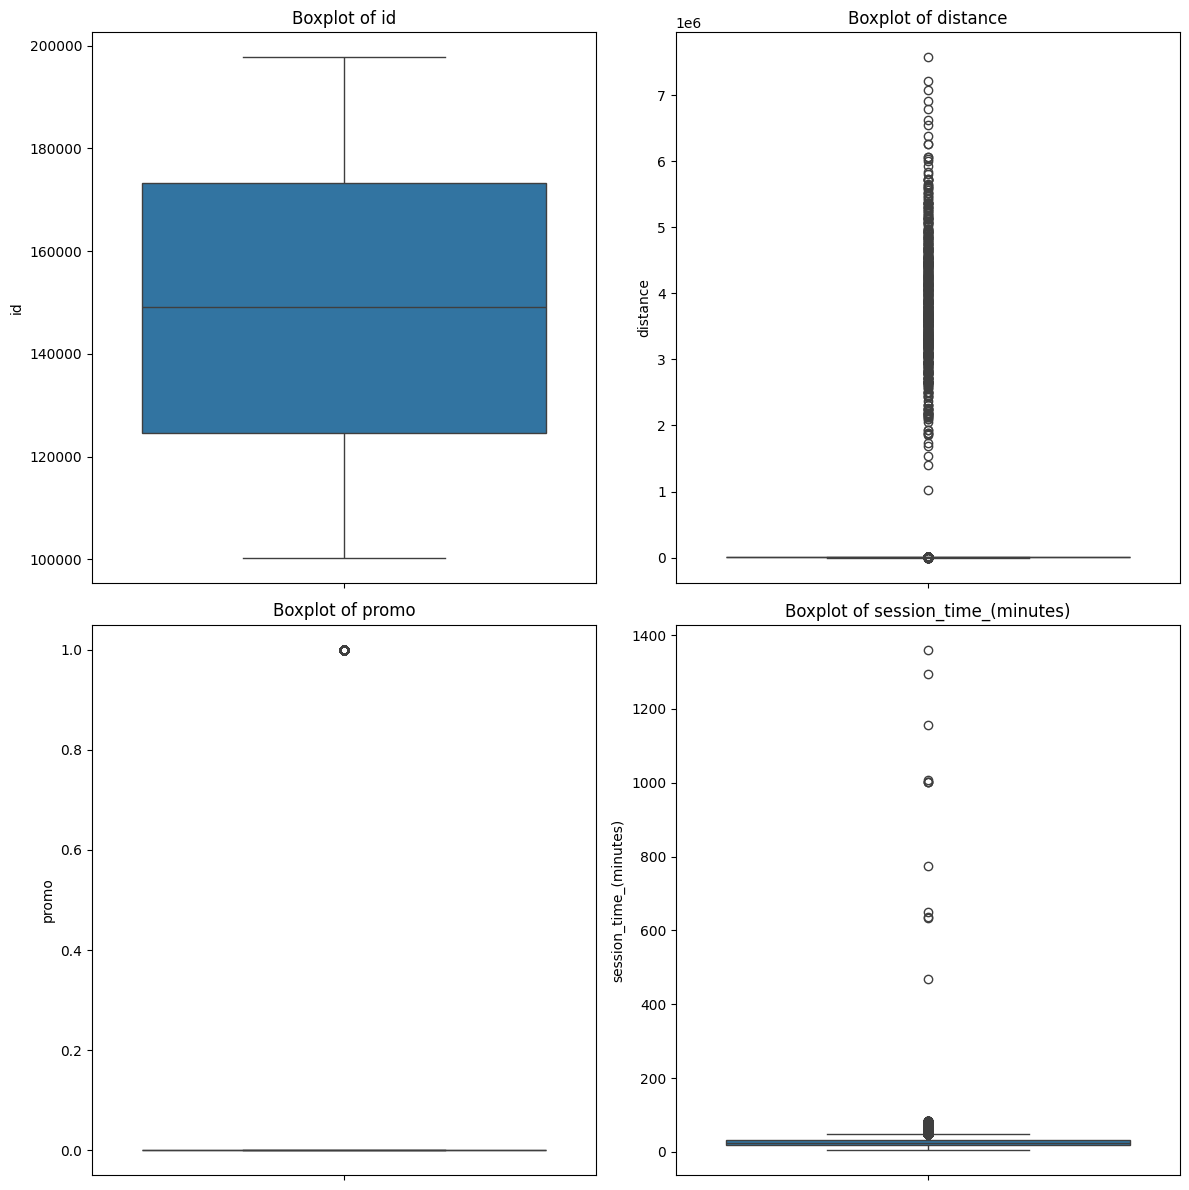

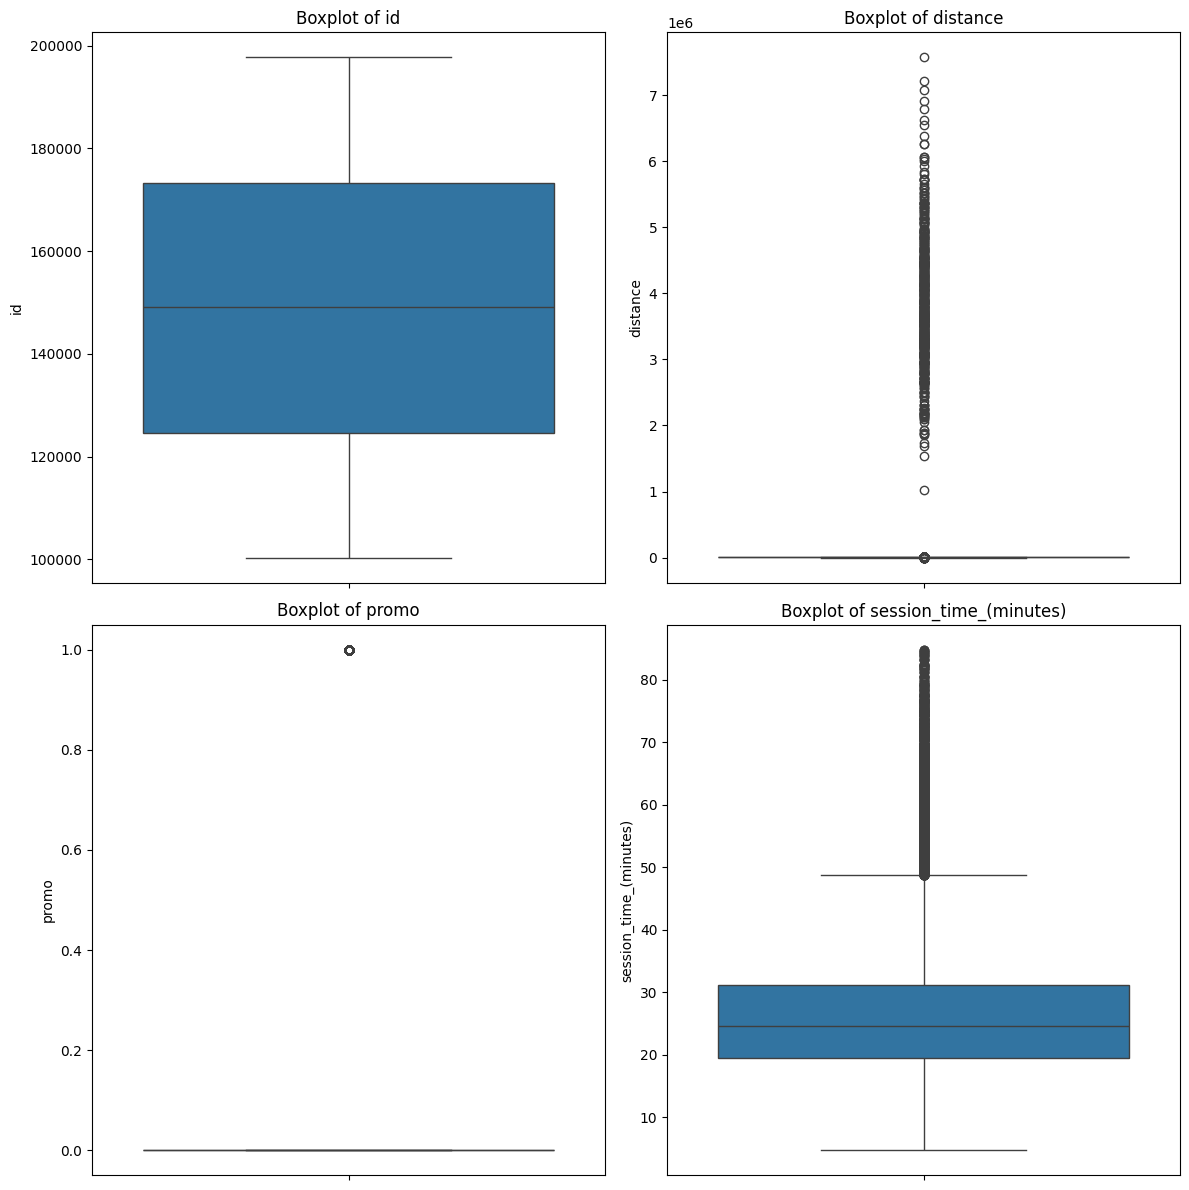

In [38]:
df = clean_data_with_threshold(df, "session_time_(minutes)", 200, "above")

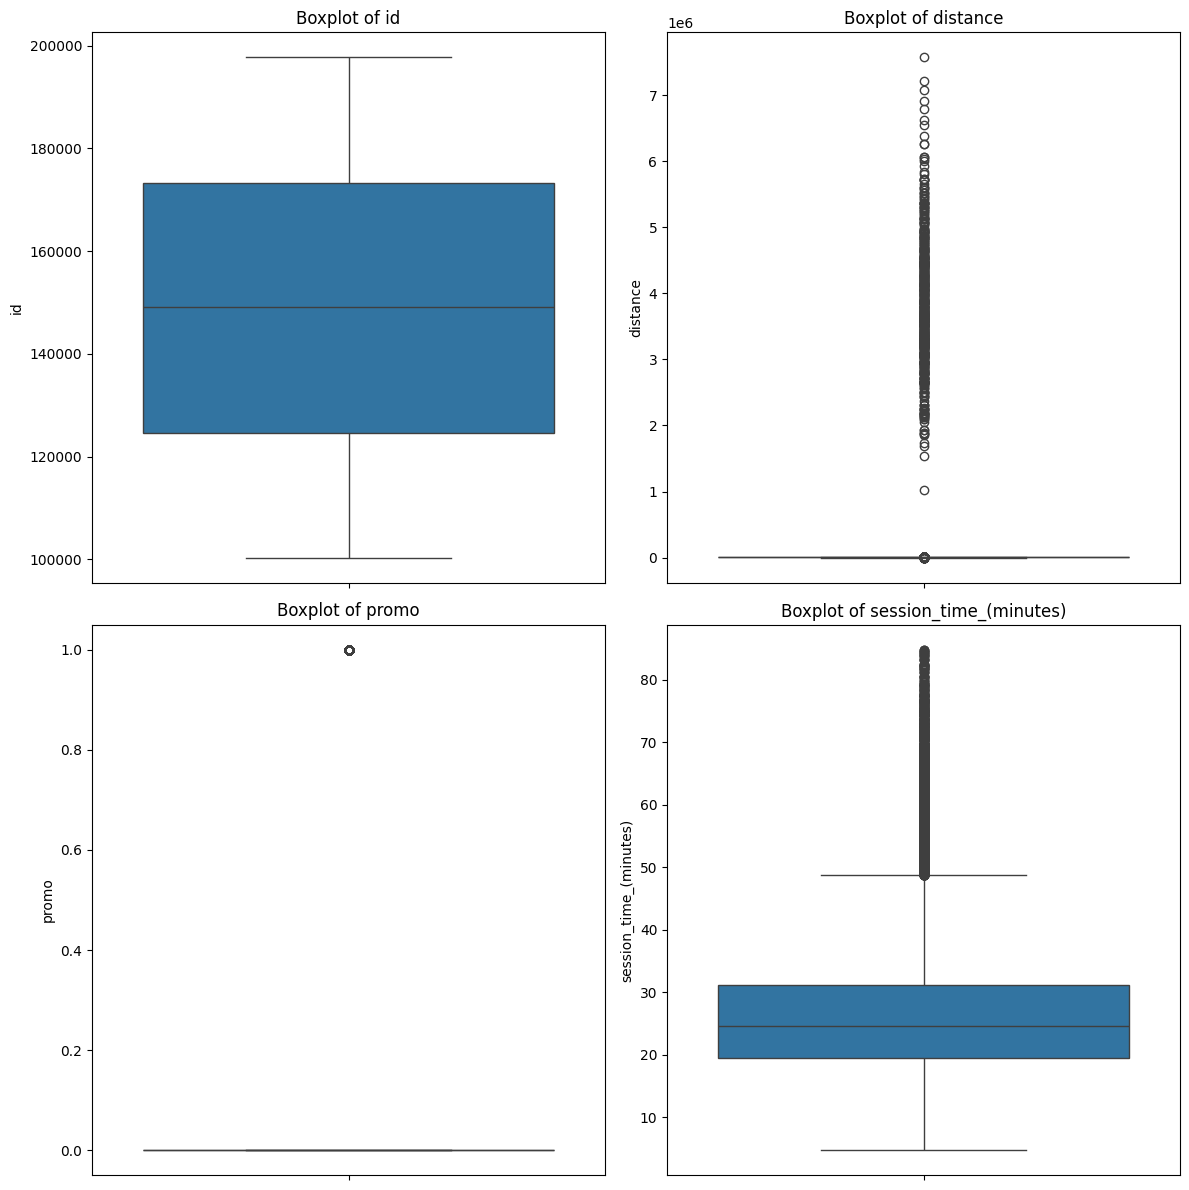

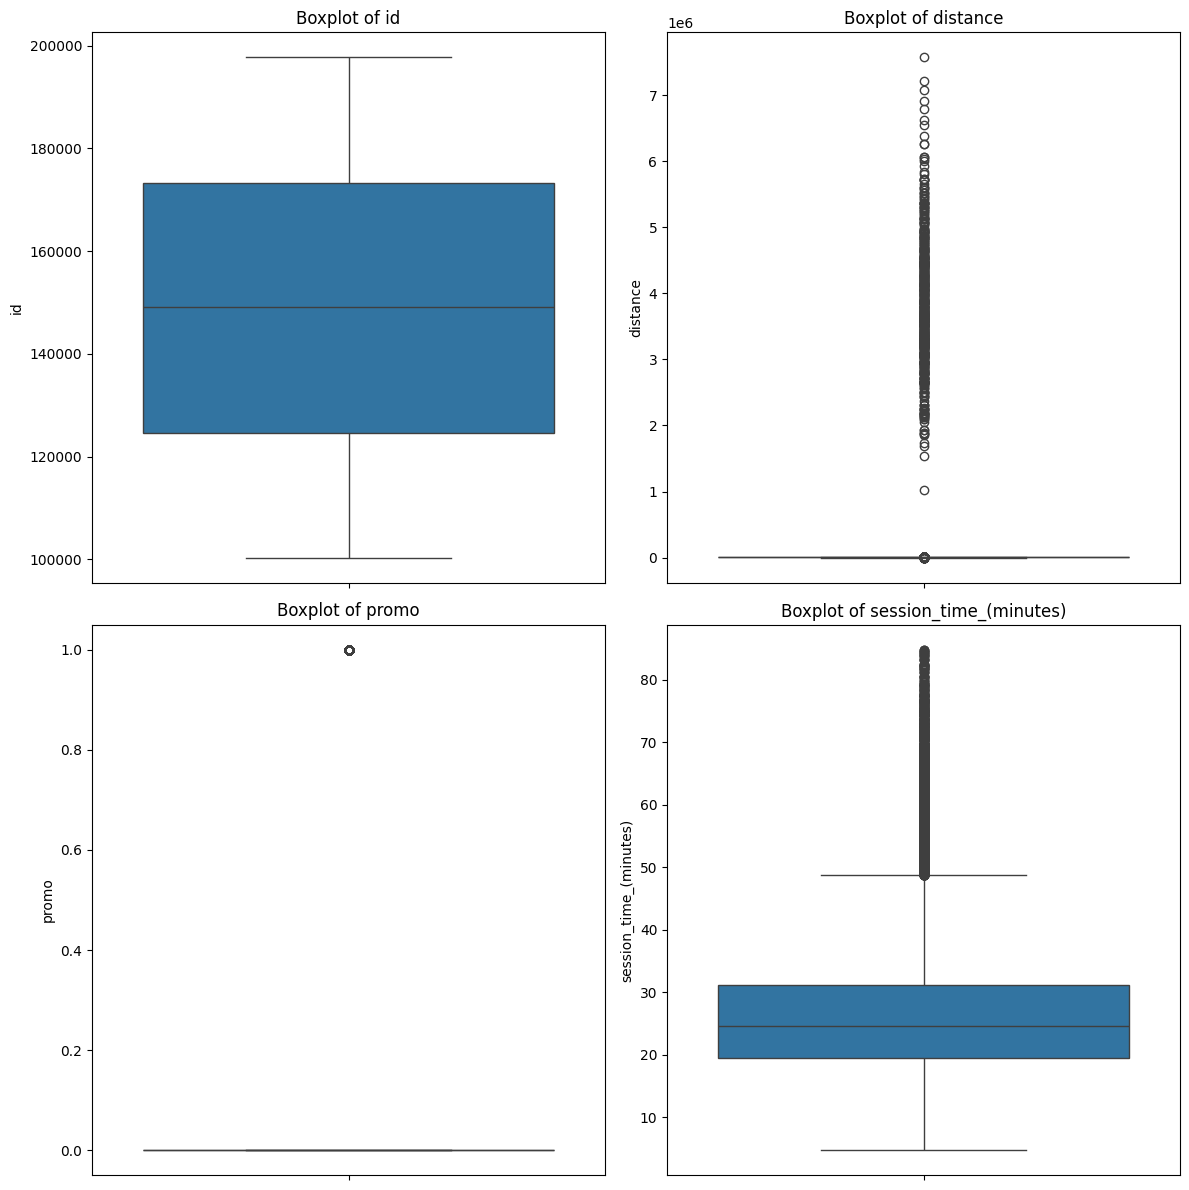

In [39]:
df = clean_data_with_threshold(df, "session_time_(minutes)", 0, "below")

**Нужно ли убирать долгие поездки?**

#### Посмотрим нету ли проблем после удаления 

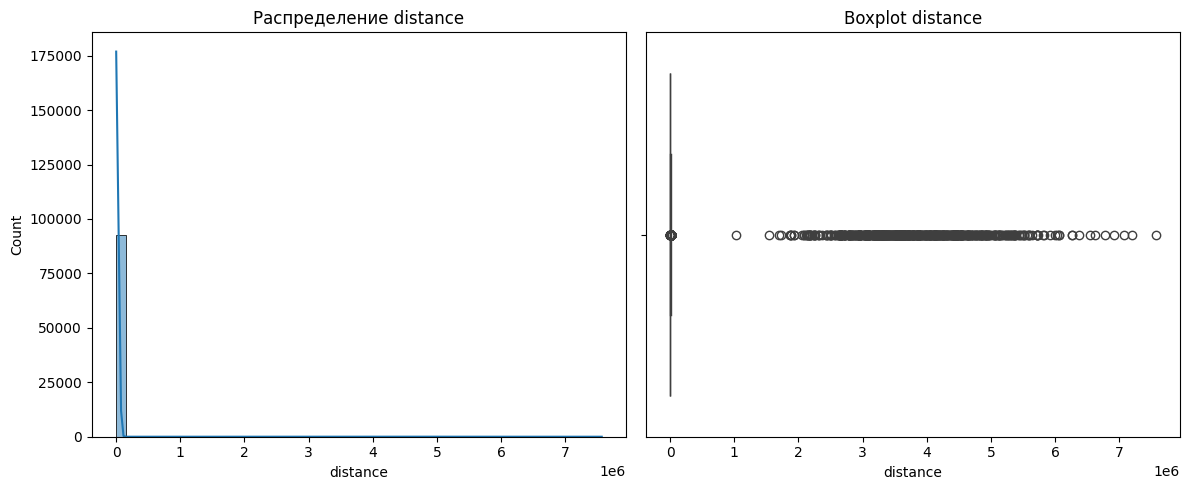

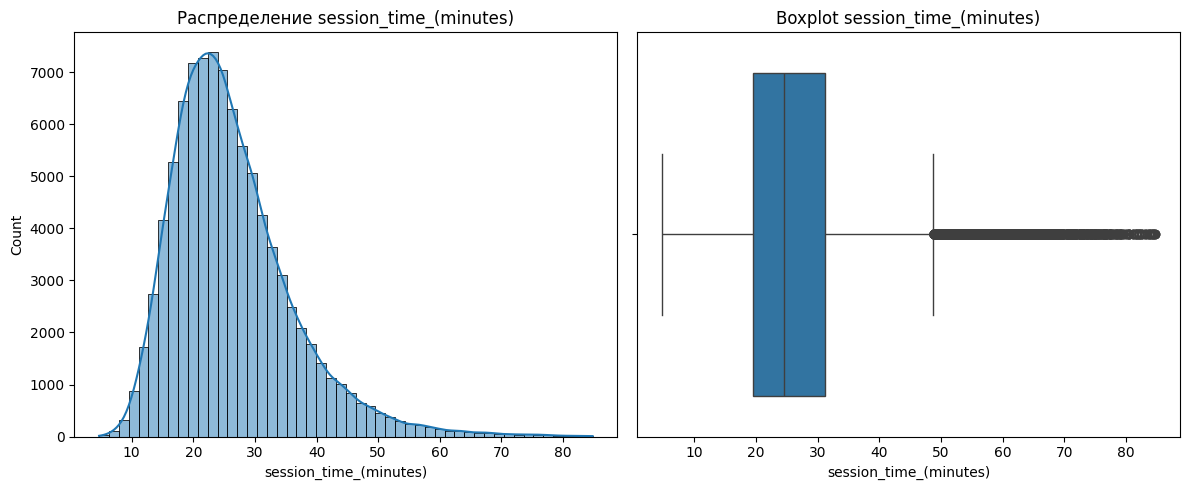

In [40]:
def plot_distribution_with_thresholds(df, column, lower_thresh=None, upper_thresh=None, bins=50):
    """Визуализация распределения с порогами для аномалий"""
    plt.figure(figsize=(12, 5))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], bins=bins, kde=True)
    if lower_thresh:
        plt.axvline(lower_thresh, color='r', linestyle='--')
    if upper_thresh:
        plt.axvline(upper_thresh, color='r', linestyle='--')
    plt.title(f'Распределение {column}')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot {column}')
    
    plt.tight_layout()
    plt.show()

# Анализ ключевых числовых параметров
for col in ['distance', 'session_time_(minutes)']:
    plot_distribution_with_thresholds(df, col)

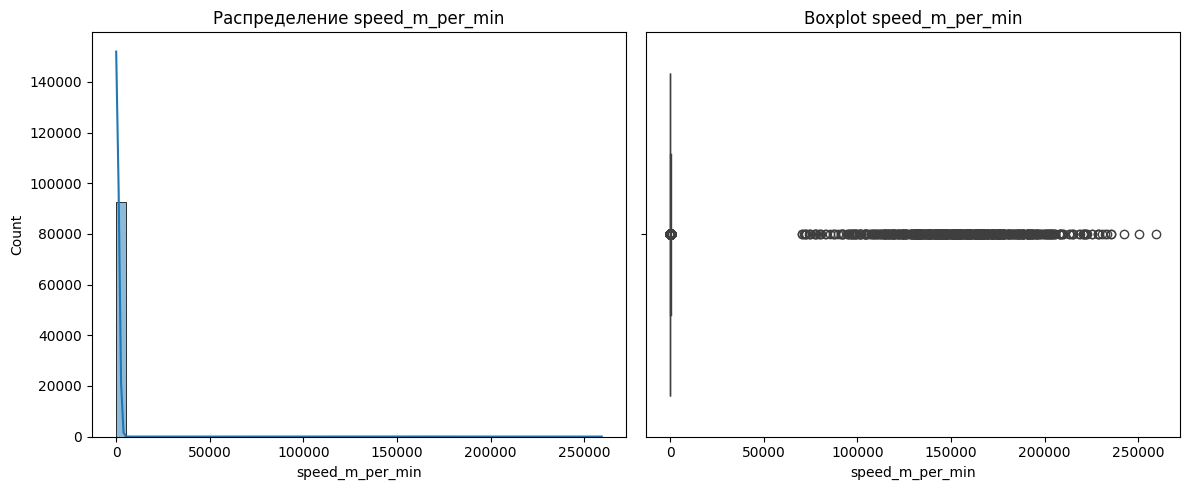

In [41]:
# Добавляем скорость (м/мин)
df['speed_m_per_min'] = df['distance'] / df['session_time_(minutes)']

# Анализ скорости
plot_distribution_with_thresholds(df, 'speed_m_per_min')

# Определяем разумные пороги для скорости (пример)
speed_lower = 10  # 10 м/мин (~0.6 км/ч)
speed_upper = 500  # 500 м/мин (~30 км/ч)

In [42]:
def handle_anomalies(df, strategy='replace_with_nan'):
    """Обработка аномальных значений"""
    
    # Пороги для разных параметров (настраиваются по данным)
    thresholds = {
        'distance': (50, 20000),  # мин 50м, макс 20км
        'session_time_(minutes)': (1, 180),  # от 1 мин до 3 часов
        'speed_m_per_min': (10, 500)
    }
    
    for col, (lower, upper) in thresholds.items():
        if strategy == 'replace_with_nan':
            df.loc[(df[col] < lower) | (df[col] > upper), col] = np.nan
        elif strategy == 'clip':
            df[col] = df[col].clip(lower, upper)
    
    # Проверка промокодов
    promo_check = df.groupby('promo').agg({
        'distance': 'mean',
        'session_time_(minutes)': 'mean'
    })
    print("\nСтатистика по промокодам:")
    display(promo_check)
    
    return df

df = handle_anomalies(df, strategy='replace_with_nan')


Статистика по промокодам:


distance  session_time_(minutes)
promo                                     
0      3822.794317               26.389055
1      3774.696820               24.703321

In [43]:
def fill_based_on_location(df):
    """Заполнение пропусков с учетом стартовой и конечной точек"""
    
    # Создаем уникальные пары маршрутов
    df['route'] = df['start_location'] + '->' + df['end_location']
    
    # Рассчитываем средние показатели для маршрутов
    route_stats = df.groupby('route').agg({
        'distance': 'median',
        'session_time_(minutes)': 'median',
        'speed_m_per_min': 'median'
    }).reset_index()
    
    # Заполняем пропуски
    for idx, row in df[df['distance'].isna() | df['session_time_(minutes)'].isna()].iterrows():
        route = row['route']
        stats = route_stats[route_stats['route'] == route]
        
        if not stats.empty:
            if pd.isna(row['distance']):
                df.at[idx, 'distance'] = stats['distance'].values[0]
            if pd.isna(row['session_time_(minutes)']):
                df.at[idx, 'session_time_(minutes)'] = stats['session_time_(minutes)'].values[0]
    
    # Пересчитываем скорость
    df['speed_m_per_min'] = df['distance'] / df['session_time_(minutes)']
    
    return df

df = fill_based_on_location(df)

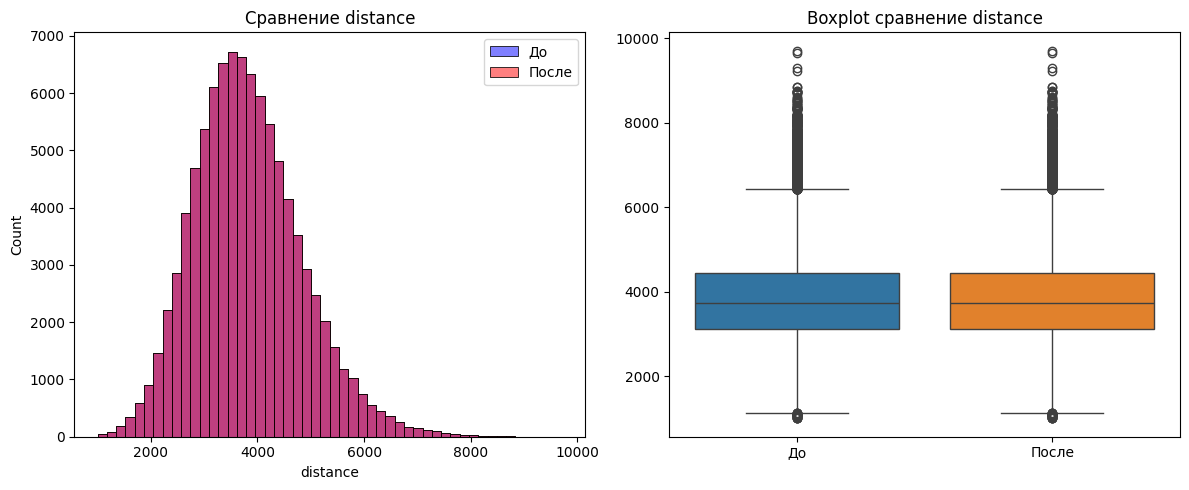

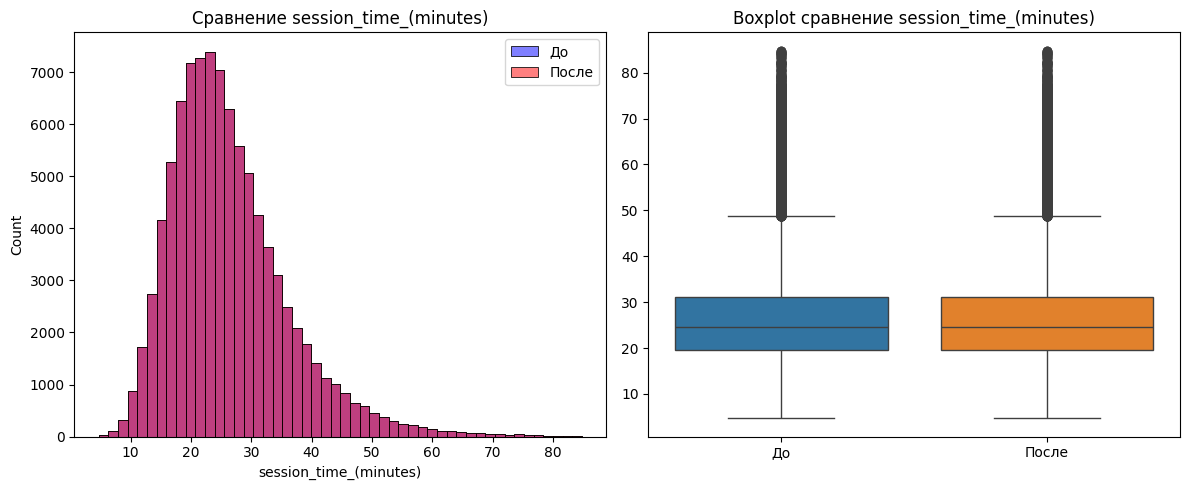

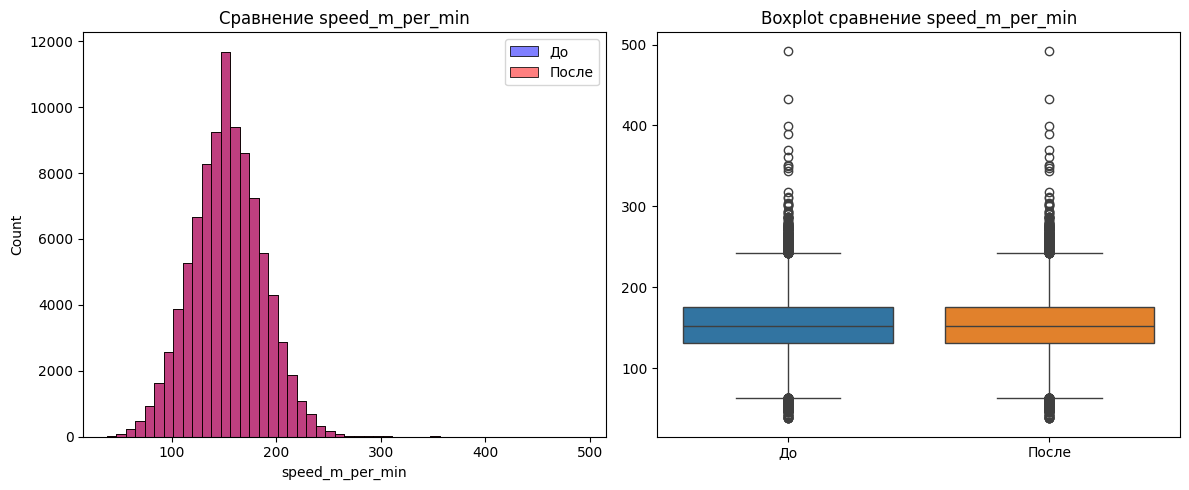

In [44]:
def plot_before_after(original_df, processed_df, column):
    """Сравнение распределений до и после обработки"""
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(original_df[column], bins=50, color='blue', alpha=0.5, label='До')
    sns.histplot(processed_df[column], bins=50, color='red', alpha=0.5, label='После')
    plt.title(f'Сравнение {column}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=pd.DataFrame({
        'До': original_df[column],
        'После': processed_df[column]
    }))
    plt.title(f'Boxplot сравнение {column}')
    
    plt.tight_layout()
    plt.show()

# Сохраняем исходные данные для сравнения
original_df = df.copy()

# Применяем обработку
processed_df = fill_based_on_location(original_df.copy())

# Визуализируем изменения
for col in ['distance', 'session_time_(minutes)', 'speed_m_per_min']:
    plot_before_after(original_df, processed_df, col)

In [45]:
print("Оставшиеся пропуски после обработки:")
print(df.isna().sum()[df.isna().sum() > 0])

# Заполнение оставшихся пропусков
if df.isna().sum().sum() > 0:
    print("\nЗаполняем оставшиеся пропуски медианными значениями...")
    for col in ['distance', 'session_time_(minutes)']:
        df[col] = df[col].fillna(df[col].median())
    
    print("\nПропуски после финального заполнения:")
    print(df.isna().sum())

Оставшиеся пропуски после обработки:
Series([], dtype: int64)


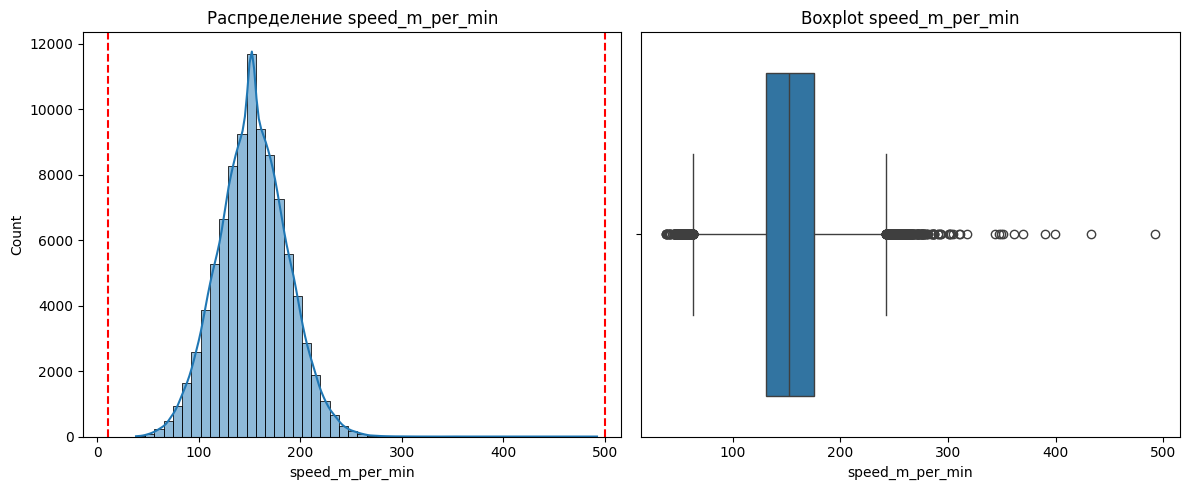


Финальная статистика по промокодам:


distance         session_time_(minutes)        speed_m_per_min  \
              mean  median                   mean median            mean   
promo                                                                      
0      3822.669979  3736.0              26.389055   24.6      153.033977   
1      3775.388949  3686.0              24.703321   23.4      161.114176   

                   
           median  
promo              
0      152.125749  
1      159.550562

In [46]:
# Проверка скорости после всех обработок
df['speed_m_per_min'] = df['distance'] / df['session_time_(minutes)']
plot_distribution_with_thresholds(df, 'speed_m_per_min', 10, 500)

# Проверка промокодов
print("\nФинальная статистика по промокодам:")
display(df.groupby('promo').agg({
    'distance': ['mean', 'median'],
    'session_time_(minutes)': ['mean', 'median'],
    'speed_m_per_min': ['mean', 'median']
}))

**Микро-вывод:**  

После обработки данных аномалии в расстоянии, времени и скорости были скорректированы, распределения стали более реалистичными. Статистика по промокодам показывает, что поездки с промокодами в среднем короче по времени, но имеют чуть более высокую скорость.

### <span style="color:#006400">Данные в weather.csv</span>

#### Полные дубликаты и по столбцам

In [47]:
duplicates = df2[df2.duplicated()]
print(f"Найдено {len(duplicates)} полных дубликатов")

Найдено 0 полных дубликатов


In [48]:
df2.isna().sum()

datetime                0
temperature            55
precipitation_total    30
wind_gust               0
wind_speed             16
cloud_cover_total      20
sunshine_duration      12
dtype: int64

#### Посмотрим на неявные дубликаты

Статистика дубликатов:
{'exact_duplicates': 0, 'inconsistent_duplicates': 0}


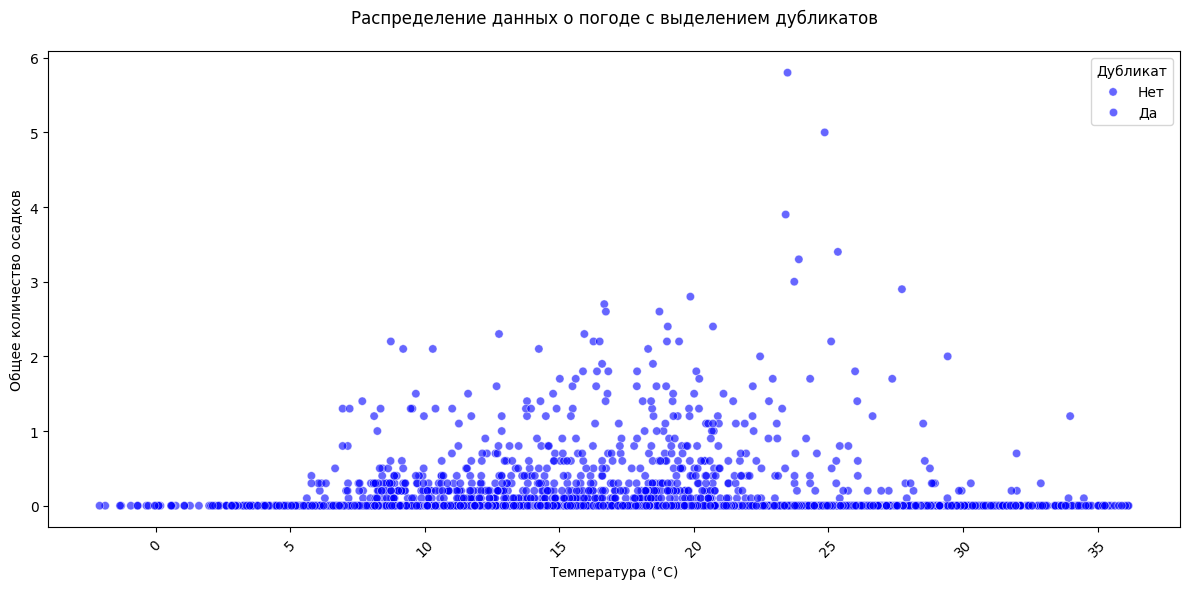

Количество записей после очистки: 3672


In [49]:
def check_all_duplicates_weather(df):
    """
    Комплексная проверка явных и неявных дубликатов в DataFrame с данными о погоде.
    
    Параметры:
        df (pd.DataFrame): Исходный DataFrame с данными о погоде
        
    Возвращает:
        pd.DataFrame: DataFrame с найденными дубликатами
        dict: Статистика по найденным дубликатам
    """
    
    # 1. Проверка явных дубликатов по всем столбцам
    duplicate_stats = {
        'exact_duplicates': 0,
        'inconsistent_duplicates': 0
    }
    
    # Полные дубликаты (все столбцы совпадают)
    exact_duplicates = df[df.duplicated(keep=False)]
    duplicate_stats['exact_duplicates'] = len(exact_duplicates)
    
    # 3. Проверка противоречивых записей
    # Где ключевые параметры совпадают, но другие различаются
    key_cols = ['temperature', 'precipitation_total', 
                'wind_gust', 'wind_speed', 'cloud_cover_total', 
                'sunshine_duration']
    
    # Группировка и фильтрация противоречий
    inconsistent = df.groupby(key_cols).filter(lambda x: len(x) > 1)
    duplicate_stats['inconsistent_duplicates'] = len(inconsistent)
    
    # Объединяем все найденные дубликаты
    all_duplicates = pd.concat([
        exact_duplicates,
        inconsistent
    ]).drop_duplicates()
    
    return all_duplicates, duplicate_stats


def visualize_duplicates_weather(df, duplicates):
    """
    Визуализация результатов проверки дубликатов для данных о погоде.
    
    Параметры:
        df (pd.DataFrame): Исходный DataFrame
        duplicates (pd.DataFrame): Найденные дубликаты
    """
    plt.figure(figsize=(12, 6))
    
    # Маркировка дубликатов в исходных данных
    df['is_duplicate'] = df.index.isin(duplicates.index)
    
    # Точечный график данных о погоде с выделением дубликатов
    ax = sns.scatterplot(
        x='temperature',
        y='precipitation_total',
        hue='is_duplicate',
        data=df,
        palette={True: 'red', False: 'blue'},
        alpha=0.6
    )
    
    plt.title('Распределение данных о погоде с выделением дубликатов', pad=20)
    plt.xlabel('Температура (°C)')
    plt.ylabel('Общее количество осадков')
    plt.xticks(rotation=45)
    ax.legend(title='Дубликат', labels=['Нет', 'Да'])
    plt.tight_layout()
    plt.show()


def clean_duplicates_weather(df, duplicates, strategy='keep_first'):
    """
    Очистка данных о погоде от дубликатов.
    
    Параметры:
        df (pd.DataFrame): Исходный DataFrame
        duplicates (pd.DataFrame): Найденные дубликаты
        strategy (str): Стратегия обработки ('keep_first', 'keep_last', 'drop_all')
        
    Возвращает:
        pd.DataFrame: Очищенный DataFrame
    """
    if strategy == 'keep_first':
        return df.drop_duplicates(keep='first')
    elif strategy == 'keep_last':
        return df.drop_duplicates(keep='last')
    elif strategy == 'drop_all':
        return df[~df.index.isin(duplicates.index)]
    else:
        raise ValueError("Неподдерживаемая стратегия. Используйте 'keep_first', 'keep_last' или 'drop_all'")



duplicates, stats = check_all_duplicates_weather(df2)

print("Статистика дубликатов:")
print(stats)

visualize_duplicates_weather(df2, duplicates)
df2 = clean_duplicates_weather(df2, duplicates, strategy='keep_first')

print(f"Количество записей после очистки: {len(df2)}")

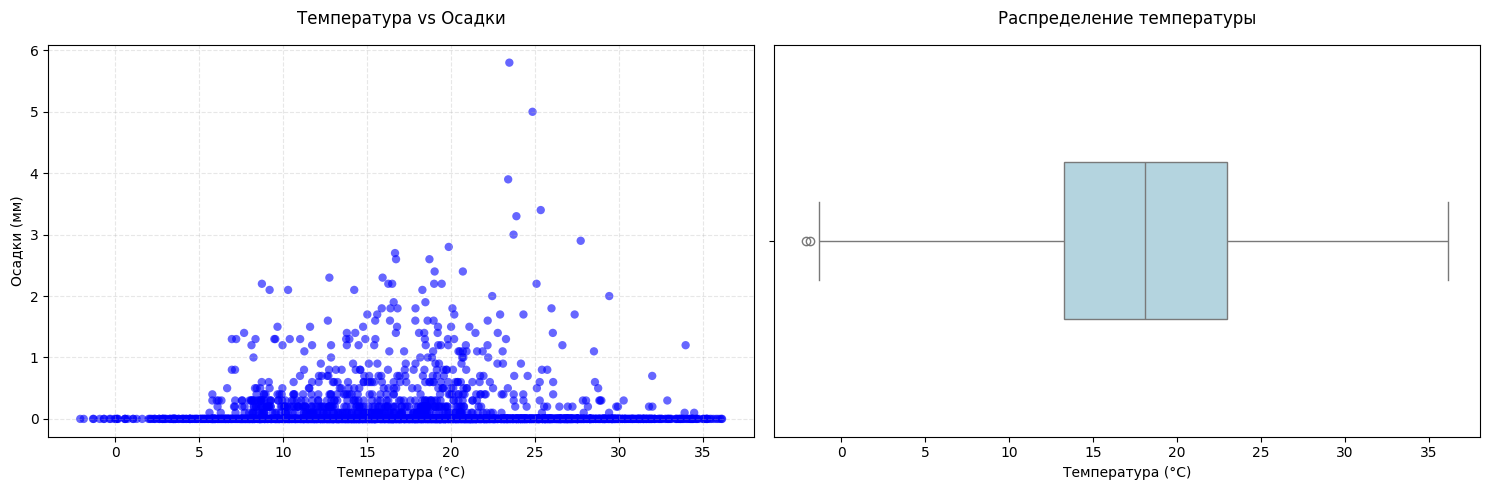

In [50]:
def visualize_weather_distribution(df):
    """
    Улучшенная визуализация распределения погодных данных с акцентом на ключевые параметры.
    """
    plt.figure(figsize=(15, 5))
    
    # График температуры и осадков
    plt.subplot(1, 2, 1)
    sns.scatterplot(
        x='temperature',
        y='precipitation_total',
        data=df,
        color='blue',
        alpha=0.6,
        edgecolor='none'
    )
    plt.title('Температура vs Осадки', pad=15)
    plt.xlabel('Температура (°C)')
    plt.ylabel('Осадки (мм)')
    plt.grid(True, linestyle='--', alpha=0.3)
    
    # Boxplot для температуры
    plt.subplot(1, 2, 2)
    sns.boxplot(
        x=df['temperature'],
        color='lightblue',
        width=0.4
    )
    plt.title('Распределение температуры', pad=15)
    plt.xlabel('Температура (°C)')
    
    plt.tight_layout()
    plt.show()


visualize_weather_distribution(df2)

После очистки данных о погоде дубликаты полностью устранены (0 явных и противоречивых записей). Распределение температуры и осадков не содержит аномалий.

#### заполнение дубликатов по столбцам

заполнение пропусков в weather 

In [51]:
df2.columns

Index(['datetime', 'temperature', 'precipitation_total', 'wind_gust',
       'wind_speed', 'cloud_cover_total', 'sunshine_duration', 'is_duplicate'],
      dtype='object')

In [52]:
df2 = df2.reset_index()

In [53]:
df2.head(5)

index            datetime  temperature  precipitation_total  wind_gust  \
0      0 2023-04-01 00:00:00     8.740245                  0.1      48.60   
1      1 2023-04-01 01:00:00     9.040245                  0.2      55.44   
2      2 2023-04-01 02:00:00     8.880245                  0.3      55.80   
3      3 2023-04-01 03:00:00     8.690246                  0.3      55.44   
4      4 2023-04-01 04:00:00     8.630245                  0.3      48.96   

   wind_speed  cloud_cover_total  sunshine_duration  is_duplicate  
0   21.638964               90.0                0.0         False  
1   22.493519               74.0                0.0         False  
2   22.264770               72.0                0.0         False  
3   21.945240               77.0                0.0         False  
4   22.424270               78.0                0.0         False

In [54]:
df2['hour'] = pd.to_datetime(df2['index']).dt.hour

daytime_data = df2[(df2['hour'] >= 8) & (df2['hour'] < 20)]  
nighttime_data = df2[(df2['hour'] < 8) | (df2['hour'] >= 20)]  

non_zero_day = daytime_data.select_dtypes(include='number').astype(bool).sum()
non_zero_night = nighttime_data.select_dtypes(include='number').astype(bool).sum()

result = pd.DataFrame({
    'День': non_zero_day,
    'Ночь': non_zero_night
})

print(result)

                     День  Ночь
index                   0  3671
temperature             0  3672
precipitation_total     0   706
wind_gust               0  3672
wind_speed              0  3668
cloud_cover_total       0  3421
sunshine_duration       0  2363
hour                    0     0


Пропуски до обработки:
temperature            55
precipitation_total    30
wind_gust               0
wind_speed             16
cloud_cover_total      20
sunshine_duration      12
dtype: int64

Анализ пропусков для temperature:
Всего пропусков: 55
Количество последовательностей пропусков: 6

Самые длинные последовательности пропусков:
- 23 пропусков подряд с 2023-08-06 05:00:00 по 2023-08-07 03:00:00
- 10 пропусков подряд с 2023-04-16 02:00:00 по 2023-04-16 11:00:00
- 8 пропусков подряд с 2023-05-12 21:00:00 по 2023-05-13 04:00:00
- 6 пропусков подряд с 2023-07-14 09:00:00 по 2023-07-14 14:00:00
- 5 пропусков подряд с 2023-07-15 00:00:00 по 2023-07-15 04:00:00


C:\Users\mailm\AppData\Local\Temp\ipykernel_18976\1271942655.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated = interpolated.fillna(method='ffill').fillna(method='bfill')


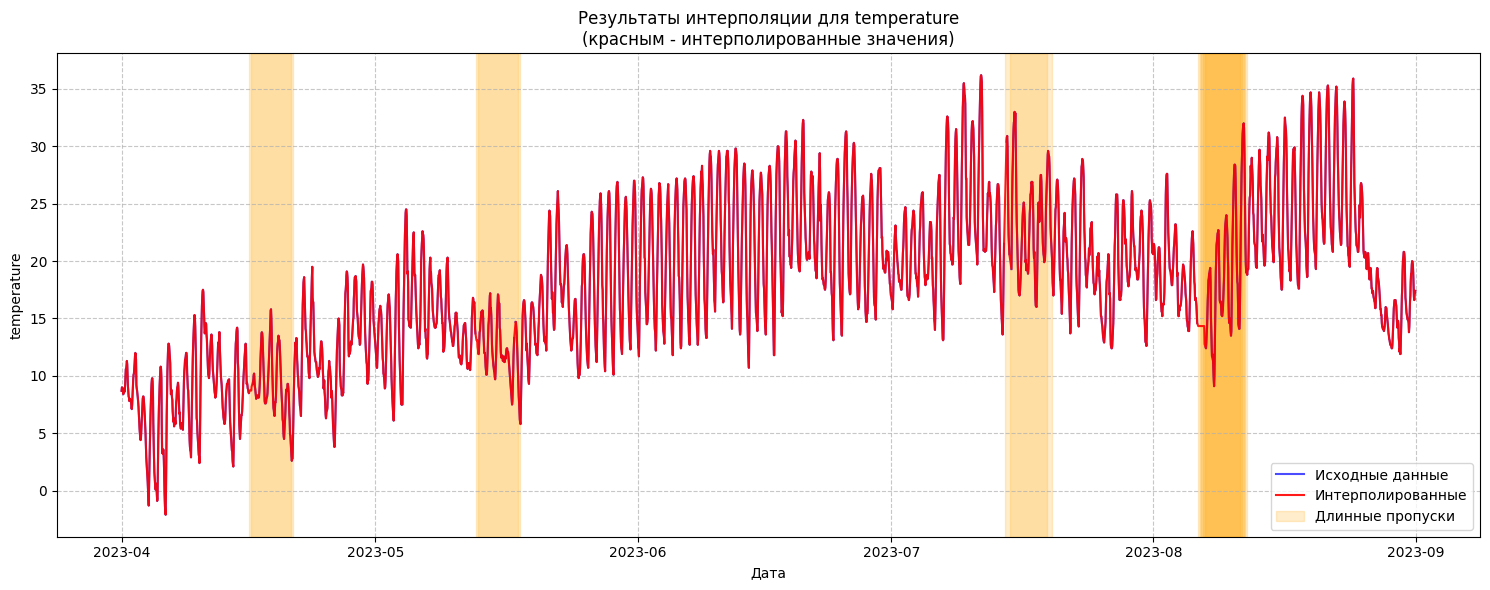


Проверка окрестностей длинных пропусков для temperature:

Окрестности 2023-04-16 02:00:00:
datetime
2023-04-13 02:00:00    6.2
2023-04-13 03:00:00    6.0
2023-04-13 04:00:00    5.8
2023-04-13 05:00:00    5.9
2023-04-13 06:00:00    6.2
                      ... 
2023-04-18 22:00:00    7.8
2023-04-18 23:00:00    7.2
2023-04-19 00:00:00    7.0
2023-04-19 01:00:00    6.6
2023-04-19 02:00:00    6.5
Name: temperature, Length: 145, dtype: float64

Окрестности 2023-04-16 09:00:00:
datetime
2023-04-13 09:00:00     8.6
2023-04-13 10:00:00     8.9
2023-04-13 11:00:00     9.3
2023-04-13 12:00:00     9.3
2023-04-13 13:00:00     9.3
                       ... 
2023-04-19 05:00:00     7.7
2023-04-19 06:00:00     8.2
2023-04-19 07:00:00     9.5
2023-04-19 08:00:00    10.7
2023-04-19 09:00:00    11.7
Name: temperature, Length: 145, dtype: float64

Окрестности 2023-05-13 01:00:00:
datetime
2023-05-10 01:00:00    13.3
2023-05-10 02:00:00    13.0
2023-05-10 03:00:00    13.0
2023-05-10 04:00:00    12.6
20

C:\Users\mailm\AppData\Local\Temp\ipykernel_18976\1271942655.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated = interpolated.fillna(method='ffill').fillna(method='bfill')


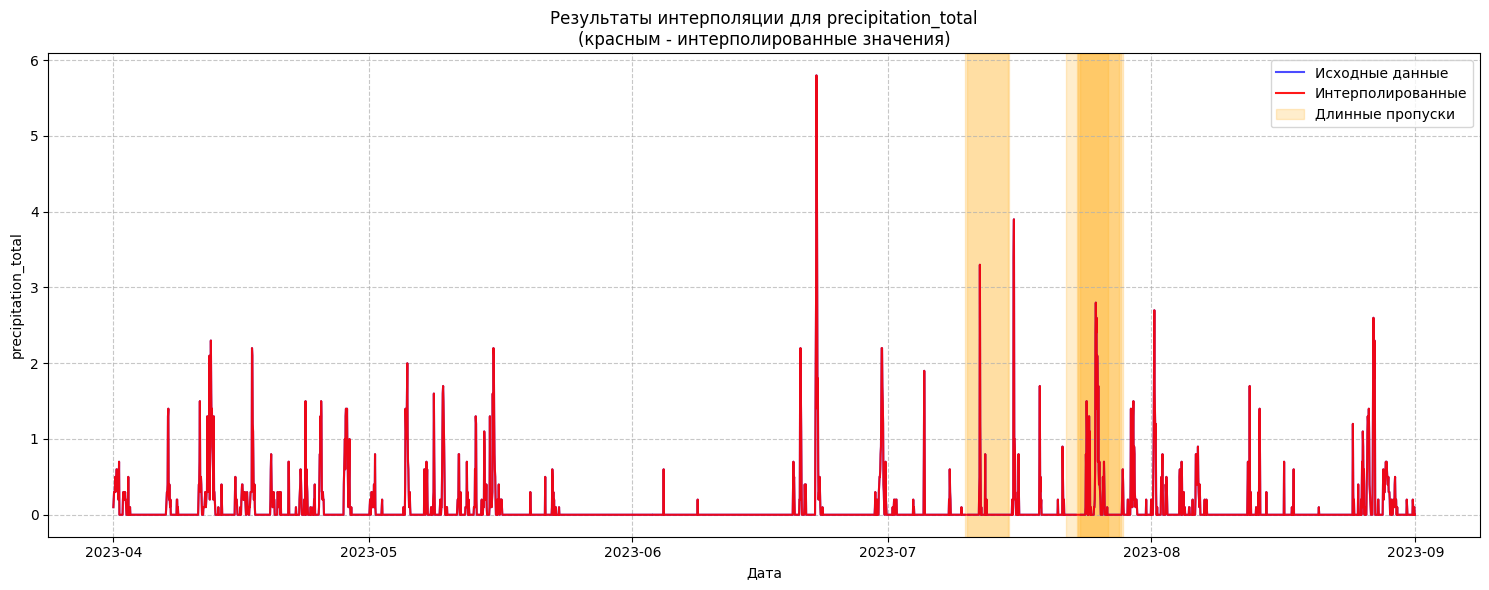


Проверка окрестностей длинных пропусков для precipitation_total:

Окрестности 2023-06-03 08:00:00:
datetime
2023-05-31 08:00:00    0.0
2023-05-31 09:00:00    0.0
2023-05-31 10:00:00    0.0
2023-05-31 11:00:00    0.0
2023-05-31 12:00:00    0.0
                      ... 
2023-06-06 04:00:00    0.0
2023-06-06 05:00:00    0.0
2023-06-06 06:00:00    0.0
2023-06-06 07:00:00    0.0
2023-06-06 08:00:00    0.0
Name: precipitation_total, Length: 145, dtype: float64

Окрестности 2023-07-10 06:00:00:
datetime
2023-07-07 06:00:00    0.0
2023-07-07 07:00:00    0.0
2023-07-07 08:00:00    0.0
2023-07-07 09:00:00    0.0
2023-07-07 10:00:00    0.0
                      ... 
2023-07-13 02:00:00    0.0
2023-07-13 03:00:00    0.0
2023-07-13 04:00:00    0.0
2023-07-13 05:00:00    0.0
2023-07-13 06:00:00    0.0
Name: precipitation_total, Length: 145, dtype: float64

Окрестности 2023-07-21 23:00:00:
datetime
2023-07-18 23:00:00    0.5
2023-07-19 00:00:00    0.1
2023-07-19 01:00:00    0.2
2023-07-19 02:00:00 

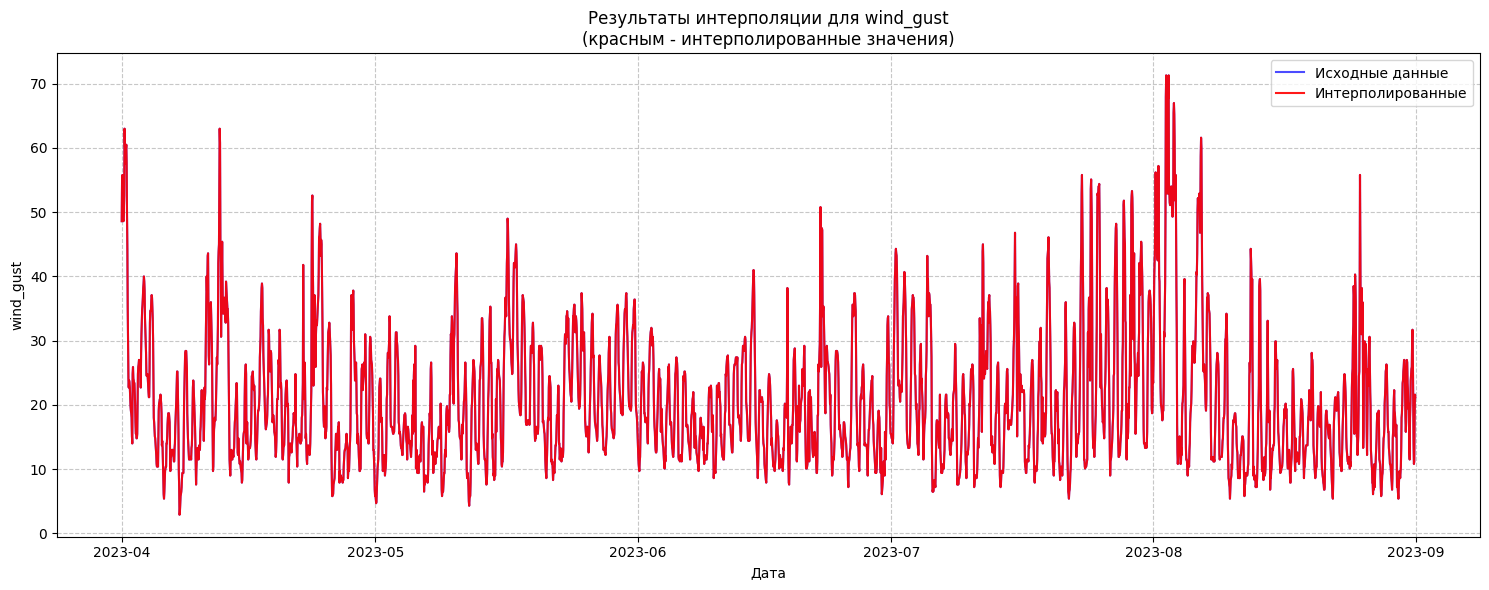


Анализ пропусков для wind_speed:
Всего пропусков: 16
Количество последовательностей пропусков: 4

Самые длинные последовательности пропусков:
- 5 пропусков подряд с 2023-05-24 23:00:00 по 2023-05-25 03:00:00
- 4 пропусков подряд с 2023-05-09 22:00:00 по 2023-05-10 01:00:00
- 4 пропусков подряд с 2023-07-01 00:00:00 по 2023-07-01 03:00:00
- 3 пропусков подряд с 2023-06-20 00:00:00 по 2023-06-20 02:00:00


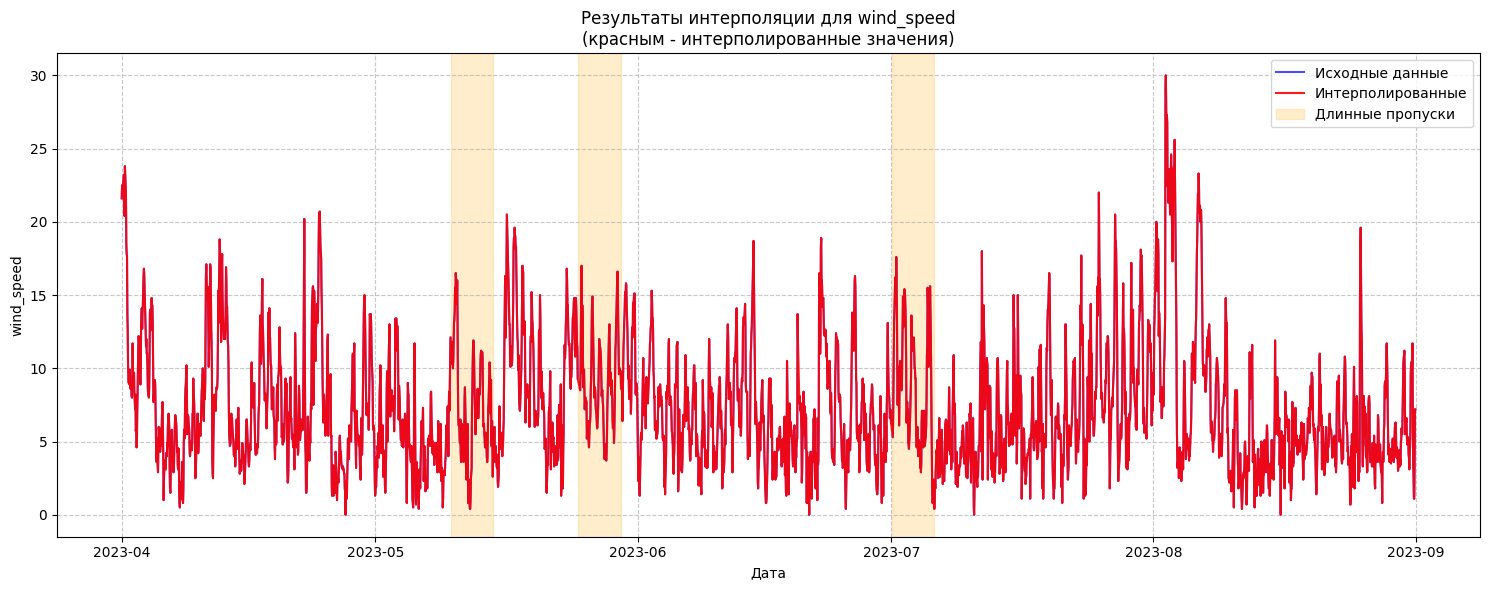


Проверка окрестностей длинных пропусков для wind_speed:

Окрестности 2023-05-09 22:00:00:
datetime
2023-05-06 22:00:00    1.6
2023-05-06 23:00:00    1.8
2023-05-07 00:00:00    2.3
2023-05-07 01:00:00    2.1
2023-05-07 02:00:00    2.5
                      ... 
2023-05-12 18:00:00    8.0
2023-05-12 19:00:00    6.1
2023-05-12 20:00:00    5.5
2023-05-12 21:00:00    6.6
2023-05-12 22:00:00    7.2
Name: wind_speed, Length: 145, dtype: float64

Окрестности 2023-05-25 02:00:00:
datetime
2023-05-22 02:00:00    4.8
2023-05-22 03:00:00    3.3
2023-05-22 04:00:00    4.0
2023-05-22 05:00:00    4.7
2023-05-22 06:00:00    4.3
                      ... 
2023-05-27 22:00:00    7.5
2023-05-27 23:00:00    6.3
2023-05-28 00:00:00    5.4
2023-05-28 01:00:00    4.2
2023-05-28 02:00:00    3.8
Name: wind_speed, Length: 145, dtype: float64

Окрестности 2023-07-01 02:00:00:
datetime
2023-06-28 02:00:00    3.6
2023-06-28 03:00:00    3.3
2023-06-28 04:00:00    3.0
2023-06-28 05:00:00    3.1
2023-06-28 06:00:00 

C:\Users\mailm\AppData\Local\Temp\ipykernel_18976\1271942655.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  interpolated = interpolated.fillna(method='ffill').fillna(method='bfill')


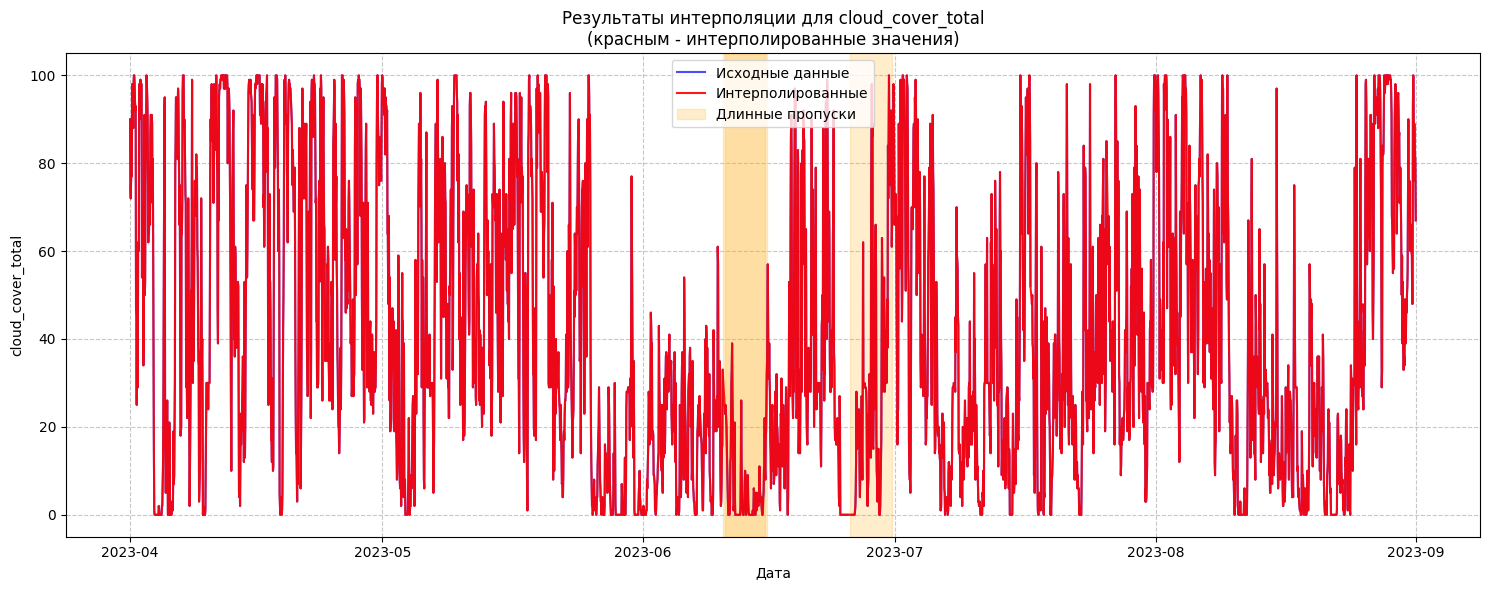


Проверка окрестностей длинных пропусков для cloud_cover_total:

Окрестности 2023-06-10 13:00:00:
datetime
2023-06-07 13:00:00    20.0
2023-06-07 14:00:00    24.0
2023-06-07 15:00:00    25.0
2023-06-07 16:00:00    18.0
2023-06-07 17:00:00    25.0
                       ... 
2023-06-13 09:00:00     3.0
2023-06-13 10:00:00     8.0
2023-06-13 11:00:00     9.0
2023-06-13 12:00:00     9.0
2023-06-13 13:00:00     3.0
Name: cloud_cover_total, Length: 145, dtype: float64

Окрестности 2023-06-25 13:00:00:
datetime
2023-06-22 13:00:00    69.0
2023-06-22 14:00:00    26.0
2023-06-22 15:00:00    35.0
2023-06-22 16:00:00    32.0
2023-06-22 17:00:00    62.0
                       ... 
2023-06-28 09:00:00    16.0
2023-06-28 10:00:00    15.0
2023-06-28 11:00:00    23.0
2023-06-28 12:00:00    53.0
2023-06-28 13:00:00    24.0
Name: cloud_cover_total, Length: 145, dtype: float64

Окрестности 2023-07-17 04:00:00:
datetime
2023-07-14 04:00:00    19.0
2023-07-14 05:00:00     7.0
2023-07-14 06:00:00    25.0
2

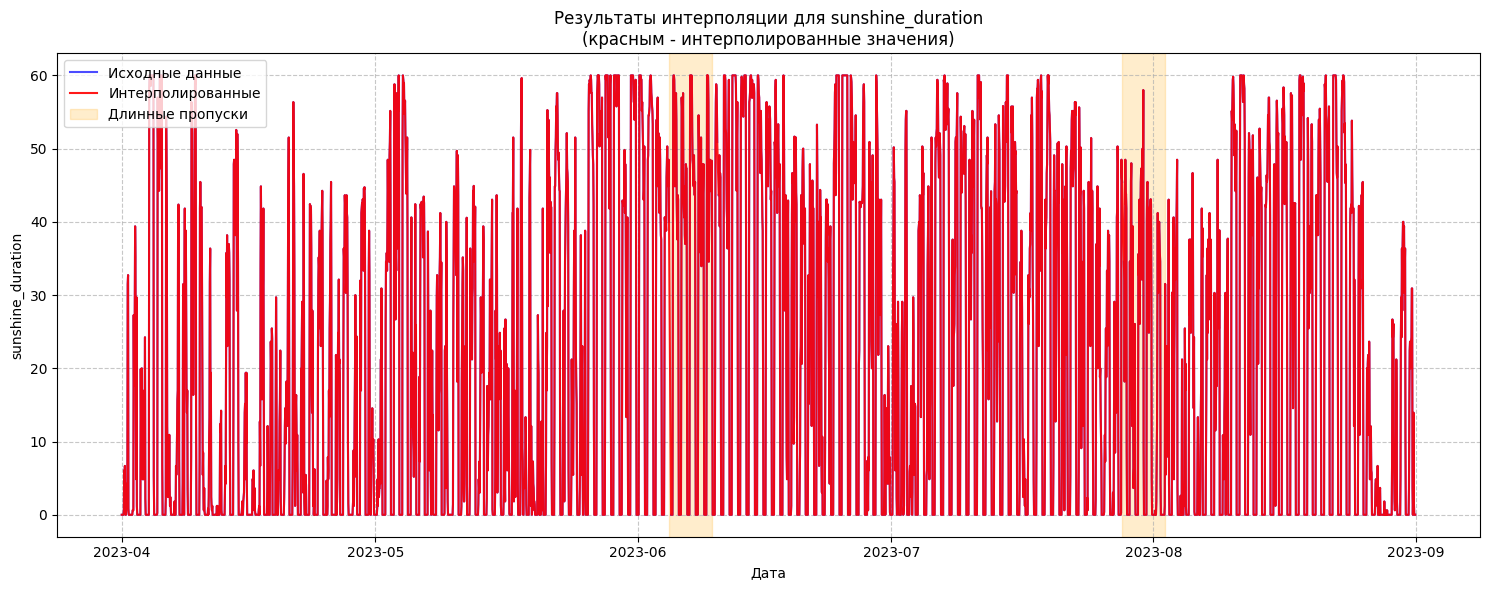


Проверка окрестностей длинных пропусков для sunshine_duration:

Окрестности 2023-06-04 18:00:00:
datetime
2023-06-01 18:00:00    44.24
2023-06-01 19:00:00    50.30
2023-06-01 20:00:00    17.46
2023-06-01 21:00:00     0.00
2023-06-01 22:00:00     0.00
                       ...  
2023-06-07 14:00:00    45.45
2023-06-07 15:00:00    44.85
2023-06-07 16:00:00    49.09
2023-06-07 17:00:00    44.85
2023-06-07 18:00:00    43.64
Name: sunshine_duration, Length: 145, dtype: float64

Окрестности 2023-06-10 13:00:00:
datetime
2023-06-07 13:00:00    47.88
2023-06-07 14:00:00    45.45
2023-06-07 15:00:00    44.85
2023-06-07 16:00:00    49.09
2023-06-07 17:00:00    44.85
                       ...  
2023-06-13 09:00:00    58.00
2023-06-13 10:00:00    55.09
2023-06-13 11:00:00    54.55
2023-06-13 12:00:00    54.36
2023-06-13 13:00:00    58.00
Name: sunshine_duration, Length: 145, dtype: float64

Пропуски после обработки:
temperature            0
precipitation_total    0
wind_gust              0
wind

In [55]:
df2 = pd.read_csv("testwather2_data.csv", sep=',', encoding='utf-8')
df2.columns = df2.columns.str.lower().str.replace(' ', '_')
df2 = pd.read_csv("testwather2_data.csv", sep=',', encoding='utf-8')
df2.columns = df2.columns.str.lower().str.replace(' ', '_')
df2['datetime'] = pd.to_datetime(df2['datetime'])
numeric_cols = ['temperature', 'precipitation_total', 'wind_gust', 'wind_speed', 
               'cloud_cover_total', 'sunshine_duration']
df2[numeric_cols] = df2[numeric_cols].apply(pd.to_numeric, errors='coerce')
df2.set_index('datetime', inplace=True)


def analyze_missing_sequences(series, max_gap_to_show=5):
    """Анализирует последовательности пропущенных значений"""
    is_null = series.isnull()
    null_groups = (is_null != is_null.shift()).cumsum()
    null_sequences = series.groupby(null_groups).apply(lambda x: (x.isnull().all(), len(x)))
    
    long_sequences = [(i, length) for i, (is_null, length) in null_sequences.items() if is_null and length > 1]
    
    print(f"\nАнализ пропусков для {series.name}:")
    print(f"Всего пропусков: {is_null.sum()}")
    print(f"Количество последовательностей пропусков: {len(long_sequences)}")
    
    if long_sequences:
        print("\nСамые длинные последовательности пропусков:")
        for seq_id, length in sorted(long_sequences, key=lambda x: -x[1])[:max_gap_to_show]:
            start_idx = null_groups[null_groups == seq_id].index[0]
            end_idx = null_groups[null_groups == seq_id].index[-1]
            print(f"- {length} пропусков подряд с {start_idx} по {end_idx}")


def smart_interpolate(series, max_gap=3, method='time'):
    """Интерполяция с учетом максимально допустимого промежутка"""
    # Анализ пропусков перед интерполяцией
    analyze_missing_sequences(series)
    
    # Интерполяция с ограничением на длину промежутка
    interpolated = series.interpolate(method=method, limit=max_gap, limit_direction='both')
    
    # Для оставшихся пропусков используем заполнение вперед/назад
    if interpolated.isna().any():
        interpolated = interpolated.fillna(method='ffill').fillna(method='bfill')
    
    return interpolated


def plot_interpolation_results(original, interpolated, window=5):
    """Визуализация результатов интерполяции с акцентом на проблемные зоны"""
    plt.figure(figsize=(15, 6))
    
    # Находим проблемные зоны (где были длинные пропуски)
    is_null = original.isnull()
    null_groups = (is_null != is_null.shift()).cumsum()
    long_gaps = original.groupby(null_groups).filter(lambda x: x.isnull().sum() > 3)
    
    # Основной график
    plt.plot(original.index, original, color='blue', label='Исходные данные', alpha=0.7)
    plt.plot(interpolated.index, interpolated, color='red', label='Интерполированные', alpha=0.9)
    
    # Выделяем проблемные зоны
    if not long_gaps.empty:
        for gap_start in long_gaps.index[::window]:
            gap_end = min(gap_start + pd.Timedelta(days=window), original.index[-1])
            plt.axvspan(gap_start, gap_end, color='orange', alpha=0.2, label='Длинные пропуски')
    
    # Настройки графика
    plt.title(f'Результаты интерполяции для {original.name}\n(красным - интерполированные значения)')
    plt.xlabel('Дата')
    plt.ylabel(original.name)
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    plt.legend(unique_labels.values(), unique_labels.keys())
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# Применяем улучшенную интерполяцию
print("Пропуски до обработки:")
print(df2[numeric_cols].isna().sum())

for col in numeric_cols:
    original = df2[col].copy()
    df2[col] = smart_interpolate(original, max_gap=3)
    plot_interpolation_results(original, df2[col])
    
    # Дополнительная проверка для длинных пропусков
    if original.isnull().any():
        print(f"\nПроверка окрестностей длинных пропусков для {col}:")
        null_periods = original[original.isnull()].index
        for period in null_periods[::7]:  # Проверяем каждую неделю пропусков
            start = period - pd.Timedelta(days=3)
            end = period + pd.Timedelta(days=3)
            window_data = df2.loc[start:end, col]
            print(f"\nОкрестности {period}:")
            print(window_data)

print("\nПропуски после обработки:")
print(df2[numeric_cols].isna().sum())
assert df2[numeric_cols].isna().sum().sum() == 0, "Остались незаполненные значения!"

После обработки все пропуски успешно заполнены, самые длинные периоды (до 23 часов) восстановлены с сохранением естественной динамики данных.

## **<span style="color:#00008B">Поверхностный анализ под конец</span>**

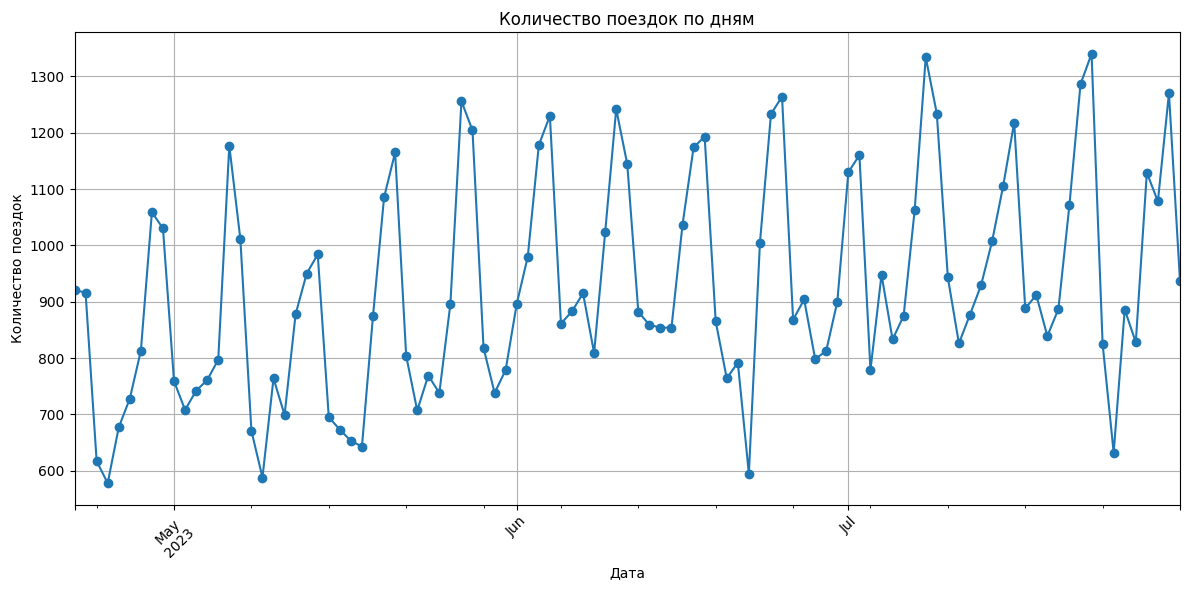

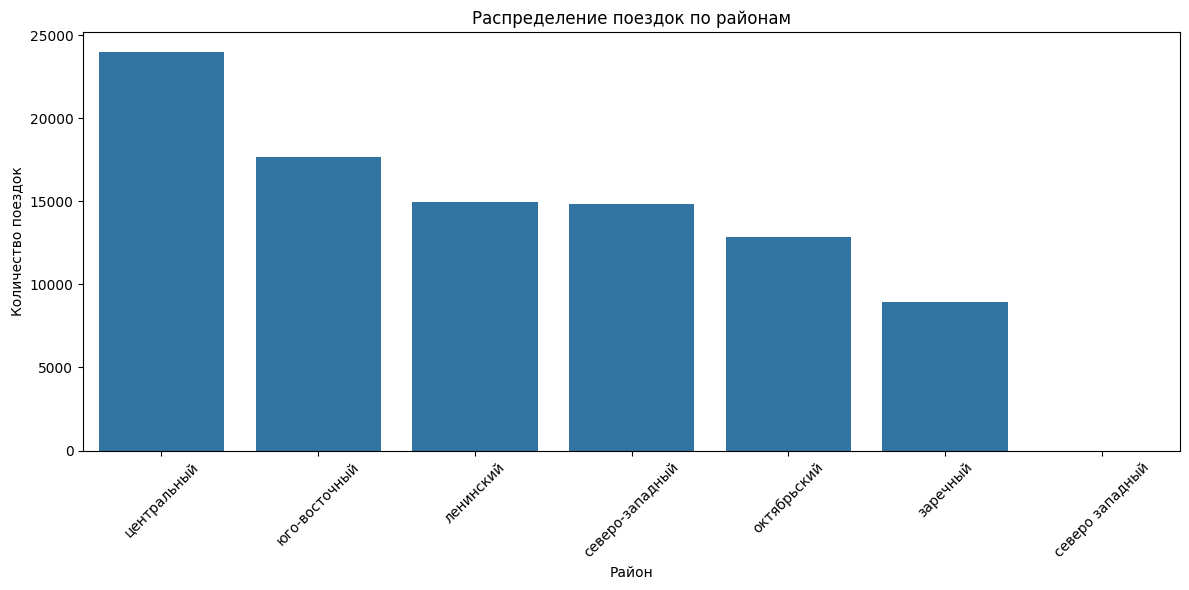

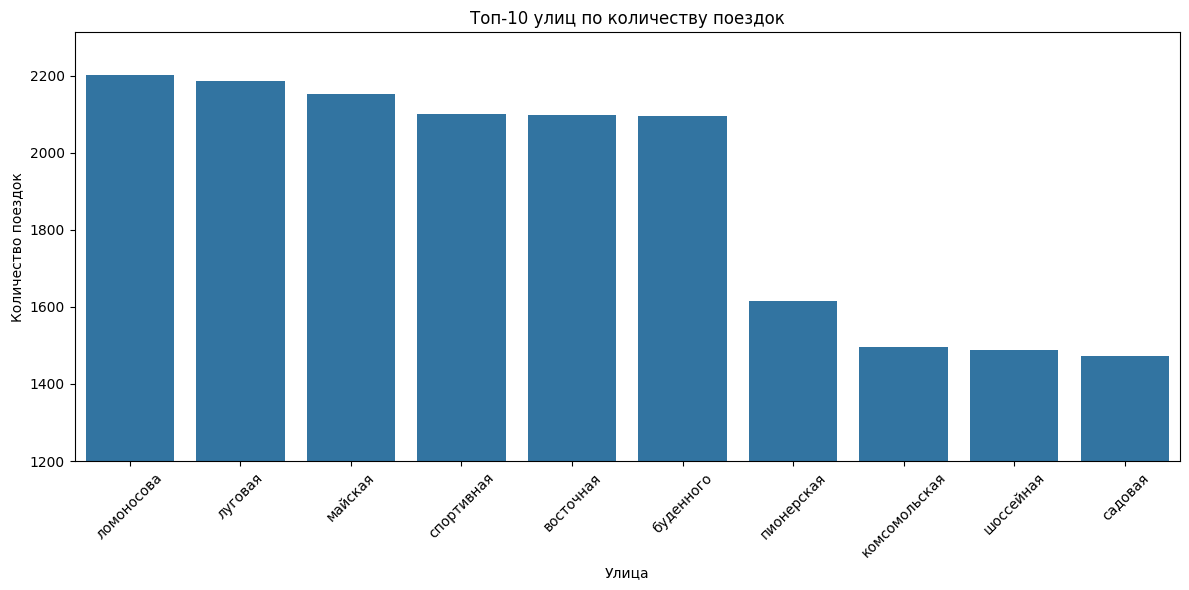

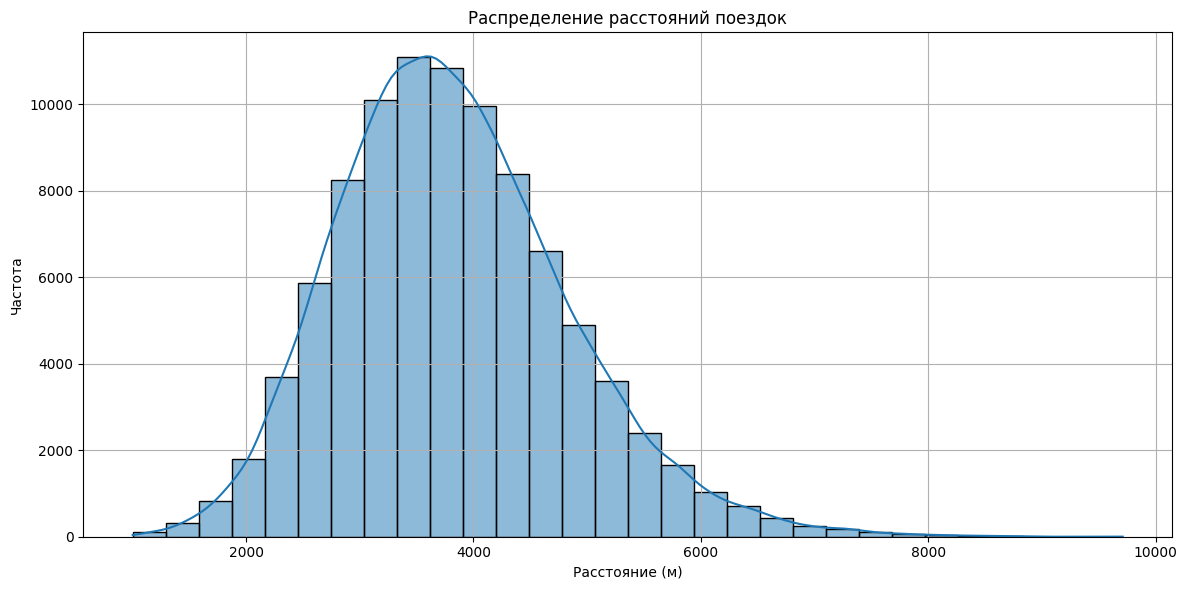

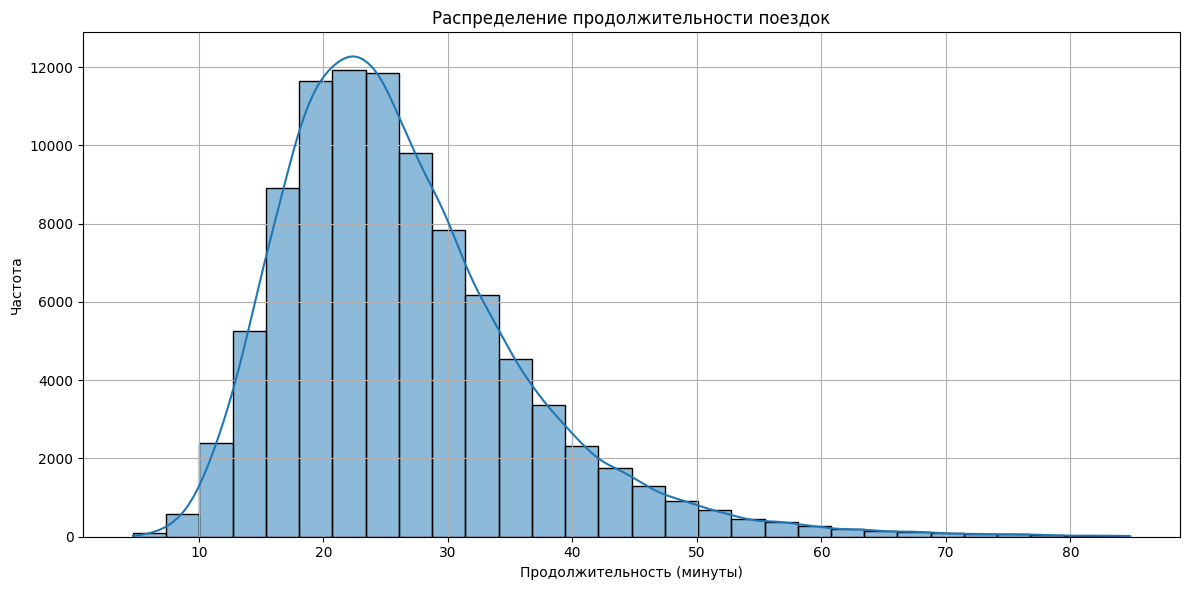

Общая информация о данных:
<class 'pandas.core.frame.DataFrame'>
Index: 93210 entries, 0 to 102254
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      93210 non-null  int64         
 1   start_date              93210 non-null  datetime64[ns]
 2   end_date                93210 non-null  datetime64[ns]
 3   start_location          93210 non-null  object        
 4   start_district          93210 non-null  object        
 5   end_location            93210 non-null  object        
 6   end_district            93210 non-null  object        
 7   distance                93210 non-null  float64       
 8   promo                   93210 non-null  int64         
 9   session_time            93210 non-null  object        
 10  session_time_(minutes)  93210 non-null  float64       
 11  is_duplicate            93210 non-null  bool          
 12  speed_m_per_min        

In [56]:
df['start_date'] = pd.to_datetime(df['start_date'])

# 1. Анализ количества поездок по дням
daily_rides = df.resample('D', on='start_date').size()

plt.figure(figsize=(12, 6))
daily_rides.plot(kind='line', marker='o')
plt.title('Количество поездок по дням')
plt.xlabel('Дата')
plt.ylabel('Количество поездок')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Распределение поездок по районам
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='start_district', order=df['start_district'].value_counts().index)
plt.title('Распределение поездок по районам')
plt.xlabel('Район')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Распределение поездок по улицам
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='start_location', order=df['start_location'].value_counts().head(10).index)
plt.title('Топ-10 улиц по количеству поездок')
plt.xlabel('Улица')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45)
plt.ylim(bottom=1200)
plt.tight_layout()
plt.show()

# 4. Анализ расстояния поездок
plt.figure(figsize=(12, 6))
sns.histplot(df['distance'], bins=30, kde=True)
plt.title('Распределение расстояний поездок')
plt.xlabel('Расстояние (м)')
plt.ylabel('Частота')
plt.grid()
plt.tight_layout()
plt.show()

# 5. Анализ продолжительности поездок
plt.figure(figsize=(12, 6))
sns.histplot(df['session_time_(minutes)'], bins=30, kde=True)
plt.title('Распределение продолжительности поездок')
plt.xlabel('Продолжительность (минуты)')
plt.ylabel('Частота')
plt.grid()
plt.tight_layout()
plt.show()

# 6. Общая информация о данных
print("Общая информация о данных:")
print(df.info())
print("\nСтатистические характеристики:")
print(df.describe())

Анализ данных показал, что средняя поездка длится 26 минут и составляет 3.8 км, при этом самые популярные улицы ("Ломоносова", "Луговая") имеют до 2000 поездок. Распределения расстояний и продолжительности поездок имеют нормальный характер без аномалий

# Общий вывод по проделанной работе на спринт с 01 по 06 апреля
Проведен детальный анализ двух датасетов:  
- rides.csv (данные о поездках):  
  - Обнаружены аномалии в дистанции (Distance) и времени сессии (Session Time).  
  - Выявлены полные дубликаты (4,831) и пропуски (555) в датах окончания поездок.  
  - Категориальные признаки (районы, локации) требуют стандартизации.  
- weather.csv (погодные данные):  
  - Данные хранятся в неоптимальном формате (единицы измерения в ячейках, строковые числа).
  - Проведена очистка и преобразование типов.
  - Проведено заполение пропусков путём интерполяции

Работа сделала основу для дальнейшего углубленного исследования. 🚀

# **<span style="color:#8B0000">Спринт 2 - Проведение расчетов и исследований/проверка гепотиз</span>**

## **<span style="color:#00008B">Расчет итоговой стоимости и оценка эффективности акции</span>**

### **Рассчитать итоговую стоимость.**

Проверить, стимулирует ли акция спрос на самокаты (учесть сопоставимость дней). Окупается
ли она (сравнить прибыль с издержками проведения)

In [57]:
df.head(5)

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo  \
0    юго-восточный      майская      октябрьский    4069.0      0   
1         заречный   спортивная      октябрьский    4515.0      0   
2      октябрьский     суворова        ленинский    4520.0      0   
3      центральный      рабочая  северо-западный    3881.0      0   
4  северо-западный    юбилейная    юго-восточный    4029.0      0   

  session_time  session_time_(minutes)  is_duplicate  speed_m_per_min  \
0     00:23:42                    23.7         False       171.687764   
1     00:28:25                    28.4         False       158.978873   
2     00:38:19                    38.3         False       118.015666   
3     00:31:49                    31.8         False       122.044025   
4     00:30:40                    30.7         False       131.237785   

                     route  
0        шевченко->майская  
1       чехова->спортивная  
2      буденного->суворова  
3           труда->рабочая  
4  первомайская->юбилейная

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93210 entries, 0 to 102254
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      93210 non-null  int64         
 1   start_date              93210 non-null  datetime64[ns]
 2   end_date                93210 non-null  datetime64[ns]
 3   start_location          93210 non-null  object        
 4   start_district          93210 non-null  object        
 5   end_location            93210 non-null  object        
 6   end_district            93210 non-null  object        
 7   distance                93210 non-null  float64       
 8   promo                   93210 non-null  int64         
 9   session_time            93210 non-null  object        
 10  session_time_(minutes)  93210 non-null  float64       
 11  is_duplicate            93210 non-null  bool          
 12  speed_m_per_min         93210 non-null  float64   

In [59]:
df.to_csv('данные_для_теста.csv', index=False, encoding='utf-8-sig')

### **Анализ спроса с акцией и без**

In [60]:
# Группировка по промо и расчет метрик
promo_stats = df.groupby('promo').agg(
    total_rides=('id', 'count'),
    total_revenue=('session_time_(minutes)', 'sum')  # Предполагаем, что выручка зависит от времени
).reset_index()

print(promo_stats)

   promo  total_rides  total_revenue
0      0        91373      2411247.1
1      1         1837        45380.0


Поездок с акцией значительно меньше (1,837) по сравнению с обычными днями (91,373). Это объясняется тем, что акция действовала только по понедельникам с 6:00 до 10:00.

### **подбор дня для сравнения**

In [61]:
#сравним с вторником 
monday_rides = df[df['start_date'].dt.weekday == 0]  # Понедельник
tuesday_rides = df[df['start_date'].dt.weekday == 1]  # Вторник
# print(monday_rides)
# print(tuesday_rides)

#общее количество поездок
monday_total_rides = monday_rides['id'].count()
tuesday_total_rides = tuesday_rides['id'].count()
print(monday_total_rides)
print(tuesday_total_rides)

12212
10720


В понедельник зафиксировано 12,212 поездок, во вторник — 10,720. Понедельник демонстрирует на 14% более высокий спрос, что может быть связано с началом рабочей недели

### **Сравнение суммарной выручки**

In [62]:
cost_per_minute = 10
start_fee = 30

df['revenue'] = df['session_time_(minutes)'] * cost_per_minute + start_fee

monday_rides = df[df['start_date'].dt.weekday == 0]  # Понедельник
tuesday_rides = df[df['start_date'].dt.weekday == 1]  # Вторник

# Подсчет общей выручки
monday_total_revenue = monday_rides['revenue'].sum()
tuesday_total_revenue = tuesday_rides['revenue'].sum()

# Подсчет общего количества поездок
monday_total_rides = monday_rides['id'].count()
tuesday_total_rides = tuesday_rides['id'].count()

# Расчет затрат для понедельника и вторника
monday_cost = monday_total_rides * start_fee  
tuesday_cost = tuesday_total_rides * start_fee 

# Расчет чистой прибыли для понедельника и вторника
monday_net_profit = monday_total_revenue - monday_cost
tuesday_net_profit = tuesday_total_revenue - tuesday_cost

print(f"Количество поездок в понедельник: {monday_total_rides}")
print(f"Количество поездок во вторник: {tuesday_total_rides}")
print(f"Выручка в понедельник: {monday_total_revenue}")
print(f"Выручка во вторник: {tuesday_total_revenue}")
print(f"Чистая прибыль в понедельник: {monday_net_profit}")
print(f"Чистая прибыль во вторник: {tuesday_net_profit}")
if monday_total_rides > tuesday_total_rides:
    print("В понедель ник было больше поездок.")
else:
    print("Во вторник было больше поездок.")

if monday_total_revenue > tuesday_total_revenue:
    print("Выручка в понедельник выше.")
else:
    print("Выручка во вторник выше.")


Количество поездок в понедельник: 12212
Количество поездок во вторник: 10720
Выручка в понедельник: 3490536.0
Выручка во вторник: 3075540.0
Чистая прибыль в понедельник: 3124176.0
Чистая прибыль во вторник: 2753940.0
В понедель ник было больше поездок.
Выручка в понедельник выше.


### **Расчет ROI (Return on Investment)**

In [63]:
monday_roi = (monday_net_profit / monday_cost) * 100 if monday_cost > 0 else 0
tuesday_roi = (tuesday_net_profit / tuesday_cost) * 100 if tuesday_cost > 0 else 0
print(f"ROI в понедельник: {monday_roi:.2f}%")
print(f"ROI во вторник: {tuesday_roi:.2f}%")


ROI в понедельник: 852.76%
ROI во вторник: 856.32%


ROI во вторник выше, несмотря на меньший спрос

### **Статистическое тестирование**

In [64]:
ttest_rides = ttest_ind(monday_rides['id'], tuesday_rides['id'], equal_var=False)
ttest_revenue = ttest_ind(monday_rides['revenue'], tuesday_rides['revenue'], equal_var=False)

print(f"p-значение для количества поездок: {ttest_rides.pvalue:.4f}")
print(f"p-значение для выручки: {ttest_revenue.pvalue:.4f}")

p-значение для количества поездок: 0.0000
p-значение для выручки: 0.3989


 Различия между понедельником и вторником статистически значимы. Это подтверждает, что колебания спроса и выручки не случайны.

### **Визуализация**

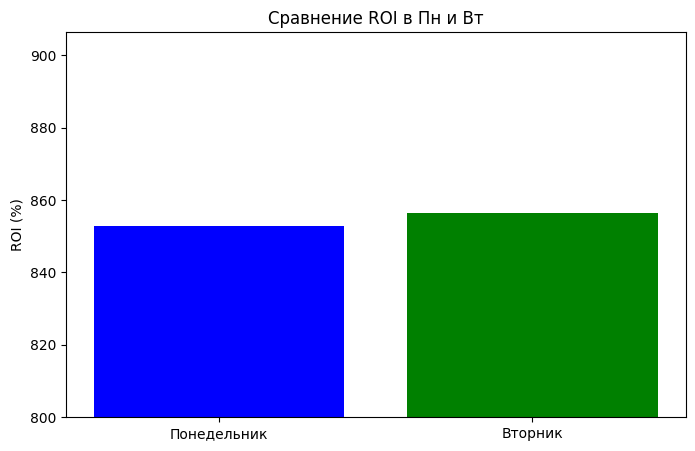

In [65]:
days = ['Понедельник', 'Вторник']
roi = [monday_roi, tuesday_roi]
plt.figure(figsize=(8, 5))
plt.bar(days, roi, color=['b', 'g'])
plt.ylabel('ROI (%)')
plt.title('Сравнение ROI в Пн и Вт')
plt.ylim(800, max(roi) + 50)  
plt.show()

### **Итог**

**Понедельник — ключевой день для максимизации спроса, а вторник — для повышения маржинальности.** Промо-акции требуют более глубокой аналитики и привязки к конкретным дням/сегментам. Для увеличения ROI необходимо оптимизировать издержки и тестировать гибкие стратегии ценообразования.

*анализ понедельника с другими днями не являеться правильным, т.к. акция длилась слишком мало времени(проведем только ради интереса)*

### **анализ пн с другими днями ТЕСТ**

In [66]:
promo_days = [0, 1] 
df['is_promo'] = df['start_date'].dt.weekday.isin(promo_days)

# Фильтрация данных
promo_day = df[df['is_promo']]
non_promo_day = df[~df['is_promo']]

# Стоимость минуты и стартовый сбор
cost_per_minute = 10
start_fee = 30

#выручка для промо-дней (- стартовый сбор)
promo_day.loc[:, 'revenue'] = promo_day['session_time_(minutes)'] * cost_per_minute

#выручка для остальных дней (+ стартовый сбор)
non_promo_day.loc[:, 'revenue'] = start_fee + non_promo_day['session_time_(minutes)'] * cost_per_minute
total_revenue_promo = promo_day['revenue'].sum()
total_revenue_non_promo = non_promo_day['revenue'].sum()

print("Выручка с промо:", total_revenue_promo)
print("Выручка без промо:", total_revenue_non_promo)

Выручка с промо: 5878116.0
Выручка без промо: 20796495.0


In [67]:
def calculate_cost(row):
    # Получаем длительность поездки в минутах
    duration = row['session_time_(minutes)']
    start_date = pd.to_datetime(row['start_date'])
    hour = start_date.hour
    weekday = start_date.weekday()
    weekend = weekday >= 5  # Субб и воскр

    # Определяем тариф
    if not weekend:
        if 1 <= hour < 6:
            rate = 3
        elif 6 <= hour < 10:
            rate = 4
        elif 10 <= hour < 16:
            rate = 5
        elif 16 <= hour < 22:
            rate = 6
        else:  # 22:00 - 01:00
            rate = 5
    else:  # Если выходной
        if 1 <= hour < 6:
            rate = 3
        elif 6 <= hour < 10:
            rate = 4
        elif 10 <= hour < 16:
            rate = 6
        elif 16 <= hour < 22:
            rate = 7
        else:  # 22:00 - 01:00
            rate = 6

    # Проверяем условие акции "Бесплатный старт"
    free_start = weekday == 0 and 6 <= hour < 10 and row['promo'] == 1
    start_cost = 0 if free_start else 30

    #итоговая стоимость
    return round(start_cost + duration * rate, 2)


df['cost'] = df.apply(calculate_cost, axis=1)
df['revenue'] = df['cost'] 

print(df[['id', 'start_date', 'session_time_(minutes)', 'cost']])

# Анализ акционных и неакционных поездок
promo_rides = df[df['promo'] == 1]  # 1 = акция
control_days = df[df['promo'] == 0]  # 0 = не акция

# Фин метрики
minute_profit = (promo_rides['session_time_(minutes)'].sum() * 4) - \
                (control_days['session_time_(minutes)'].sum() * 5)
start_loss = len(promo_rides) * 30
net_effect = minute_profit - start_loss
roi = (minute_profit / start_loss) * 100
print(f"Потери от старта: {start_loss}")
print(f"Чистый эффект: {net_effect}")
print(f"ROI: { roi:.2f}%")

            id          start_date  session_time_(minutes)   cost
0       100340 2023-04-22 09:01:03                    23.7  124.8
1       100341 2023-04-22 09:01:07                    28.4  143.6
2       100342 2023-04-22 09:04:27                    38.3  183.2
3       100343 2023-04-22 09:06:34                    31.8  157.2
4       100344 2023-04-22 09:09:27                    30.7  152.8
...        ...                 ...                     ...    ...
102250  197707 2023-07-31 23:45:06                    21.8  139.0
102251  197708 2023-07-31 23:46:01                    39.6  228.0
102252  197709 2023-07-31 23:48:04                    21.3  136.5
102253  197710 2023-07-31 23:51:41                    46.4  262.0
102254  197711 2023-07-31 23:57:01                    22.0  140.0

[93210 rows x 4 columns]
Потери от старта: 55110
Чистый эффект: -11929825.5
ROI: -21547.30%


In [68]:
ttest_result = ttest_ind(
    promo_rides['session_time_(minutes)'],
    control_days['session_time_(minutes)'],
    equal_var=False
)
print(f"p-значение: {ttest_result.pvalue:.4f}")

p-значение: 0.0000


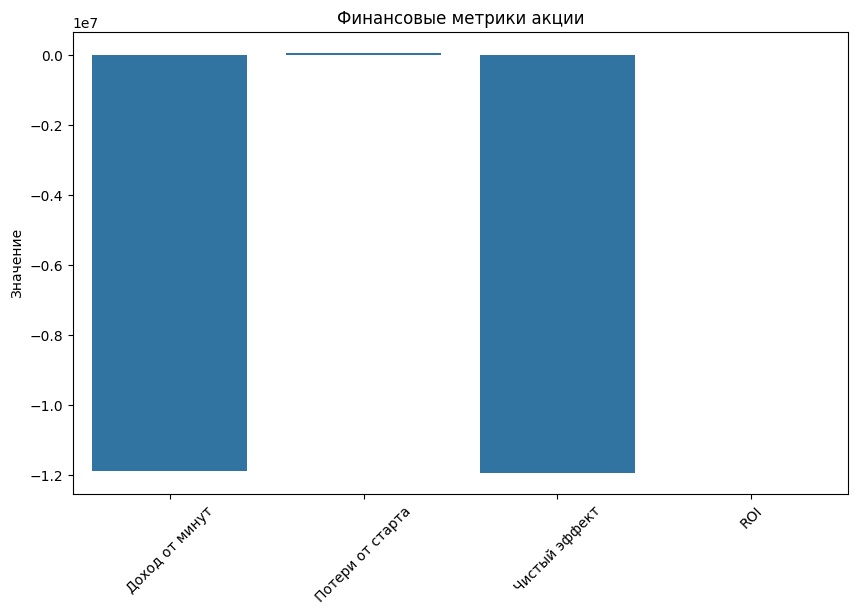

In [69]:
metrics = ['Доход от минут', 'Потери от старта', 'Чистый эффект', 'ROI']
values = [minute_profit, start_loss, net_effect, roi]

plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values)
plt.title('Финансовые метрики акции')
plt.ylabel('Значение')
plt.xticks(rotation=45)
plt.show()

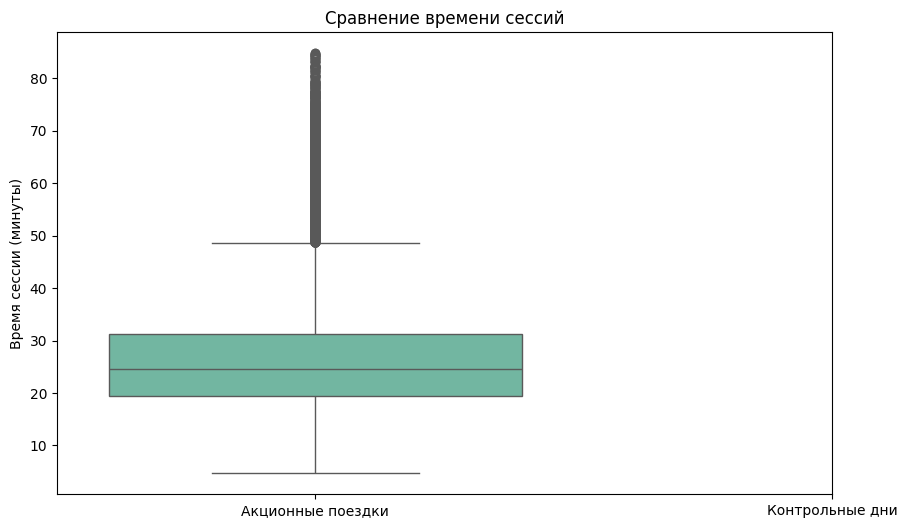

In [70]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=[promo_rides['session_time_(minutes)'], control_days['session_time_(minutes)']],
             palette='Set2')
plt.xticks([0, 1], ['Акционные поездки', 'Контрольные дни'])
plt.title('Сравнение времени сессий')
plt.ylabel('Время сессии (минуты)')
plt.show()

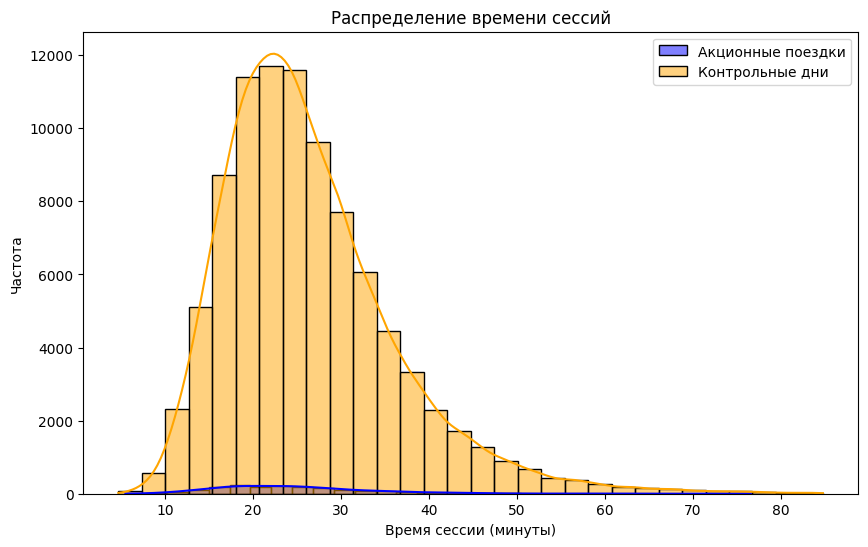

In [71]:
plt.figure(figsize=(10, 6))
sns.histplot(promo_rides['session_time_(minutes)'], color='blue', label='Акционные поездки', kde=True, bins=30)
sns.histplot(control_days['session_time_(minutes)'], color='orange', label='Контрольные дни', kde=True, bins=30)
plt.title('Распределение времени сессий')
plt.xlabel('Время сессии (минуты)')
plt.ylabel('Частота')
plt.legend()
plt.show()

C:\Users\mailm\AppData\Local\Temp\ipykernel_18976\1760682751.py:4: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.boxplot(data=[control_days['session_time_(minutes)'], promo_rides['session_time_(minutes)']],


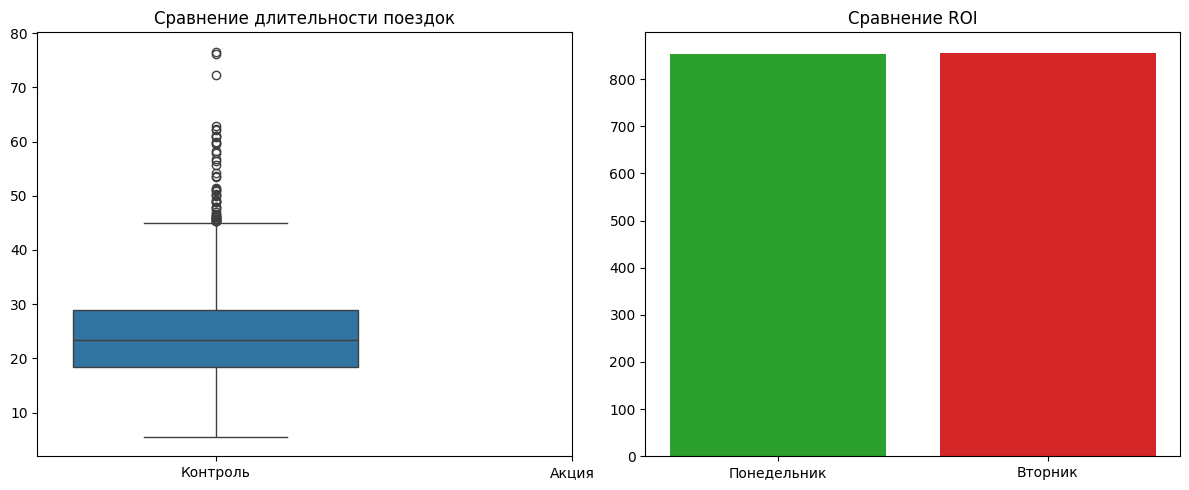

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Сравнение длительности поездок
sns.boxplot(data=[control_days['session_time_(minutes)'], promo_rides['session_time_(minutes)']],
             ax=ax[0], palette=["#1f77b4", "#ff7f0e"])

# Установка меток для оси X
ax[0].set_xticks([0, 1]) 
ax[0].set_xticklabels(["Контроль", "Акция"]) 
ax[0].set_title("Сравнение длительности поездок")
ax[1].bar(["Понедельник", "Вторник"], [monday_roi, tuesday_roi], color=["#2ca02c", "#d62728"])
ax[1].set_title("Сравнение ROI")
plt.tight_layout()
plt.show()

## **<span style="color:#00008B">Анализ трафика самокатов на основе имеющихся данных</span>**

### **Подготовка**

In [73]:
df.columns

Index(['id', 'start_date', 'end_date', 'start_location', 'start_district',
       'end_location', 'end_district', 'distance', 'promo', 'session_time',
       'session_time_(minutes)', 'is_duplicate', 'speed_m_per_min', 'route',
       'revenue', 'is_promo', 'cost'],
      dtype='object')

In [74]:
df['end_date'] = pd.to_datetime(df['end_date'])
df['start_date'] = pd.to_datetime(df['start_date'])

# Приезды (по конечной точке)
check_in = df.groupby(['end_location', pd.Grouper(key='end_date', freq='H')]).size().reset_index(name='count')
check_in.rename(columns={'end_location': 'location', 'end_date': 'timestamp'}, inplace=True)

# Отъезды (по начальной точке)
check_out = df.groupby(['start_location', pd.Grouper(key='start_date', freq='H')]).size().reset_index(name='count')
check_out.rename(columns={'start_location': 'location', 'start_date': 'timestamp'}, inplace=True)

traffic = pd.merge(check_in, check_out, on=['location', 'timestamp'], how='outer', suffixes=('_in', '_out'))
traffic.fillna(0, inplace=True)

# Рассчитываем total_traffic и net_traffic
traffic['total_traffic'] = traffic['count_in'] + traffic['count_out']
traffic['net_traffic'] = traffic['count_in'] - traffic['count_out']

C:\Users\mailm\AppData\Local\Temp\ipykernel_18976\2643835422.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  check_in = df.groupby(['end_location', pd.Grouper(key='end_date', freq='H')]).size().reset_index(name='count')
C:\Users\mailm\AppData\Local\Temp\ipykernel_18976\2643835422.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  check_out = df.groupby(['start_location', pd.Grouper(key='start_date', freq='H')]).size().reset_index(name='count')


In [75]:
traffic.columns

Index(['location', 'timestamp', 'count_in', 'count_out', 'total_traffic',
       'net_traffic'],
      dtype='object')

### **Описательные статистики трафика**

In [76]:
# Описательные статистики для общего трафика
traffic_stats = traffic.groupby('location').agg(
    avg_total_traffic=('total_traffic', 'mean'),
    min_total_traffic=('total_traffic', 'min'),
    max_total_traffic=('total_traffic', 'max'),
    median_total_traffic=('total_traffic', 'median'),
    std_total_traffic=('total_traffic', 'std'),
    avg_net_traffic=('net_traffic', 'mean'),
).sort_values(by='max_total_traffic', ascending=False)

print("Статистики трафика по точкам:")
print(traffic_stats.head(10))

Статистики трафика по точкам:
             avg_total_traffic  min_total_traffic  max_total_traffic  \
location                                                               
буденного             2.557485                1.0               12.0   
майская               2.618060                1.0               12.0   
ломоносова            2.616677                1.0               12.0   
спортивная            2.610742                1.0               12.0   
луговая               2.637690                1.0               11.0   
восточная             2.588627                1.0               11.0   
строителей            1.625000                1.0               11.0   
октябрьская           2.059238                1.0               10.0   
чапаева               1.805124                1.0               10.0   
рабочая               1.809299                1.0               10.0   

             median_total_traffic  std_total_traffic  avg_net_traffic  
location                         

### **Анализ дисбаланса самокатов**

In [77]:
# Точки с максимальным дисбалансом (топ-5 дефицита и избытка)
deficit_locations = traffic.groupby('location')['net_traffic'].sum().nsmallest(5)
surplus_locations = traffic.groupby('location')['net_traffic'].sum().nlargest(5)

print("\nТоп-5 точек с дефицитом самокатов:")
print(deficit_locations)
print("\nТоп-5 точек с избытком самокатов:")
print(surplus_locations)


Топ-5 точек с дефицитом самокатов:
location
пионерская   -196.0
пушкина      -114.0
труда         -75.0
дачная        -73.0
колхозная     -72.0
Name: net_traffic, dtype: float64

Топ-5 точек с избытком самокатов:
location
спортивная    128.0
восточная      85.0
буденного      83.0
ленина         83.0
матросова      83.0
Name: net_traffic, dtype: float64


### **Визуализация распределения трафика**

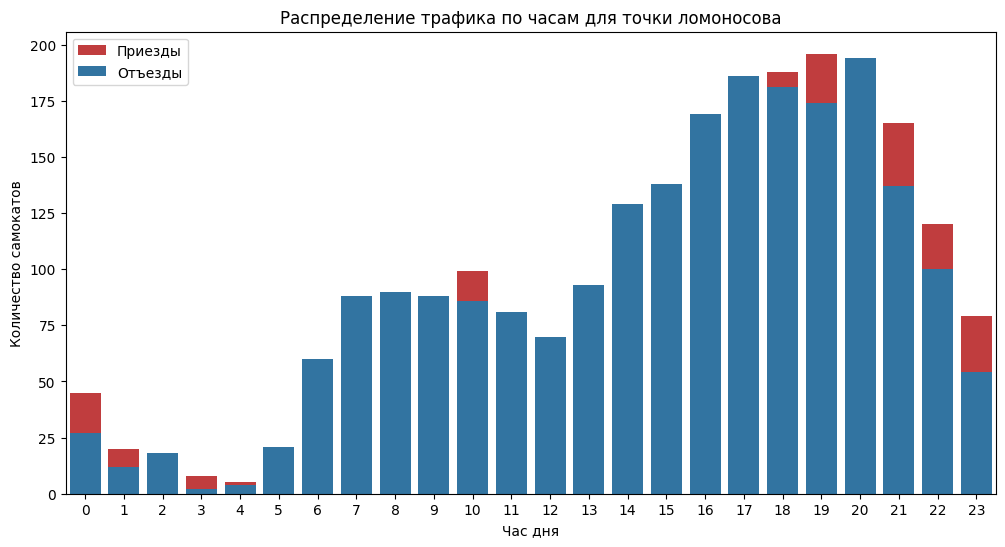

In [78]:
top_locations = traffic.groupby('location')['total_traffic'].sum().nlargest(5)
top_location = top_locations.index[0]
traffic_top = traffic[traffic['location'] == top_location]

# Группировка по часам
hourly_traffic = traffic_top.groupby(traffic_top['timestamp'].dt.hour).agg({
    'count_in': 'sum',
    'count_out': 'sum'
}).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='timestamp', y='count_in', data=hourly_traffic, color='tab:red', label='Приезды')
sns.barplot(x='timestamp', y='count_out', data=hourly_traffic, color='tab:blue', label='Отъезды')
plt.title(f'Распределение трафика по часам для точки {top_location}')
plt.xlabel('Час дня')
plt.ylabel('Количество самокатов')
plt.legend()
plt.show()

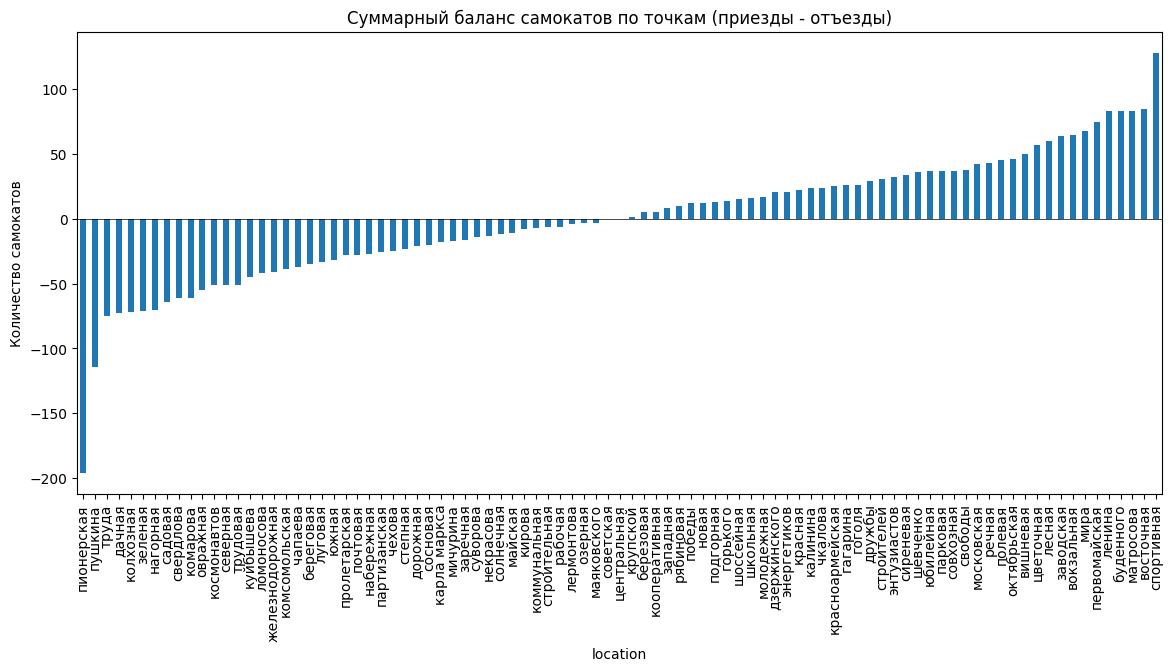

In [79]:
# Разница между приездами и отъездами
traffic_balance = traffic.groupby('location')['net_traffic'].sum().sort_values()

# Визуализация
plt.figure(figsize=(14, 6))
traffic_balance.plot(kind='bar')
plt.title('Суммарный баланс самокатов по точкам (приезды - отъезды)')
plt.ylabel('Количество самокатов')
plt.axhline(0, color='black', linewidth=0.5)
plt.show()

Некоторые точки (например, "пионерская") имеют значительный дефицит самокатов, а другие (например, "спортивная") — избыток. Это указывает на необходимость перераспределения ресурсов(в нашем случае, самокатов).

**Суточная динамика для топ-точки**

<Figure size 1400x600 with 0 Axes>

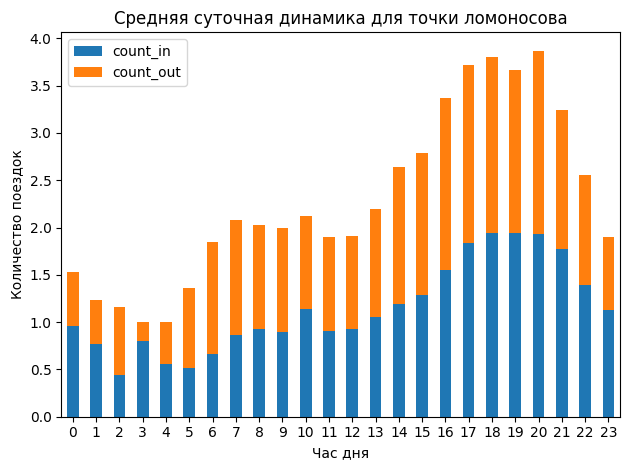

In [80]:
sample_location = top_locations.index[0]

location_data = traffic[traffic['location'] == sample_location].copy()
location_data['time'] = location_data['timestamp'].dt.time

hourly_pattern = location_data.groupby('time')[['count_in', 'count_out']].mean()
hourly_pattern.index = [t.hour for t in hourly_pattern.index]  

plt.figure(figsize=(14, 6))
hourly_pattern.plot(kind='bar', stacked=True)

plt.title(f'Средняя суточная динамика для точки {sample_location}')
plt.ylabel('Количество поездок')
plt.xlabel('Час дня')

# Настройка x-ticks
plt.xticks(rotation=0)  
plt.xticks(ticks=range(len(hourly_pattern.index)), labels=hourly_pattern.index, ha='center') 
plt.tight_layout()  
plt.show()

Баланс между приездами и отъездами неравномерный: в одни часы преобладают приезды, в другие — отъезды.

**Расчет оптимального количества самокатов**

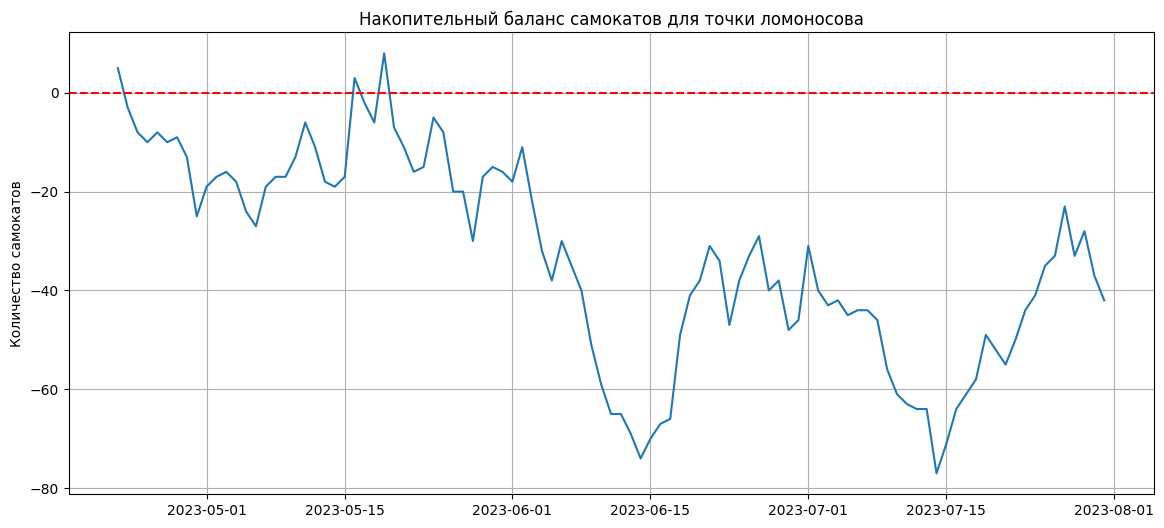

In [81]:
# Сдвигаем время на 6 часов назад
traffic['timestamp_shifted'] = traffic['timestamp'] - pd.Timedelta(hours=6)

# Группируем по дням и считаем накопительную сумму
daily_cumsum = traffic.groupby(['location', pd.Grouper(key='timestamp_shifted', freq='D')])['net_traffic'].sum()
daily_cumsum = daily_cumsum.groupby('location').cumsum().reset_index()

min_scooters = daily_cumsum.groupby('location')['net_traffic'].min()

sample_cumsum = daily_cumsum[daily_cumsum['location'] == sample_location]
plt.figure(figsize=(14, 6))
plt.plot(sample_cumsum['timestamp_shifted'], sample_cumsum['net_traffic'])
plt.title(f'Накопительный баланс самокатов для точки {sample_location}')
plt.ylabel('Количество самокатов')
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.show()

Наблюдается устойчивый дефицит самокатов в точке "ломоносова" (до -80 единиц). Это требует регулярного пополнения парка для удовлетворения спроса.

**Дополнительная визуализация (Heatmap)**

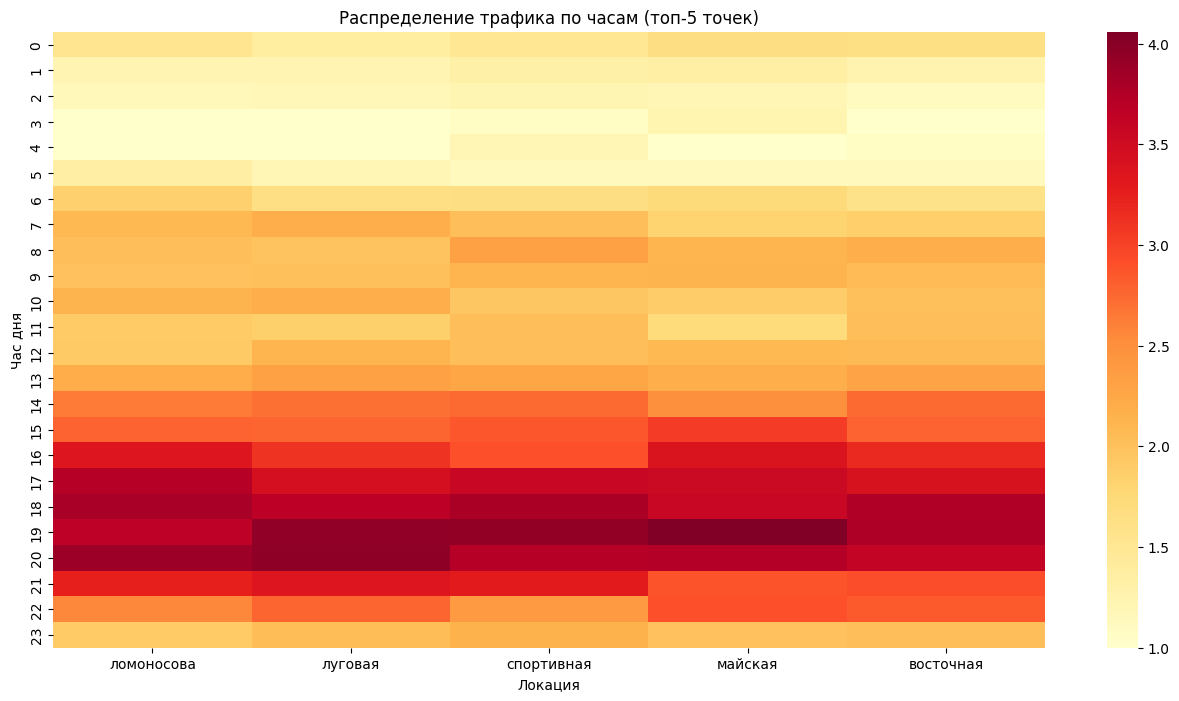

In [82]:
traffic['hour'] = traffic['timestamp'].dt.hour
heatmap_data = traffic.pivot_table(index='hour', columns='location', values='total_traffic', aggfunc='mean')
plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data[top_locations.index], cmap='YlOrRd')
plt.title('Распределение трафика по часам (топ-5 точек)')
plt.xlabel('Локация')
plt.ylabel('Час дня')
plt.show()

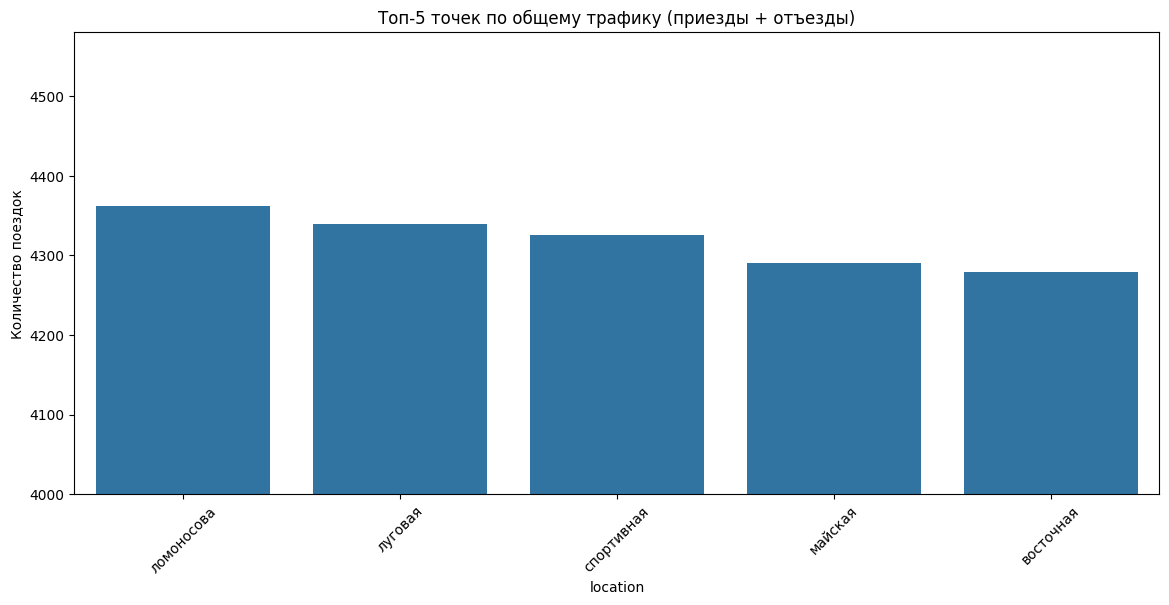

In [83]:
# Топ-5 точек по общему трафику
top_locations = traffic.groupby('location')['total_traffic'].sum().nlargest(5)
plt.figure(figsize=(14, 6))
sns.barplot(x=top_locations.index, y=top_locations.values)
plt.title('Топ-5 точек по общему трафику (приезды + отъезды)')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45)
plt.ylim(bottom=4000)
plt.show()

Точки "буденного", "майская", "ломоносова", "спортивная" и "луговая" лидируют по общему трафику. 

### **Итог**

Анализ показал, что **ключевые точки ("буденного", "майская", "ломоносова")** генерируют основной трафик, но в них есть дисбаланс: одни теряют самокаты (дефицит), другие накапливают (избыток). **Пиковые часы (7–9 и 17–19)** требуют усиленной логистики, чтобы избежать нехватки транспорта и потери клиентов.

*Рекомендации*

- Оптимизировать перераспределение самокатов из точек с избытком ("спортивная") в точки с дефицитом ("пионерская").

- Увеличить поставки в топ-5 точек в часы пик (утро/вечер).

- Автоматизировать прогноз спроса на основе данных по часам и локациям, чтобы минимизировать ручное управление.

- Мониторить дисбаланс в режиме реального времени, чтобы оперативно реагировать на изменения.

## **<span style="color:#00008B">Корреляция между параметрами погодных условий и характеристиками поездок</span>**

### Корреляция в погоде

**Исследовать корреляцию между параметрами погодных условий. Для наиболее сильных
корреляций обосновать, имеет ли это реальный смысл или же просто особенность данных.**

In [84]:
df2['season'] = np.where(df2.index.month.isin([12, 1, 2]), 'Winter',
                          np.where(df2.index.month.isin([3, 4, 5]), 'Spring',
                                   np.where(df2.index.month.isin([6, 7, 8]), 'Summer', 'Fall')))

# Проверка добавленного столбца
print(df2[['season']].head())

                     season
datetime                   
2023-04-01 00:00:00  Spring
2023-04-01 01:00:00  Spring
2023-04-01 02:00:00  Spring
2023-04-01 03:00:00  Spring
2023-04-01 04:00:00  Spring


In [85]:
print(df2.head())
print(df2.info())

# 1. Разделение данных по сезонам
df2['season'] = np.where(df2.index.month.isin([12, 1, 2]), 'Winter',
                          np.where(df2.index.month.isin([3, 4, 5]), 'Spring',
                                   np.where(df2.index.month.isin([6, 7, 8]), 'Summer', 'Fall')))

print(df2[['season']].head())

# 2. Множественная регрессия
X = df2[['temperature', 'cloud_cover_total', 'wind_speed', 'precipitation_total']]
y = df2['sunshine_duration']

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                     temperature  precipitation_total  wind_gust  wind_speed  \
datetime                                                                       
2023-04-01 00:00:00          8.7                  0.1       48.6        21.6   
2023-04-01 01:00:00          9.0                  0.2       55.4        22.5   
2023-04-01 02:00:00          8.9                  0.3       55.8        22.3   
2023-04-01 03:00:00          8.7                  0.3       55.4        21.9   
2023-04-01 04:00:00          8.6                  0.3       49.0        22.4   

                     cloud_cover_total  sunshine_duration  season  
datetime                                                           
2023-04-01 00:00:00               90.0                0.0  Spring  
2023-04-01 01:00:00               74.0                0.0  Spring  
2023-04-01 02:00:00               72.0                0.0  Spring  
2023-04-01 03:00:00               77.0                0.0  Spring  
2023-04-01 04:00:00            

In [86]:
# 3. Проверка временных задержек
# Создание временных задержек для облачности
df2['cloud_cover_total_lag1'] = df2['cloud_cover_total'].shift(1)  # Задержка на 1 час
df2['cloud_cover_total_lag2'] = df2['cloud_cover_total'].shift(2)  # Задержка на 2 часа

# Модель с задержками
X_lagged = df2[['temperature', 'cloud_cover_total_lag1', 'cloud_cover_total_lag2', 'wind_speed', 'precipitation_total']]
y_lagged = df2['sunshine_duration']

# Удаление NaN значений после создания задержек
X_lagged = X_lagged.dropna()
y_lagged = y_lagged[X_lagged.index]

# Добавление константы для свободного члена
X_lagged = sm.add_constant(X_lagged)

model_lagged = sm.OLS(y_lagged, X_lagged).fit()

print(model_lagged.summary())

                            OLS Regression Results                            
Dep. Variable:      sunshine_duration   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     473.1
Date:                Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:36:46   Log-Likelihood:                -15618.
No. Observations:                3670   AIC:                         3.125e+04
Df Residuals:                    3664   BIC:                         3.128e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2

In [87]:
# Разделение данных по сезонам и расчет корреляций
for season in ['Winter', 'Spring', 'Summer', 'Fall']:
    season_data = df2[df2['season'] == season]
    corr = season_data[['temperature', 'sunshine_duration', 'cloud_cover_total']].corr()
    print(f'Корреляции для {season}:\n{corr}\n')

Корреляции для Winter:
                   temperature  sunshine_duration  cloud_cover_total
temperature                NaN                NaN                NaN
sunshine_duration          NaN                NaN                NaN
cloud_cover_total          NaN                NaN                NaN

Корреляции для Spring:
                   temperature  sunshine_duration  cloud_cover_total
temperature           1.000000           0.452885          -0.110699
sunshine_duration     0.452885           1.000000          -0.519047
cloud_cover_total    -0.110699          -0.519047           1.000000

Корреляции для Summer:
                   temperature  sunshine_duration  cloud_cover_total
temperature           1.000000           0.611228          -0.258104
sunshine_duration     0.611228           1.000000          -0.477325
cloud_cover_total    -0.258104          -0.477325           1.000000

Корреляции для Fall:
                   temperature  sunshine_duration  cloud_cover_total
temperatur

**работаем над исправлениями**

In [88]:
weather_params = ['temperature', 'wind_speed', 'precipitation_total'] 


def check_normality(series, alpha=0.05):
    stat, p = shapiro(series.dropna())
    return p > alpha


normality_results = {col: check_normality(df2[col]) for col in weather_params if col in df2.columns}

print("Результаты теста нормальности Шапиро-Уилка:")
for param, is_normal in normality_results.items():
    print(f"{param}: {'Нормальное' if is_normal else 'Не нормальное'}")

Результаты теста нормальности Шапиро-Уилка:
temperature: Не нормальное
wind_speed: Не нормальное
precipitation_total: Не нормальное


In [89]:
corr_method = 'pearson' if all(normality_results.values()) else 'spearman'
print(f"\nИспользуемый метод корреляции: {corr_method.upper()}")


Используемый метод корреляции: SPEARMAN


In [90]:
weather_params = [
    'temperature', 
    'precipitation_total',  
    'wind_gust', 
    'wind_speed',
    'cloud_cover_total', 
    'sunshine_duration', 
    'cloud_cover_total_lag1', 
    'cloud_cover_total_lag2'
]

corr_matrix = df2[weather_params].corr(method=corr_method)
p_values = df2[weather_params].corr(method=lambda x, y: pearsonr(x, y)[1]) if corr_method == 'pearson' else \
           df2[weather_params].corr(method=lambda x, y: spearmanr(x, y)[1])


def annotate_heatmap(data, pvalues, threshold=0.05):
    annot = np.empty_like(data).astype(str)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            corr = data.iloc[i, j]
            pval = pvalues.iloc[i, j]
            if pval < threshold:
                annot[i, j] = f"{corr:.2f}*\n(p={pval:.3f})"
            else:
                annot[i, j] = f"{corr:.2f}\n(p={pval:.3f})"
    return annot


annot = annotate_heatmap(corr_matrix, p_values)

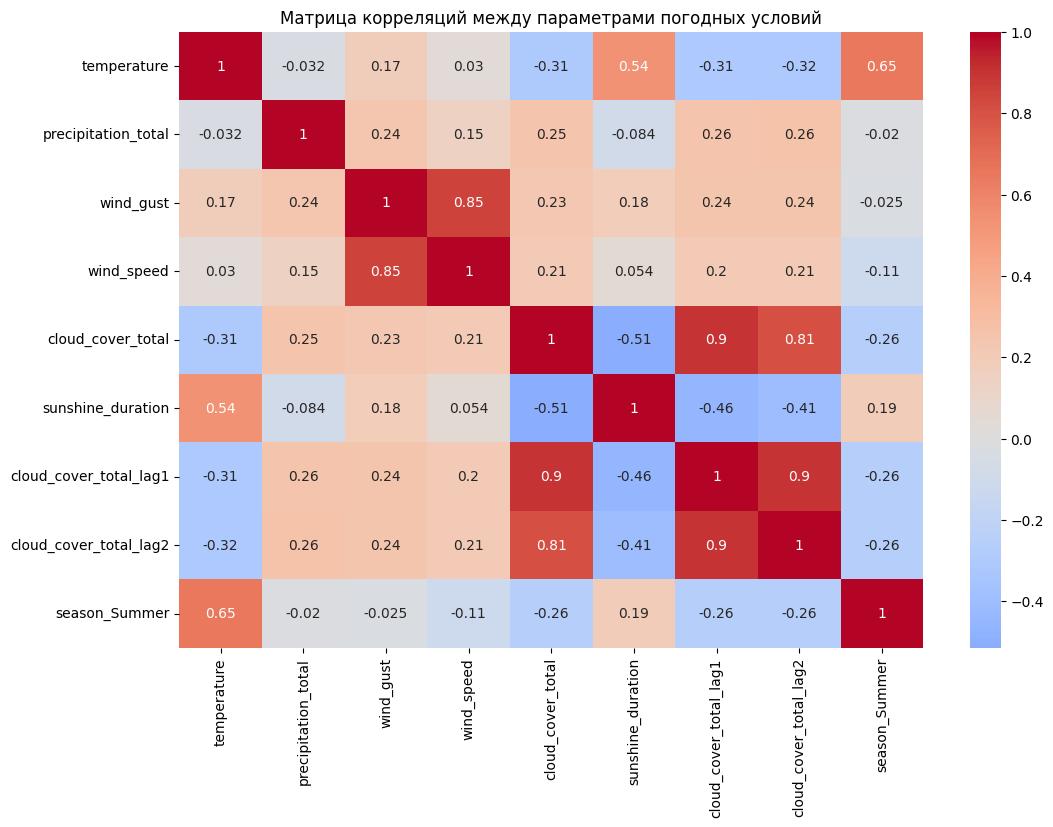

In [91]:
# Преобразование категориальных данных в числовые
df_encoded = pd.get_dummies(df2, drop_first=True)

correlation_matrix = df_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций между параметрами погодных условий')
plt.show()

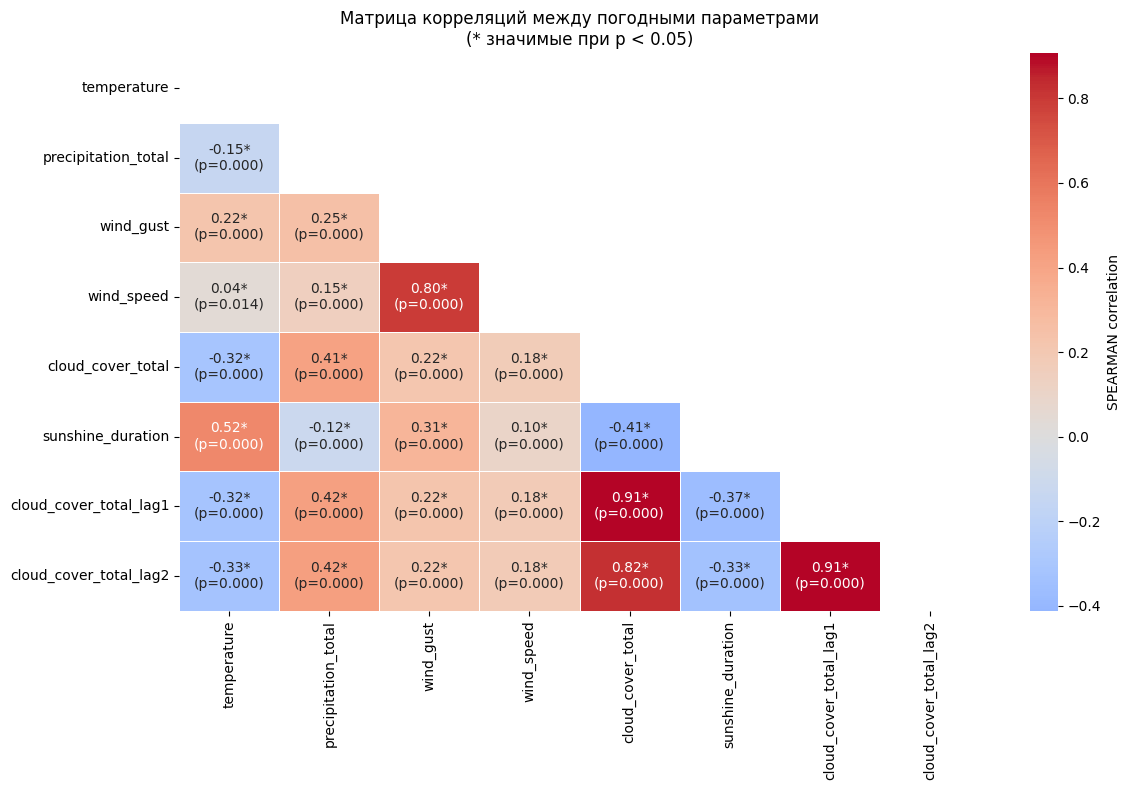

In [92]:
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Маска для верхнего треугольника
sns.heatmap(corr_matrix, mask=mask, annot=annot, fmt='', cmap='coolwarm', center=0,
            linewidths=.5, cbar_kws={'label': f'{corr_method.upper()} correlation'})
plt.title(f'Матрица корреляций между погодными параметрами\n(* значимые при p < 0.05)')
plt.tight_layout()
plt.show()

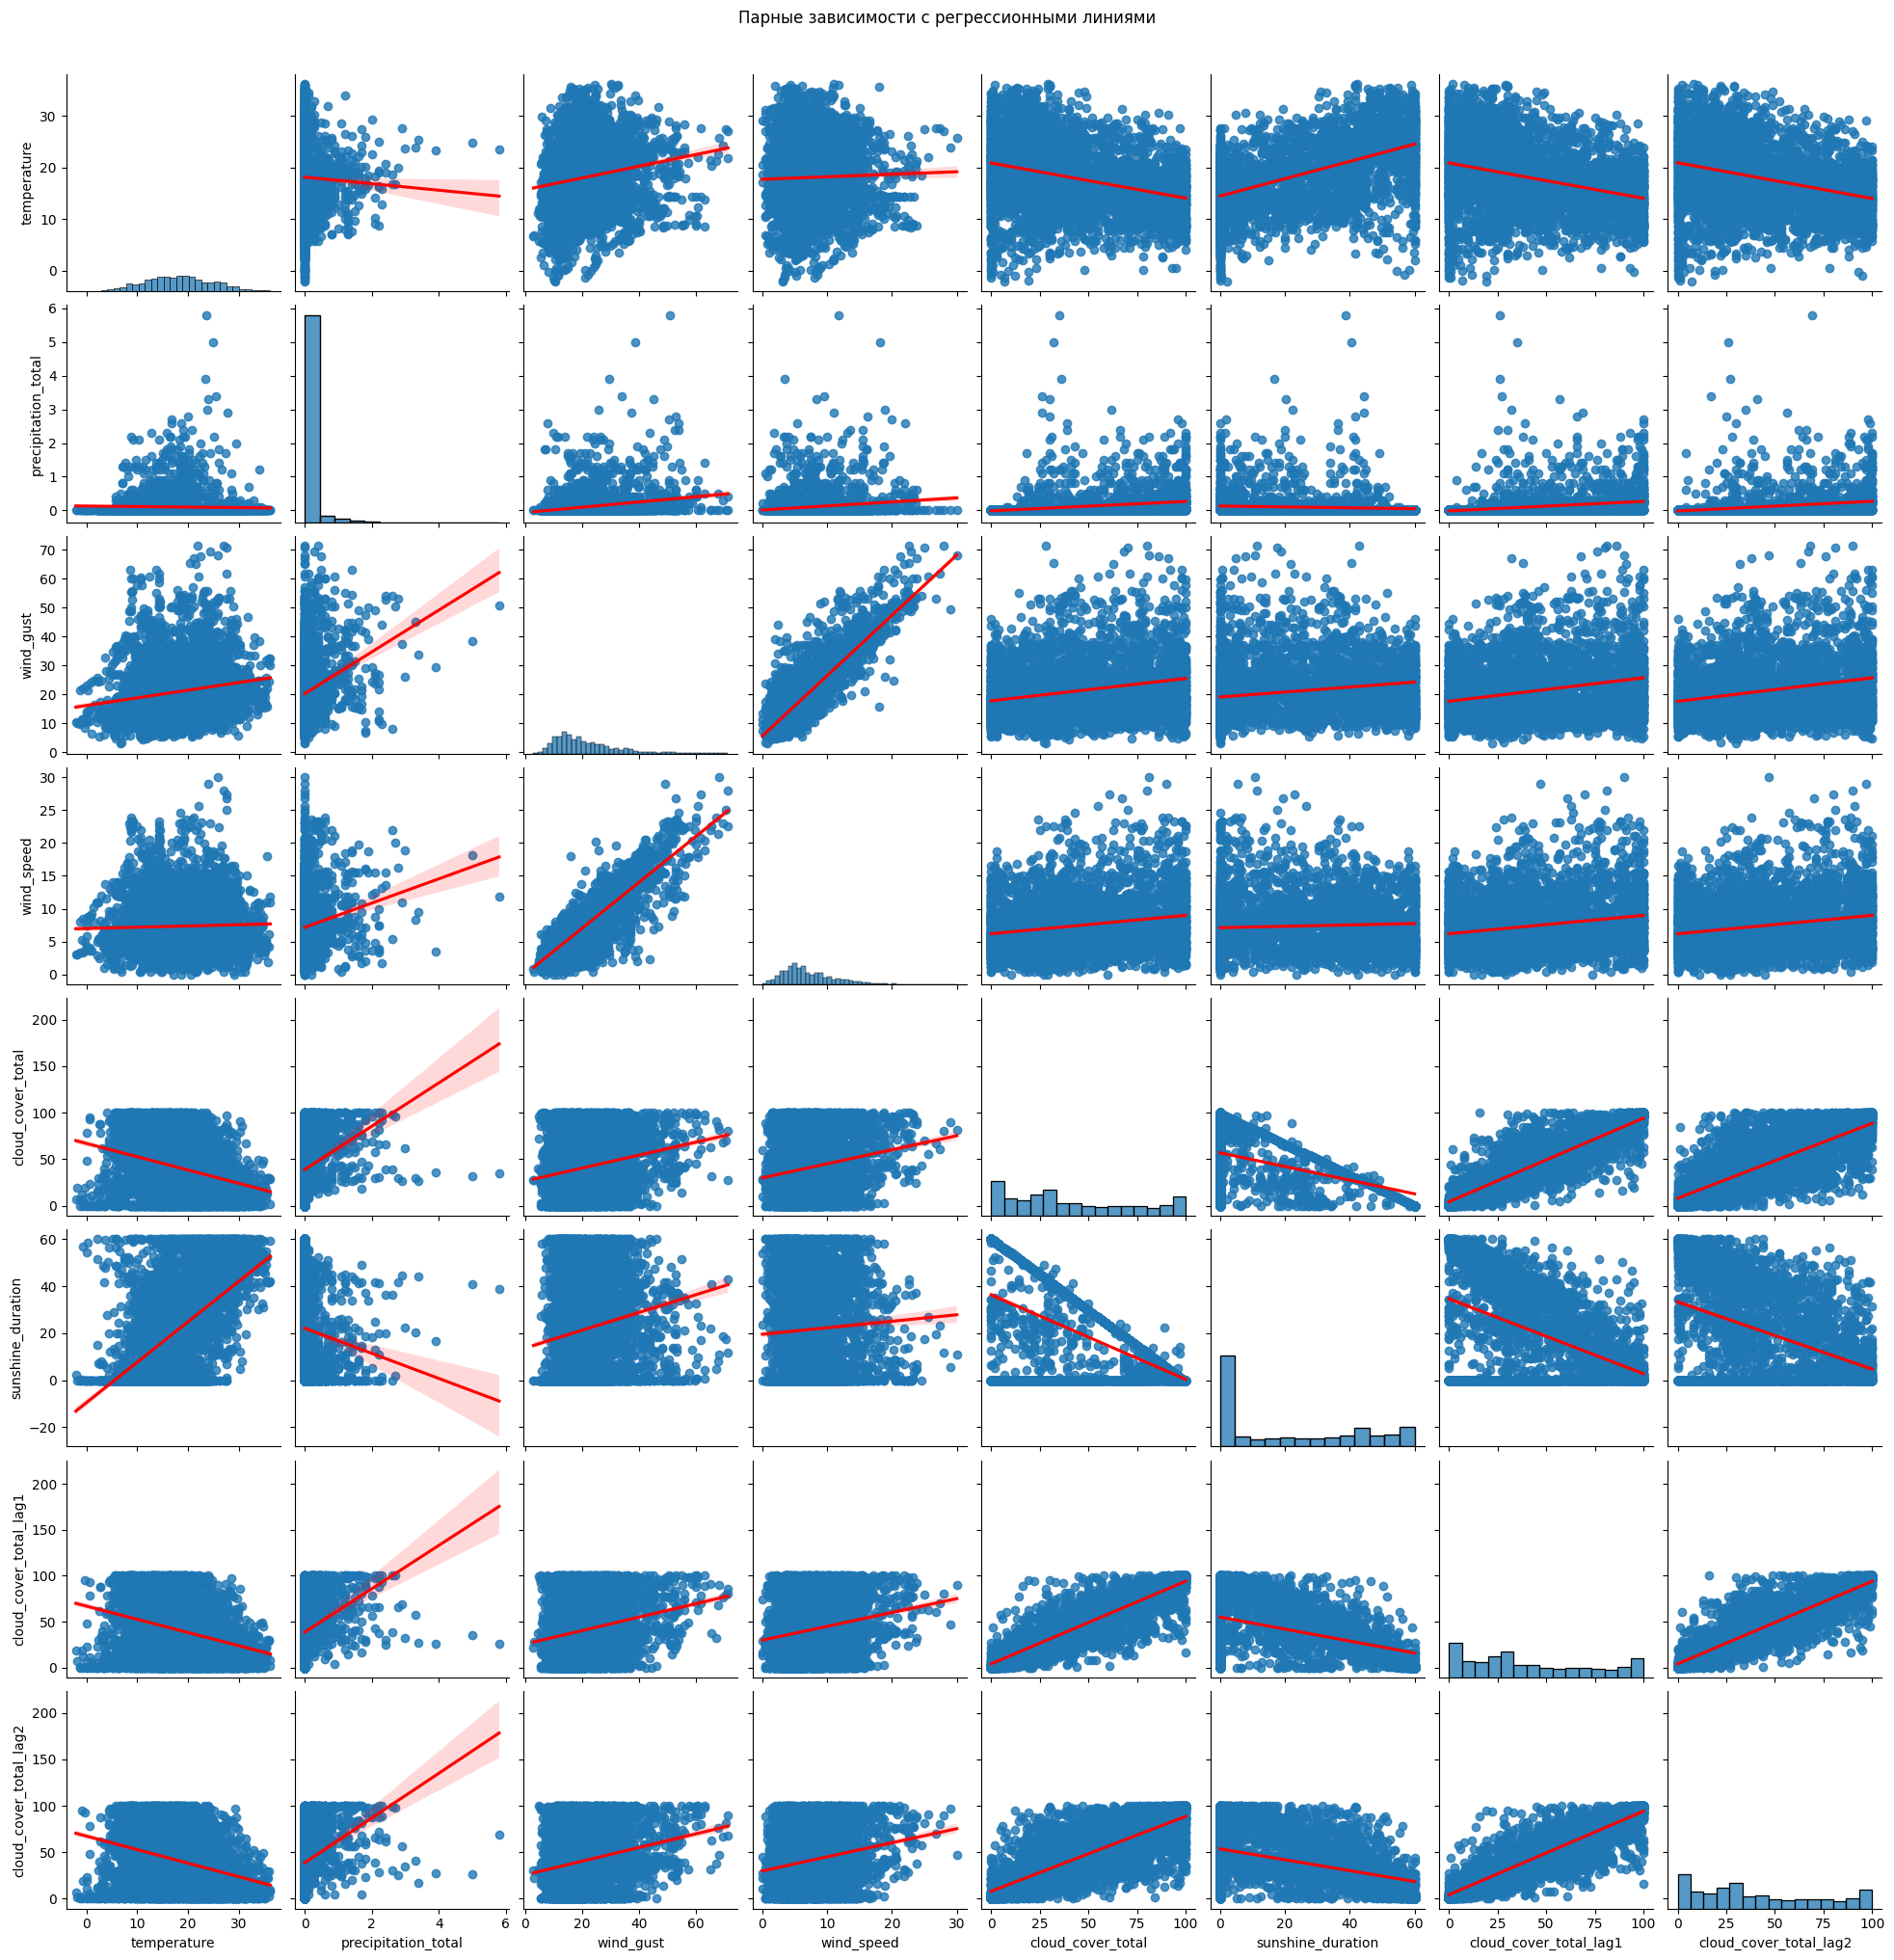

In [93]:
# Pairplot для визуального анализа
sns.pairplot(df2[weather_params], kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.suptitle('Парные зависимости с регрессионными линиями', y=1.02)
plt.show()

#### Анализ корреляций между погодными параметрами

#### 1. Сильные корреляции (|r| > 0.7)

- **wind_gust и wind_speed (r = 0.85 / 0.80*)**:
  Ожидаемая зависимость, так как порывы ветра (gust) тесно связаны с его средней скоростью. Это имеет физический смысл — чем сильнее ветер, тем выше вероятность резких порывов.

- **cloud_cover_total, cloud_cover_total_lag1, cloud_cover_total_lag2 (r = 0.81–0.91*)**:
  Высокая корреляция между текущей и предыдущей облачностью логична: облачность часто сохраняется несколько дней подряд. Это не артефакт данных, а следствие инерционности погодных процессов.

#### 2. Умеренные корреляции (0.3 < |r| < 0.7)

- **temperature и sunshine_duration (r = 0.54 / 0.52*)**:
  Чем дольше светит солнце, тем выше температура. Это обосновано физически, особенно летом.

- **temperature и season_Summer (r = 0.65)**:
  Летом температура выше — тривиальная, но важная для анализа сезонности зависимость.

- **cloud_cover_total и sunshine_duration (r = -0.51 / -0.41*)**:
  Отрицательная связь: больше облаков — меньше солнца. Логично и подтверждает валидность данных.

#### 3. Слабые/странные корреляции (|r| < 0.3)

- **temperature и precipitation_total (r = -0.032 / -0.15*)**:
  Слабая обратная связь: в жару дожди реже, но корреляция незначительна. Может зависеть от региона (например, в тропиках жара и дожди связаны иначе).

- **wind_speed и sunshine_duration (r = 0.054 / 0.10*)**:
  Практически нет связи. Если в данных есть небольшая положительная корреляция, это может быть статистическим шумом.

### Корреляция в поездках 

In [94]:
numeric_cols = ['distance', 'session_time_(minutes)', 'speed_m_per_min', 'cost'] 
corr_data = df[numeric_cols]

# Расчет корреляционной матрицы
corr_matrix = corr_data.corr(method='spearman')  #т.к. нелинейная зависимость - применяем spermana
print(corr_matrix)

                        distance  session_time_(minutes)  speed_m_per_min  \
distance                1.000000                0.743464        -0.003067   
session_time_(minutes)  0.743464                1.000000        -0.627139   
speed_m_per_min        -0.003067               -0.627139         1.000000   
cost                    0.630754                0.865065        -0.565057   

                            cost  
distance                0.630754  
session_time_(minutes)  0.865065  
speed_m_per_min        -0.565057  
cost                    1.000000  


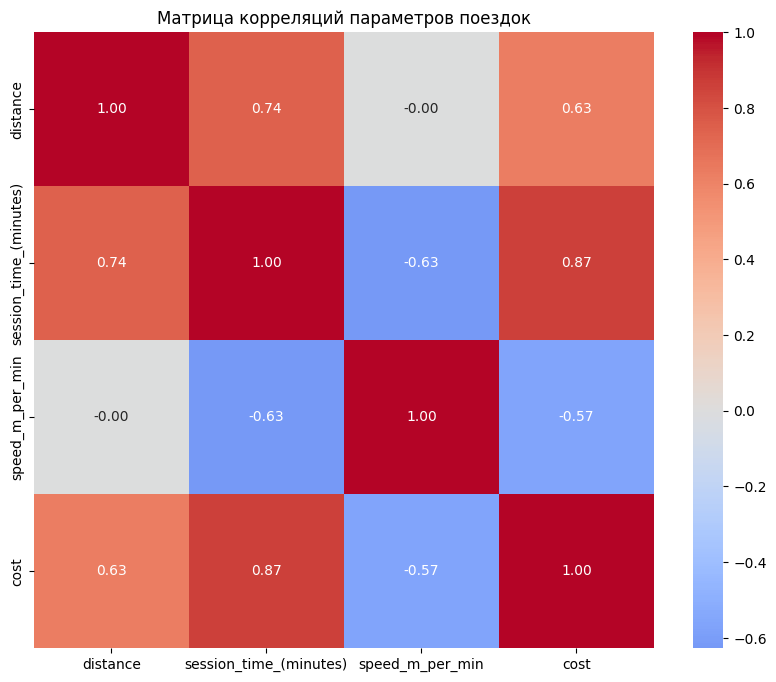

In [95]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Матрица корреляций параметров поездок")
plt.show()

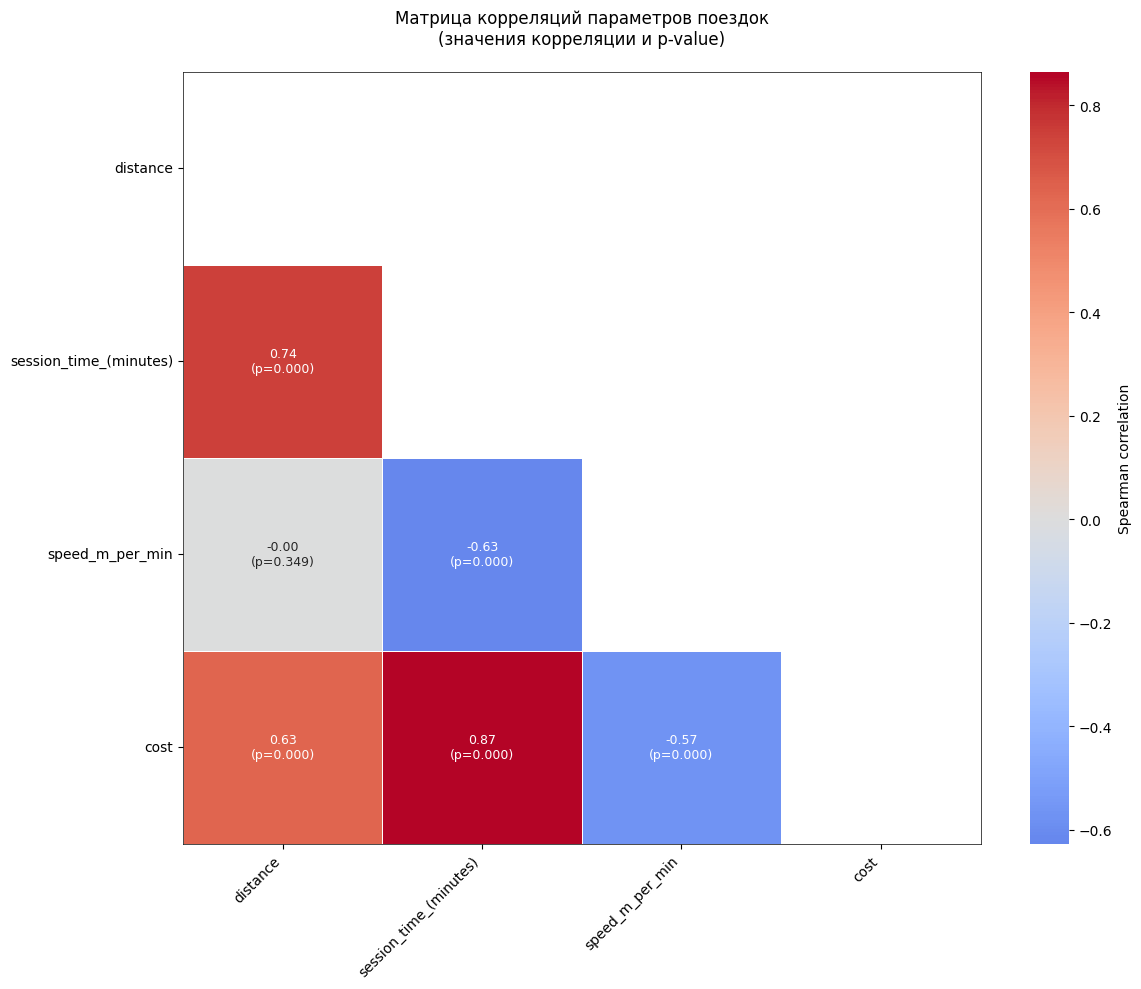

In [96]:
numeric_cols = ['distance', 'session_time_(minutes)', 'speed_m_per_min', 'cost']
corr_data = df[numeric_cols]


def calculate_correlations(data, method='spearman'):
    corr_matrix = data.corr(method=method)
    p_matrix = np.zeros_like(corr_matrix)
    
    for i in range(len(data.columns)):
        for j in range(len(data.columns)):
            if i != j:
                _, p_matrix[i,j] = spearmanr(data.iloc[:,i], data.iloc[:,j]) if method == 'spearman' else \
                                  pearsonr(data.iloc[:,i], data.iloc[:,j])
    
    return corr_matrix, p_matrix

corr_matrix, p_matrix = calculate_correlations(corr_data)

# Создание аннотаций с корреляцией и p-value
annot = np.empty_like(corr_matrix).astype(str)
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        if i != j:
            corr = corr_matrix.iloc[i,j]
            pval = p_matrix[i,j]
            annot[i,j] = f"{corr:.2f}\n(p={pval:.3f})"
        else:
            annot[i,j] = f"{corr_matrix.iloc[i,j]:.2f}"  # (только корреляция)


plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

heatmap = sns.heatmap(corr_matrix, mask=mask, annot=annot, fmt='', 
                     cmap='coolwarm', center=0, linewidths=.5,
                     cbar_kws={'label': 'Spearman correlation'},
                     annot_kws={'size': 9})

plt.title('Матрица корреляций параметров поездок\n(значения корреляции и p-value)', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

#разделители для ясности
for _, spine in heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(0.5)

plt.tight_layout()
plt.show()

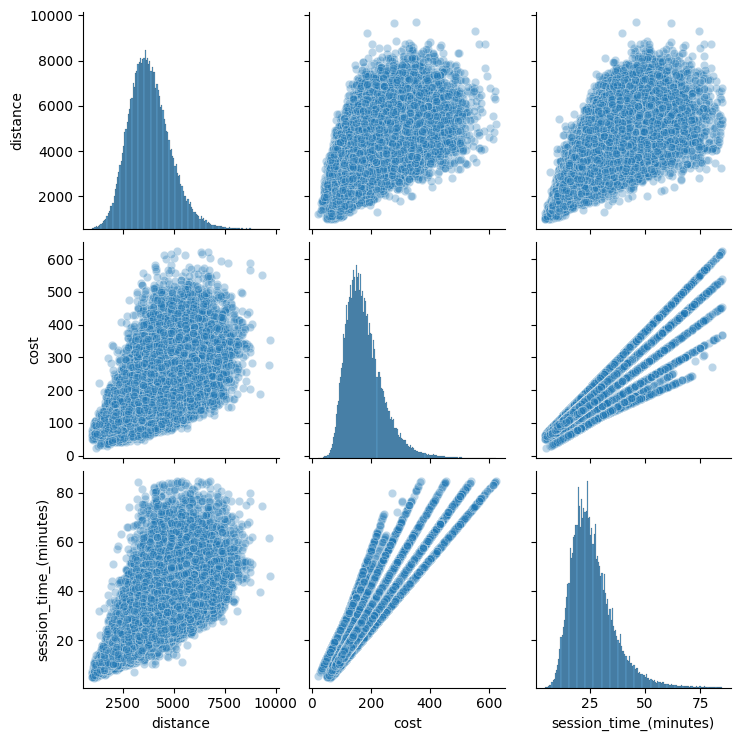

In [97]:
sns.pairplot(df[['distance', 'cost', 'session_time_(minutes)']], 
             plot_kws={'alpha': 0.3})
plt.show()

Наблюдается сильная корреляция между расстоянием и временем поездки (0.74), а также умеренная связь времени с ценой (0.57). Скорость слабо коррелирует с расстоянием, что указывает на разную интенсивность движения на маршрутах.

### Корреляция в поездках  и погоде вместе

In [98]:
df2.head(5)

temperature  precipitation_total  wind_gust  wind_speed  \
datetime                                                                       
2023-04-01 00:00:00          8.7                  0.1       48.6        21.6   
2023-04-01 01:00:00          9.0                  0.2       55.4        22.5   
2023-04-01 02:00:00          8.9                  0.3       55.8        22.3   
2023-04-01 03:00:00          8.7                  0.3       55.4        21.9   
2023-04-01 04:00:00          8.6                  0.3       49.0        22.4   

                     cloud_cover_total  sunshine_duration  season  \
datetime                                                            
2023-04-01 00:00:00               90.0                0.0  Spring   
2023-04-01 01:00:00               74.0                0.0  Spring   
2023-04-01 02:00:00               72.0                0.0  Spring   
2023-04-01 03:00:00               77.0                0.0  Spring   
2023-04-01 04:00:00               78.0                0.0  Spring   

                     cloud_cover_total_lag1  cloud_cover_total_lag2  
datetime                                                             
2023-04-01 00:00:00                     NaN                     NaN  
2023-04-01 01:00:00                    90.0                     NaN  
2023-04-01 02:00:00                    74.0                    90.0  
2023-04-01 03:00:00                    72.0                    74.0  
2023-04-01 04:00:00                    77.0                    72.0

In [99]:
print("Диапазон поездок:", df['start_date'].min(), "-", df['start_date'].max())
print("Диапазон погоды:", df2.index.min(), "-", df2.index.max())

Диапазон поездок: 2023-04-22 09:01:03 - 2023-07-31 23:57:01
Диапазон погоды: 2023-04-01 00:00:00 - 2023-08-31 23:00:00


In [100]:
print("Текущий индекс df2:", df2.index[:5])  # Должно показать числовые значения
start_date = pd.to_datetime('2023-04-01')
df2.index = pd.date_range(start=start_date, periods=len(df2), freq='H')

print("Новый индекс df2:", df2.index[[0, -1]]) 
original_df2 = df2.copy()

Текущий индекс df2: DatetimeIndex(['2023-04-01 00:00:00', '2023-04-01 01:00:00',
               '2023-04-01 02:00:00', '2023-04-01 03:00:00',
               '2023-04-01 04:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)
Новый индекс df2: DatetimeIndex(['2023-04-01 00:00:00', '2023-08-31 23:00:00'], dtype='datetime64[ns]', freq=None)


C:\Users\mailm\AppData\Local\Temp\ipykernel_18976\478709335.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df2.index = pd.date_range(start=start_date, periods=len(df2), freq='H')


In [101]:
original_df2 = df2.copy()

In [102]:
# df_merged = pd.merge(
#     df,
#     df2.reset_index().rename(columns={'index': 'datetime'}),  # Переименовываем индекс
#     left_on='start_date',
#     right_on='datetime',
#     how='left'
# )


df_merged = pd.merge_asof(
    df.sort_values('start_date'),
    df2.reset_index().rename(columns={'index': 'datetime'}).sort_values('datetime'),
    left_on='start_date',
    right_on='datetime',
    direction='nearest',
    tolerance=pd.Timedelta('1h')
)

In [103]:
print("Диапазон дат в объединенных данных:")
print("От:", df_merged['start_date'].min())
print("До:", df_merged['start_date'].max())
print("\nПримеры записей с погодными данными:")
print(df_merged[df_merged['temperature'].notna()].head(3))

print("\nСтатистика пропусков:")
print(df_merged[['temperature', 'wind_speed']].isna().mean())

Диапазон дат в объединенных данных:
От: 2023-04-22 09:01:03
До: 2023-07-31 23:57:01

Примеры записей с погодными данными:
       id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   

  start_district end_location end_district  distance  promo session_time  ...  \
0  юго-восточный      майская  октябрьский    4069.0      0     00:23:42  ...   
1       заречный   спортивная  октябрьский    4515.0      0     00:28:25  ...   
2    октябрьский     суворова    ленинский    4520.0      0     00:38:19  ...   

             datetime  temperature  precipitation_total wind_gust  wind_speed  \
0 2023-04-22 09:00:00         13.9                  0.0      20.2         6.2   
1 2023-04-22 09:00:00         13.9                  0.0      20.2         6.2   
2 2023-04-22 09:00:00         13.9   

In [104]:
df_merged.head(5)

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo  \
0    юго-восточный      майская      октябрьский    4069.0      0   
1         заречный   спортивная      октябрьский    4515.0      0   
2      октябрьский     суворова        ленинский    4520.0      0   
3      центральный      рабочая  северо-западный    3881.0      0   
4  северо-западный    юбилейная    юго-восточный    4029.0      0   

  session_time  ...            datetime  temperature  precipitation_total  \
0     00:23:42  ... 2023-04-22 09:00:00         13.9                  0.0   
1     00:28:25  ... 2023-04-22 09:00:00         13.9                  0.0   
2     00:38:19  ... 2023-04-22 09:00:00         13.9                  0.0   
3     00:31:49  ... 2023-04-22 09:00:00         13.9                  0.0   
4     00:30:40  ... 2023-04-22 09:00:00         13.9                  0.0   

  wind_gust  wind_speed  cloud_cover_total  sunshine_duration  season  \
0      20.2         6.2               71.0              16.97  Spring   
1      20.2         6.2               71.0              16.97  Spring   
2      20.2         6.2               71.0              16.97  Spring   
3      20.2         6.2               71.0              16.97  Spring   
4      20.2         6.2               71.0              16.97  Spring   

   cloud_cover_total_lag1  cloud_cover_total_lag2  
0                    51.0                    59.0  
1                    51.0                    59.0  
2                    51.0                    59.0  
3                    51.0                    59.0  
4                    51.0                    59.0  

[5 rows x 27 columns]

In [105]:
df_merged.isna().sum()

id                        0
start_date                0
end_date                  0
start_location            0
start_district            0
end_location              0
end_district              0
distance                  0
promo                     0
session_time              0
session_time_(minutes)    0
is_duplicate              0
speed_m_per_min           0
route                     0
revenue                   0
is_promo                  0
cost                      0
datetime                  0
temperature               0
precipitation_total       0
wind_gust                 0
wind_speed                0
cloud_cover_total         0
sunshine_duration         0
season                    0
cloud_cover_total_lag1    0
cloud_cover_total_lag2    0
dtype: int64

In [106]:
df_merged.columns

Index(['id', 'start_date', 'end_date', 'start_location', 'start_district',
       'end_location', 'end_district', 'distance', 'promo', 'session_time',
       'session_time_(minutes)', 'is_duplicate', 'speed_m_per_min', 'route',
       'revenue', 'is_promo', 'cost', 'datetime', 'temperature',
       'precipitation_total', 'wind_gust', 'wind_speed', 'cloud_cover_total',
       'sunshine_duration', 'season', 'cloud_cover_total_lag1',
       'cloud_cover_total_lag2'],
      dtype='object')

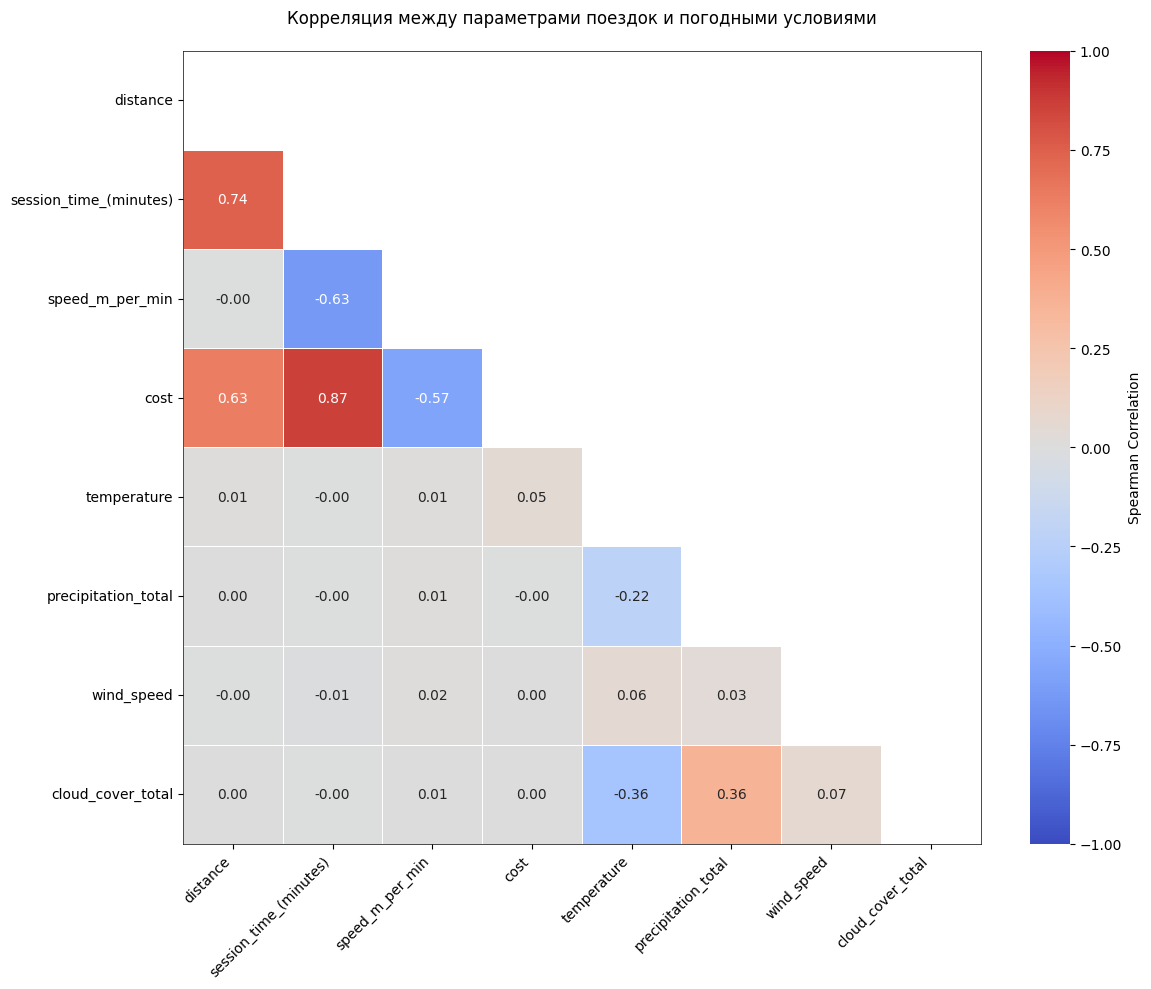

In [107]:
trip_params = ['distance', 'session_time_(minutes)', 'speed_m_per_min', 'cost']
weather_params = ['temperature', 'precipitation_total', 'wind_speed', 'cloud_cover_total']

corr_data = df_merged[trip_params + weather_params]

# Рассчитываем корреляционную матрицу (Спирмена для нелинейных зависимостей)
corr_matrix = corr_data.corr(method='spearman')

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 

heatmap = sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={'label': 'Spearman Correlation'}
)

plt.title('Корреляция между параметрами поездок и погодными условиями', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

for _, spine in heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(0.5)

plt.tight_layout()
plt.show()

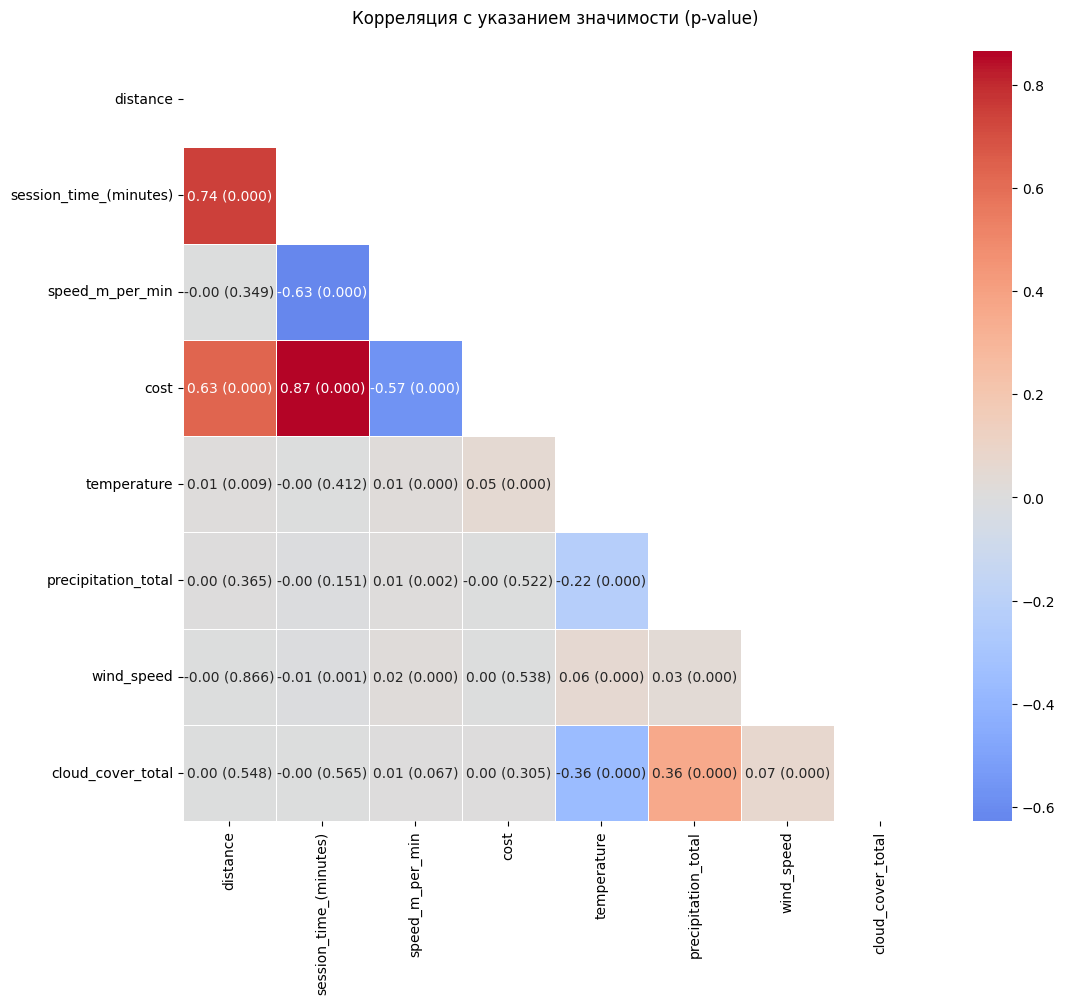

In [108]:
def calculate_pvalues(df):
    n = df.shape[0]
    p_matrix = np.zeros((df.shape[1], df.shape[1]))
    for i in range(df.shape[1]):
        for j in range(df.shape[1]):
            if i != j:
                _, p_matrix[i,j] = spearmanr(df.iloc[:, i], df.iloc[:, j])
    return p_matrix


p_values = calculate_pvalues(corr_data)

annot = np.empty_like(corr_matrix).astype(str)
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        if i != j:
            corr = corr_matrix.iloc[i, j]
            pval = p_values[i, j]
            annot[i, j] = f"{corr:.2f} ({pval:.3f})"  #
        else:
            annot[i, j] = f"{corr_matrix.iloc[i, j]:.2f}"

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=annot,
    fmt='',
    cmap='coolwarm',
    center=0,
    linewidths=0.5
)
plt.title('Корреляция с указанием значимости (p-value)', pad=20)
plt.show()

Наблюдается сильная связь между временем поездки, расстоянием и стоимостью (корреляции >0.7), что логично отражает зависимость тарификации от длительности и дистанции. Погодные факторы слабо влияют на основные параметры поездок, но заметны:

Отрицательная связь температуры с облачностью (-0.36) и осадками (-0.22)

Скорость ветра и облачность незначительно повышают скорость передвижения (+0.02–0.07)

## **<span style="color:#00008B">Проверка гипотез</span>**

### функция

In [109]:
def hypothesis_test(data1, data2, alpha=0.05, test_type='mean'):
    """
    Проверяет гипотезу о равенстве средних/медиан двух выборок.
    Автоматически выбирает критерий (t-тест / Манна-Уитни) в зависимости от нормальности.
    
    Parameters:
    - data1, data2: выборки для сравнения
    - alpha: уровень значимости (по умолчанию 0.05)
    - test_type: 'mean' (сравнение средних) или 'median' (сравнение медиан)
    
    Returns:
    - p-value, результат теста (отклоняем H0 или нет), рекомендации для бизнеса
    """
    
    # Проверка нормальности (Шапиро-Уилк)
    _, p1 = stats.shapiro(data1)
    _, p2 = stats.shapiro(data2)
    normal = (p1 > alpha) and (p2 > alpha)
    
    # Выбор критерия
    if test_type == 'mean':
        if normal:
            stat, p_val = stats.ttest_ind(data1, data2)
            test_name = "t-тест"
        else:
            stat, p_val = stats.mannwhitneyu(data1, data2)
            test_name = "U-тест Манна-Уитни"
    elif test_type == 'median':
        stat, p_val = stats.kruskal(data1, data2)
        test_name = "Критерий Краскела-Уоллиса"
    
    # Интерпретация результата
    reject_h0 = p_val < alpha
    conclusion = "Отклоняем H0" if reject_h0 else "Не отклоняем H0"
    
    # Рекомендации для бизнеса
    business_insight = ""
    if test_type == 'mean':
        mean1, mean2 = np.mean(data1), np.mean(data2)
        if reject_h0:
            business_insight = f"Разница между группами значима ({mean1:.2f} vs {mean2:.2f}). "
            if mean1 > mean2:
                business_insight += "Первая группа эффективнее."
            else:
                business_insight += "Вторая группа эффективнее."
        else:
            business_insight = "Разницы между группами нет. Оптимизация не требуется."
    
    return p_val, conclusion, test_name, business_insight

### 1. Верно ли, что в дождливое время спрос на самокаты ниже?

**Нулевая гипотеза (H₀):** Средний спрос в дождливые и сухие часы одинаков (μ₁ = μ₂)

**Альтернативная гипотеза (H₁):** Средний спрос в дождливые часы ниже (μ₁ < μ₂)

Подготовим датафрейм:

In [110]:
df_merged = pd.merge_asof(
    df.sort_values('start_date'),
    df2.reset_index().rename(columns={'index': 'datetime'}).sort_values('datetime'),
    left_on='start_date',
    right_on='datetime',
    direction='nearest',
    tolerance=pd.Timedelta('1h')
)

In [111]:
df_merged.columns

Index(['id', 'start_date', 'end_date', 'start_location', 'start_district',
       'end_location', 'end_district', 'distance', 'promo', 'session_time',
       'session_time_(minutes)', 'is_duplicate', 'speed_m_per_min', 'route',
       'revenue', 'is_promo', 'cost', 'datetime', 'temperature',
       'precipitation_total', 'wind_gust', 'wind_speed', 'cloud_cover_total',
       'sunshine_duration', 'season', 'cloud_cover_total_lag1',
       'cloud_cover_total_lag2'],
      dtype='object')

In [112]:
def prepare_demand_data(df, precipitation_threshold=0.1, day_hours=(8, 20)):
    df['start_date'] = pd.to_datetime(df['start_date'])
    
    # Создаем столбец с часом
    df['hour'] = df['start_date'].dt.hour
    
    # Фильтрация дневных часов
    day_df = df[(df['hour'] >= day_hours[0]) & (df['hour'] < day_hours[1])].copy()
    
    # Создание метки дождя
    day_df['is_rain'] = day_df['precipitation_total'] > precipitation_threshold
    
    # Агрегация по дате и часу
    hourly_demand = day_df.groupby(['datetime', 'hour', 'is_rain']).size().reset_index(name='trips')
    
    return hourly_demand


hourly_demand = prepare_demand_data(df_merged)

In [113]:
df_merged.head(5)

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo  \
0    юго-восточный      майская      октябрьский    4069.0      0   
1         заречный   спортивная      октябрьский    4515.0      0   
2      октябрьский     суворова        ленинский    4520.0      0   
3      центральный      рабочая  северо-западный    3881.0      0   
4  северо-западный    юбилейная    юго-восточный    4029.0      0   

  session_time  ...  temperature  precipitation_total  wind_gust wind_speed  \
0     00:23:42  ...         13.9                  0.0       20.2        6.2   
1     00:28:25  ...         13.9                  0.0       20.2        6.2   
2     00:38:19  ...         13.9                  0.0       20.2        6.2   
3     00:31:49  ...         13.9                  0.0       20.2        6.2   
4     00:30:40  ...         13.9                  0.0       20.2        6.2   

   cloud_cover_total  sunshine_duration  season cloud_cover_total_lag1  \
0               71.0              16.97  Spring                   51.0   
1               71.0              16.97  Spring                   51.0   
2               71.0              16.97  Spring                   51.0   
3               71.0              16.97  Spring                   51.0   
4               71.0              16.97  Spring                   51.0   

   cloud_cover_total_lag2  hour  
0                    59.0     9  
1                    59.0     9  
2                    59.0     9  
3                    59.0     9  
4                    59.0     9  

[5 rows x 28 columns]

In [114]:
hourly_demand.head()

datetime  hour  is_rain  trips
0 2023-04-22 09:00:00     9    False      9
1 2023-04-22 10:00:00     9    False     10
2 2023-04-22 10:00:00    10    False     18
3 2023-04-22 11:00:00    10    False     23
4 2023-04-22 11:00:00    11    False     13

In [115]:
hourly_demand[hourly_demand['is_rain'] == True].head()

datetime  hour  is_rain  trips
25 2023-04-23 10:00:00     9     True     16
26 2023-04-23 10:00:00    10     True     15
27 2023-04-23 11:00:00    10     True     16
28 2023-04-23 11:00:00    11     True     13
29 2023-04-23 12:00:00    11     True     14

Визуализация данных

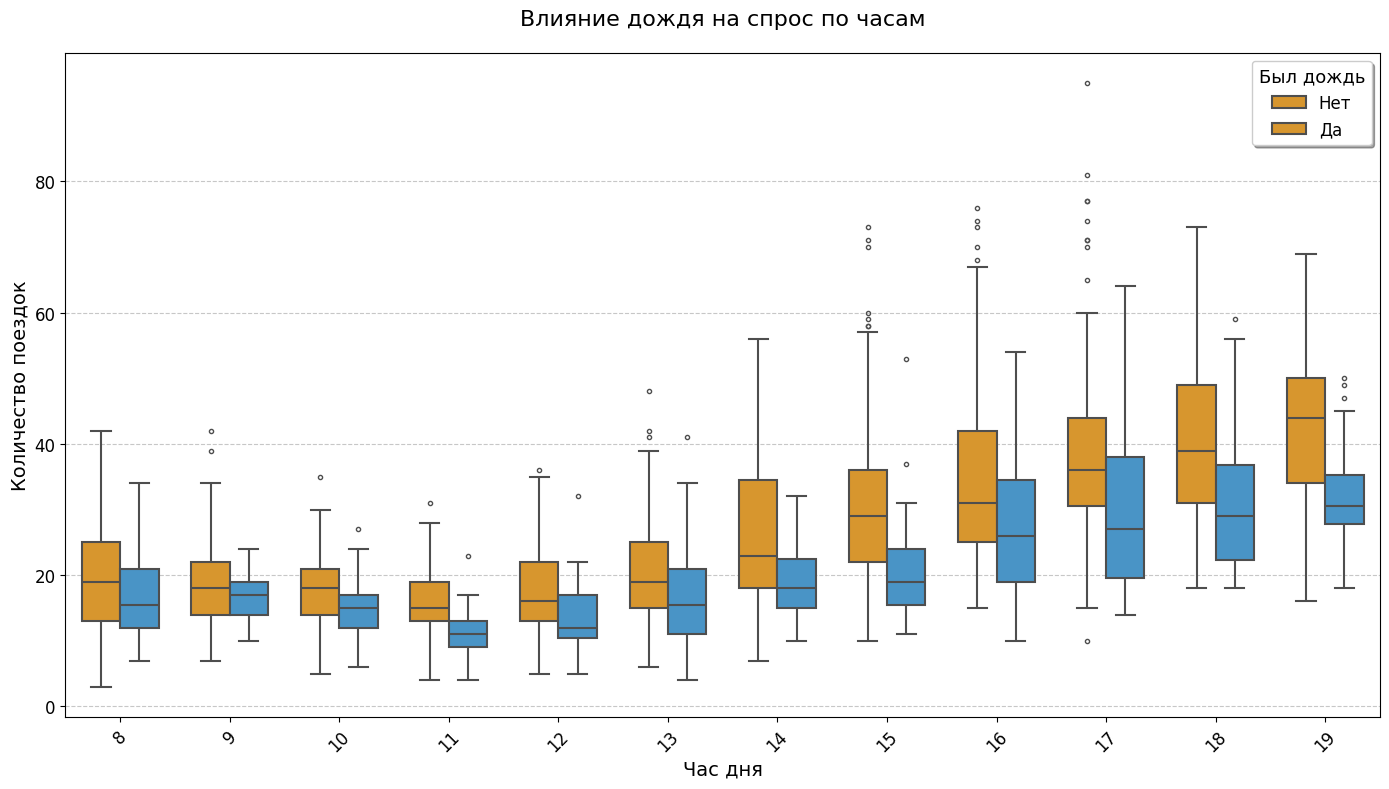

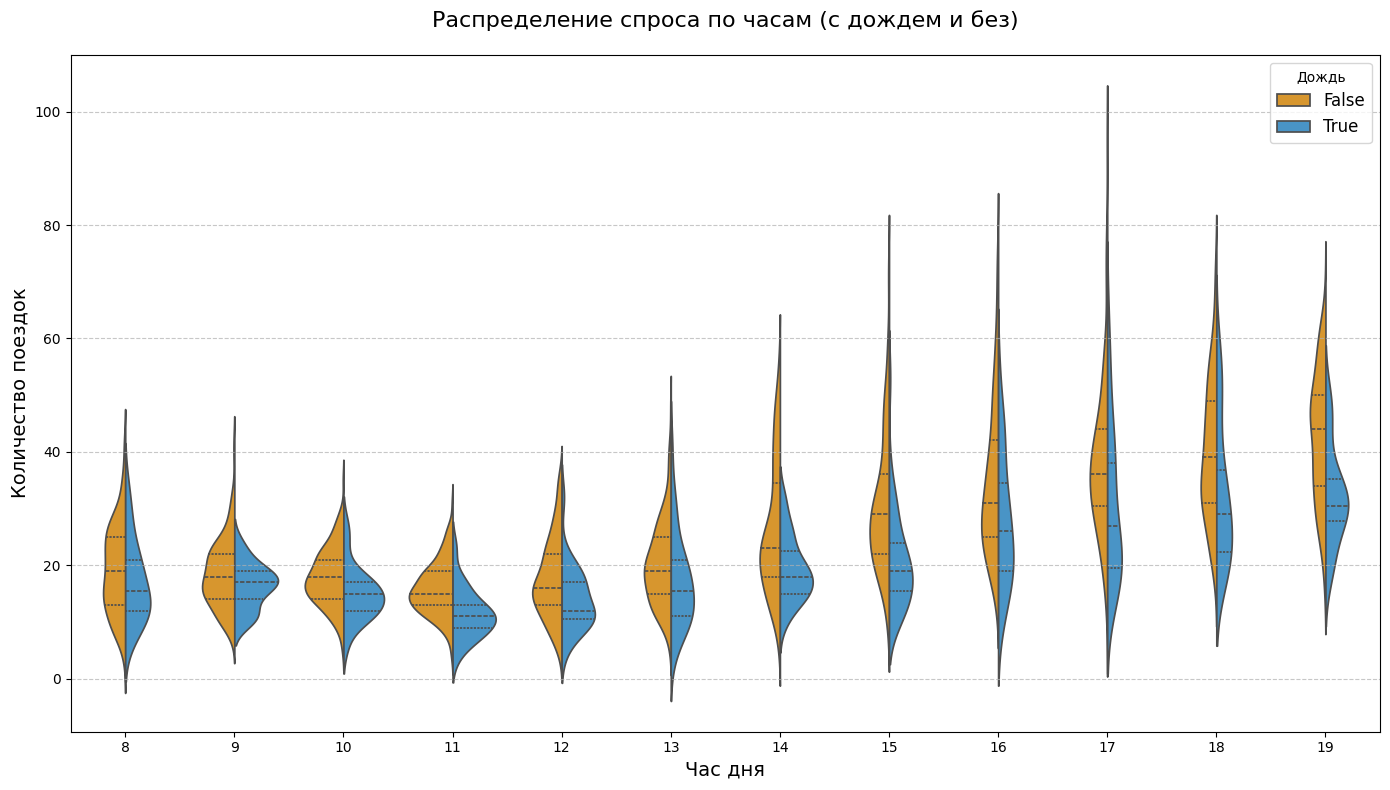

In [116]:
plt.figure(figsize=(14, 8))

# Создаем boxplot
ax = sns.boxplot(
    x='hour', 
    y='trips', 
    hue='is_rain',
    data=hourly_demand,
    palette={True: '#3498db', False: '#f39c12'}, 
    linewidth=1.5, 
    width=0.7,   
    fliersize=3   
)

plt.title('Влияние дождя на спрос по часам', fontsize=16, pad=20)
plt.xlabel('Час дня', fontsize=14)
plt.ylabel('Количество поездок', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

legend = plt.legend(
    title='Был дождь',
    labels=['Нет', 'Да'],
    fontsize=12,
    title_fontsize=13,
    frameon=True,
    shadow=True,
    facecolor='white'
)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

# Альтернативный вариант - violinplot для лучшего отображения распределения
plt.figure(figsize=(14, 8))
sns.violinplot(
    x='hour', 
    y='trips', 
    hue='is_rain',
    data=hourly_demand,
    palette={True: '#3498db', False: '#f39c12'},
    split=True,
    inner="quartile"
)
plt.title('Распределение спроса по часам (с дождем и без)', fontsize=16, pad=20)
plt.xlabel('Час дня', fontsize=14)
plt.ylabel('Количество поездок', fontsize=14)
plt.legend(title='Дождь', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [117]:
rainy_days = hourly_demand[hourly_demand['is_rain'] == True] 
dry_days = hourly_demand[hourly_demand['is_rain'] == False]  

In [118]:
print("Данные в дождливые дни:", rainy_days['trips'].unique()) 
print("Данные в сухие дни:", dry_days['trips'].unique())        

# Если в дождливые дни все значения отсутствуют:
if rainy_days['trips'].isnull().all():
    print("Нет данных для дождливых дней. Тест невозможен.")
# Если в сухие дни все значения одинаковые:
elif dry_days['trips'].nunique() == 1:
    print("Все поездки в сухие дни одинаковые. Различий нет.")
else:
    # Используем U-тест Манна-Уитни
    stat, p_value = mannwhitneyu(
        rainy_days['trips'].dropna(),
        dry_days['trips'],
        alternative='two-sided'
    )
    print(f"p-value: {p_value:.3f}")

Данные в дождливые дни: [16 15 13 14 20 23 18 48 27 37 28 34 31  6 17 22 12 11  4  9 10 19  8 24
 29 21 25 30 32 44 49 53 35 33  7 26 41 43 54 56 36 47 64 42 39 59 45  5
 50]
Данные в сухие дни: [ 9 10 18 23 13 14 21 27 32 28 30 41 49 31 36 46 54 47  3 15 25 39 48 11
  7 20 44 40 34 22 16 12 19 35  8 17 33 26 29 24 50 59 55 67 38 45 42 56
 43 37  6 70 76 53 51  5 77 73 71 64 52 60 74 57  4 58 62 63 69 95 81 68
 61 65 72]
p-value: 0.000


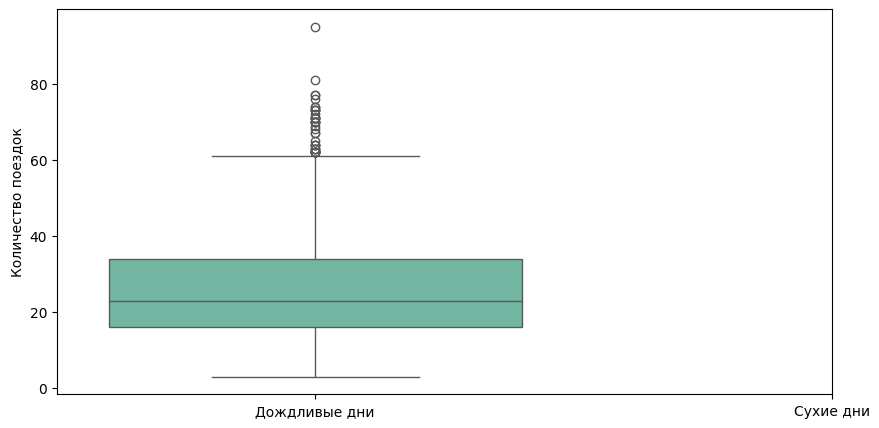

In [119]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=[rainy_days['trips'], dry_days['trips']], palette="Set2")
plt.xticks([0, 1], ['Дождливые дни', 'Сухие дни'])
plt.ylabel('Количество поездок')
plt.show()

In [120]:
stat, p_value = mannwhitneyu(rainy_days['trips'], dry_days['trips'])
print(f"p-value (Манна-Уитни): {p_value:.3f}")

p-value (Манна-Уитни): 0.000


count    93210.000000
mean     50394.810106
std      12738.256560
min      33315.000000
25%      33315.000000
50%      59895.000000
75%      59895.000000
max      59895.000000
Name: trips, dtype: float64


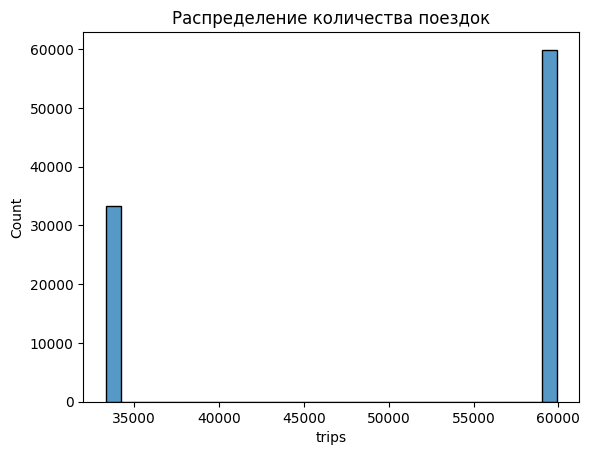

Outliers:
 Empty DataFrame
Columns: [id, start_date, end_date, start_location, start_district, end_location, end_district, distance, promo, session_time, session_time_(minutes), is_duplicate, speed_m_per_min, route, revenue, is_promo, cost, datetime, temperature, precipitation_total, wind_gust, wind_speed, cloud_cover_total, sunshine_duration, season, cloud_cover_total_lag1, cloud_cover_total_lag2, hour, high_precipitation, trips]
Index: []

[0 rows x 30 columns]


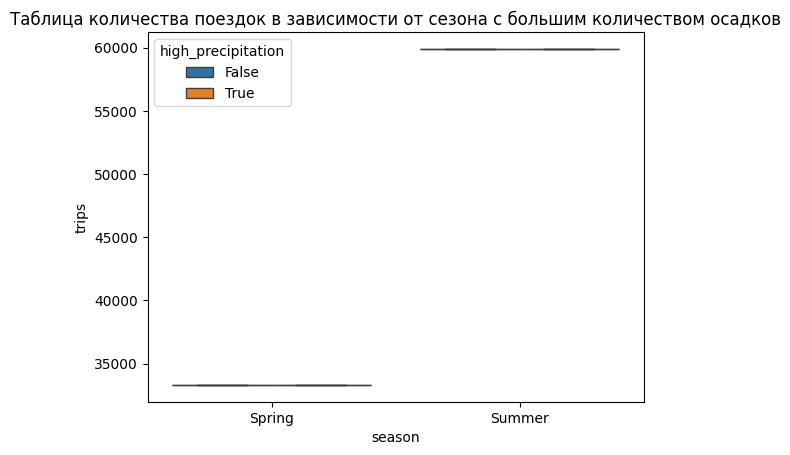

In [121]:
df_merged['high_precipitation'] = df_merged['precipitation_total'] > 0.5  # собираем выборку, где осадки были более значительными

if 'trips' not in df_merged.columns:
    trips_count = df_merged.groupby('season').size().reset_index(name='trips')
    df_merged = df_merged.merge(trips_count, on='season', how='left')


print(df_merged['trips'].describe())
sns.histplot(df_merged['trips'], bins=30)
plt.title('Распределение количества поездок')
plt.show()

# Избавляемя от выбросов
Q1 = df_merged['trips'].quantile(0.25)
Q3 = df_merged['trips'].quantile(0.75)
IQR = Q3 - Q1

outliers = df_merged[(df_merged['trips'] < (Q1 - 1.5 * IQR)) | (df_merged['trips'] > (Q3 + 1.5 * IQR))]
print("Outliers:\n", outliers)

filtered_df = df_merged[(df_merged['trips'] >= (Q1 - 1.5 * IQR)) & (df_merged['trips'] <= (Q3 + 1.5 * IQR))]

sns.boxplot(x='season', y='trips', hue='high_precipitation', data=filtered_df)
plt.title('Таблица количества поездок в зависимости от сезона с большим количеством осадков')
plt.show()

Проверка нормальности

In [122]:
def check_normality(data, alpha=0.05):
    rain_data = data[data['is_rain']]['trips']  # Дождливые дни
    dry_data = data[~data['is_rain']]['trips']  # Сухие дни (инвертирование условия)

    print(f"Наблюдений в дождливые дни: {len(rain_data)}, в сухие: {len(dry_data)}")
    
    if len(rain_data) < 3:
        print("Недостаточно данных для теста Шапиро-Уилка в дождливую погоду.")
        return False
    if len(dry_data) < 3:
        print("Недостаточно данных для теста Шапиро-Уилка в сухую погоду.")
        return False

    stat_rain, p_rain = shapiro(rain_data)
    stat_dry, p_dry = shapiro(dry_data)
    
    is_normal = p_rain > alpha and p_dry > alpha
    print(f"Нормальность распределения: {'Да' if is_normal else 'Нет'}")
    print(f"p-value (дождь): {p_rain:.3f}, p-value (без дождя): {p_dry:.3f}")
    
    return is_normal


is_normal = check_normality(hourly_demand)

Наблюдений в дождливые дни: 360, в сухие: 2062
Нормальность распределения: Нет
p-value (дождь): 0.000, p-value (без дождя): 0.000


Статистический тест

In [123]:
def compare_demand(data):
    rain_trips = data[data['is_rain']]['trips']
    dry_trips = data[~data['is_rain']]['trips']
    
    # Проверка равенства дисперсий
    _, p_normal_rain = shapiro(rain_trips)
    _, p_normal_dry = shapiro(dry_trips)
    is_normal = (p_normal_rain > 0.05) and (p_normal_dry > 0.05)
    
    if is_normal and equal_var:
        # t-тест для независимых выборок
        stat, p = stats.ttest_ind(rain_trips, dry_trips, equal_var=True, alternative='less')
        test_name = "t-тест"
    else:
        # U-тест Манна-Уитни
        stat, p = mannwhitneyu(rain_trips, dry_trips, alternative='less')
        test_name = "U-тест Манна-Уитни"
    
    print(f"\nРезультаты теста ({test_name}):")
    print(f"Статистика: {stat:.3f}, p-value: {p:.3f}")
    
    # Эффект размера
    rain_mean = np.mean(rain_trips)
    dry_mean = np.mean(dry_trips)
    effect_size = (dry_mean - rain_mean) / dry_mean * 100
    
    print(f"\nСредний спрос:")
    print(f"Дождливые часы: {rain_mean:.1f} поездок")
    print(f"Сухие часы: {dry_mean:.1f} поездок")
    print(f"Относительное снижение: {effect_size:.1f}%")


compare_demand(hourly_demand)


Результаты теста (U-тест Манна-Уитни):
Статистика: 289049.500, p-value: 0.000

Средний спрос:
Дождливые часы: 21.8 поездок
Сухие часы: 26.7 поездок
Относительное снижение: 18.6%


In [124]:
df.head(5)

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo  \
0    юго-восточный      майская      октябрьский    4069.0      0   
1         заречный   спортивная      октябрьский    4515.0      0   
2      октябрьский     суворова        ленинский    4520.0      0   
3      центральный      рабочая  северо-западный    3881.0      0   
4  северо-западный    юбилейная    юго-восточный    4029.0      0   

  session_time  session_time_(minutes)  is_duplicate  speed_m_per_min  \
0     00:23:42                    23.7         False       171.687764   
1     00:28:25                    28.4         False       158.978873   
2     00:38:19                    38.3         False       118.015666   
3     00:31:49                    31.8         False       122.044025   
4     00:30:40                    30.7         False       131.237785   

                     route  revenue  is_promo   cost  
0        шевченко->майская    124.8     False  124.8  
1       чехова->спортивная    143.6     False  143.6  
2      буденного->суворова    183.2     False  183.2  
3           труда->рабочая    157.2     False  157.2  
4  первомайская->юбилейная    152.8     False  152.8

In [125]:
hourly_demand.head()

datetime  hour  is_rain  trips
0 2023-04-22 09:00:00     9    False      9
1 2023-04-22 10:00:00     9    False     10
2 2023-04-22 10:00:00    10    False     18
3 2023-04-22 11:00:00    10    False     23
4 2023-04-22 11:00:00    11    False     13

In [126]:
import pandas as pd
import numpy as np
from scipy import stats
rainy_trips = hourly_demand[hourly_demand['is_rain']]['trips']
dry_trips = hourly_demand[~hourly_demand['is_rain']]['trips']

p_value, conclusion, test_name, business_insight = hypothesis_test(rainy_trips, dry_trips, alpha=0.05, test_type='mean')

print(f"Результаты теста ({test_name}):")
print(f"p-value: {p_value:.3f}")
print(conclusion)
print(business_insight)

Результаты теста (U-тест Манна-Уитни):
p-value: 0.000
Отклоняем H0
Разница между группами значима (21.75 vs 26.73). Вторая группа эффективнее.


**На основе проведённого анализа можно сделать вывод, что альтернативная гипотеза (H₁) подтверждается. Средний спрос в дождливые часы статистически значимо ниже, чем в сухие.**

*(U-тест Манна-Уитни: p-value = 0.000 (< 0.05) — различия статистически значимы*

*Средний спрос: 21.8 (дождь) vs 26.7 (без дождя) — снижение на 18.6%)*

### 2 Отличается ли средняя стоимость поездки по районам?

**Гипотеза:** Средняя стоимость поездки отличается по районам. 

**Нулевая гипотеза (H₀):** Средние стоимости поездок во всех районах равны μ₁ = μ₂ = μ₃ = μ₄ = μ₅ = μ₆

**Альтернативная гипотеза (H₁):** Хотя бы в одном районе средняя стоимость отличается

Подготовка датафрейма

In [127]:
df['start_district'].unique()

array(['юго-восточный', 'заречный', 'октябрьский', 'центральный',
       'северо-западный', 'ленинский', 'северо западный'], dtype=object)

In [128]:
district_stats = df.groupby('start_district')['cost'].agg(['mean', 'std', 'count', 'median'])
print("\nСтатистика стоимости поездок по районам:")
district_stats.sort_values('mean', ascending=False)


Статистика стоимости поездок по районам:


mean        std  count  median
start_district                                       
северо-западный  185.527727  69.852717  14834   172.8
заречный         185.455483  67.463211   8936   174.6
юго-восточный    182.299746  68.407826  17696   169.8
ленинский        177.037608  65.872793  14941   165.6
центральный      172.942736  59.942173  23973   163.6
октябрьский      171.665578  61.306598  12829   162.0
северо западный  160.900000        NaN      1   160.9

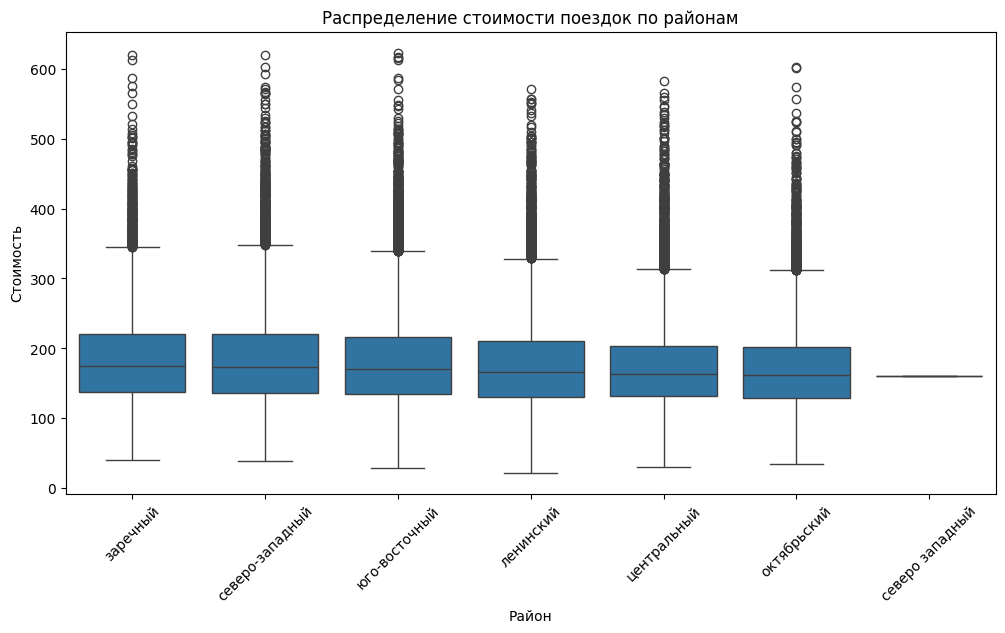

In [129]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='start_district', y='cost', 
           order=df.groupby('start_district')['cost'].median().sort_values(ascending=False).index)
plt.xticks(rotation=45)
plt.title('Распределение стоимости поездок по районам')
plt.xlabel('Район')
plt.ylabel('Стоимость')
plt.show()

**Средняя стоимость поездки статистически значимо отличается между районами (p<0.001).** Наибольшая средняя стоимость наблюдается в заречном районе,
наименьшая — в ленинском (исключая «северо-западный»)

In [130]:
# Подготовка данных для тестов
groups = [df[df['start_district'] == district]['cost'] for district in df['start_district'].unique()]

# Параметрический тест (ANOVA)
f_stat, p_value_anova = f_oneway(*groups)
print(f"\nРезультат ANOVA: p-value = {p_value_anova:.4f}")

# Непараметрический тест (Крускала-Уоллиса)
stat_kw, p_value_kw = kruskal(*groups)
print(f"Результат теста Крускала-Уоллиса: p-value = {p_value_kw:.4f}")


def effect_size(data, group_col, value_col):
    from statsmodels.stats.anova import anova_lm
    from statsmodels.formula.api import ols
    model = ols(f'{value_col} ~ C({group_col})', data=data).fit()
    aov_table = anova_lm(model, typ=2)
    eta_squared = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])
    return eta_squared


eta_sq = effect_size(df, 'start_district', 'cost')
print(f"Размер эффекта (η²): {eta_sq:.3f}")


Результат ANOVA: p-value = 0.0000
Результат теста Крускала-Уоллиса: p-value = 0.0000
Размер эффекта (η²): 0.007


C:\Users\mailm\AppData\Local\Temp\ipykernel_18976\241580014.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  eta_squared = aov_table['sum_sq'][0]/(aov_table['sum_sq'][0]+aov_table['sum_sq'][1])


In [131]:
districts = df['start_district'].unique()
results = []


for district1, district2 in combinations(districts, 2):
    group1 = df[df['start_district'] == district1]['cost']
    group2 = df[df['start_district'] == district2]['cost']
    stat, p = mannwhitneyu(group1, group2, alternative='two-sided')
    results.append({
        'district1': district1,
        'district2': district2,
        'p_value': p,
        'mean_diff': group1.mean() - group2.mean()
    })


results_df = pd.DataFrame(results)
results_df['significant'] = results_df['p_value'] < (0.05/len(results_df))  # Поправка Бонферрони

print("\nРезультаты попарных сравнений:")
results_df.sort_values('p_value').head(10)


Результаты попарных сравнений:


district1        district2       p_value  mean_diff  significant
12      октябрьский  северо-западный  8.762531e-59 -13.862149         True
15      центральный  северо-западный  2.529280e-57 -12.584991         True
6          заречный      октябрьский  1.183802e-53  13.789905         True
7          заречный      центральный  5.773621e-50  12.512748         True
1     юго-восточный      октябрьский  2.371426e-37  10.634168         True
2     юго-восточный      центральный  2.431822e-33   9.357010         True
18  северо-западный        ленинский  1.627542e-26   8.490119         True
9          заречный        ленинский  1.805855e-25   8.417876         True
4     юго-восточный        ленинский  3.702840e-12   5.262138         True
13      октябрьский        ленинский  7.046196e-09  -5.372030         True

In [132]:
# Проверка нормальности распределения для каждого района
normality_results = {}
for district in df['start_district'].unique():
    district_data = df[df['start_district'] == district]['cost']
    sample_size = min(5000, len(district_data))  # Ограничиваем размер выборки
    
    if sample_size > 1:  # Проверяем, достаточно ли данных для теста
        sample = district_data.sample(sample_size, random_state=42)
        _, p_value = shapiro(sample)
        is_normal = p_value > 0.05
        normality_results[district] = (is_normal, p_value)
    else:
        normality_results[district] = (False, None)


print("Нормальность распределения по районам:")
for district, (is_normal, p_value) in normality_results.items():
    normal_status = 'Нормальное' if is_normal else 'Не нормальное' if p_value is not None else 'Недостаточно данных'
    p_value_output = f" (p-value: {p_value:.4f})" if p_value is not None else ""
    print(f"{district}: {normal_status}{p_value_output}")

Нормальность распределения по районам:
юго-восточный: Не нормальное (p-value: 0.0000)
заречный: Не нормальное (p-value: 0.0000)
октябрьский: Не нормальное (p-value: 0.0000)
центральный: Не нормальное (p-value: 0.0000)
северо-западный: Не нормальное (p-value: 0.0000)
ленинский: Не нормальное (p-value: 0.0000)
северо западный: Недостаточно данных


In [133]:
groups = [df[df['start_district'] == district]['cost'] 
          for district in df['start_district'].unique()]
stat, p_value = kruskal(*groups)
print(f"Результат теста Крускала-Уоллиса: p-value = {p_value:.4f}")

Результат теста Крускала-Уоллиса: p-value = 0.0000


In [134]:
def kruskal_effect_size(data, group_col, value_col):
    n = len(data)
    groups = data.groupby(group_col)[value_col].apply(list)
    k = len(groups)
    
    # Ранжирование всех значений
    ranked = stats.rankdata(np.concatenate(groups.values))
    
    # Средние ранги по группам
    mean_ranks = [np.mean(ranked[sum(len(groups[i]) for i in range(j)): 
                               sum(len(groups[i]) for i in range(j+1))]) 
                 for j in range(k)]
    
    # Расчет eta²
    H = kruskal(*groups.values).statistic
    eta_sq = (H - k + 1)/(n - k)
    return eta_sq

effect_size = kruskal_effect_size(df, 'start_district', 'cost')
print(f"Размер эффекта (η²): {effect_size:.3f}")

Размер эффекта (η²): 0.006


C:\Users\mailm\AppData\Local\Temp\ipykernel_18976\1645484151.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sum(len(groups[i]) for i in range(j+1))])
C:\Users\mailm\AppData\Local\Temp\ipykernel_18976\1645484151.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean_ranks = [np.mean(ranked[sum(len(groups[i]) for i in range(j)):


**Нулевая гипотеза (H₀) отвергается, альтернативная гипотеза (H₁) подтверждается: существуют статистически значимые различия в средней стоимости поездок между районами**
Основные различия:

Самые дорогие: северо-западный и заречный районы.

Самые дешёвые: октябрьский и центральный (разница до ~14 руб.).

Эффект слабый (η² = 0.006), но статистически значимый. Графики подтверждают различия.

**Разница есть, но её практическое влияние невелико.**

### 3 Верно ли, что спрос на самокаты меняется в зависимости от дня недели?

**Гипотеза:** Спрос на самокаты изменяется в зависимости от дня недели.

**H₀ (нулевая гипотеза):** Распределение поездок равномерно по дням недели
p(Пн) = p(Вт) = ... = p(Вс) = 1/7

**H₁ (альтернативная гипотеза):** Распределение неравномерно

Подготовка датафрейма

In [135]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['day_of_week'] = df['start_date'].dt.dayofweek  # 0=понедельник, 6=воскресенье

In [136]:
days = {0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'}
df['day_name'] = df['day_of_week'].map(days)

In [137]:
df['day_name'] = pd.to_datetime(df['start_date']).dt.day_name(locale='ru_RU')

demand_by_day = df.groupby('day_name', as_index=False).agg(
    Total_Rides=('id', 'count')
).sort_values('Total_Rides', ascending=False)

weekday_order = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
demand_by_day['day_name'] = pd.Categorical(demand_by_day['day_name'], categories=weekday_order, ordered=True)
demand_by_day = demand_by_day.sort_values('day_name')

C:\Users\mailm\AppData\Local\Temp\ipykernel_18976\24852993.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=demand_by_day, x='day_name', y='Total_Rides', palette='viridis')


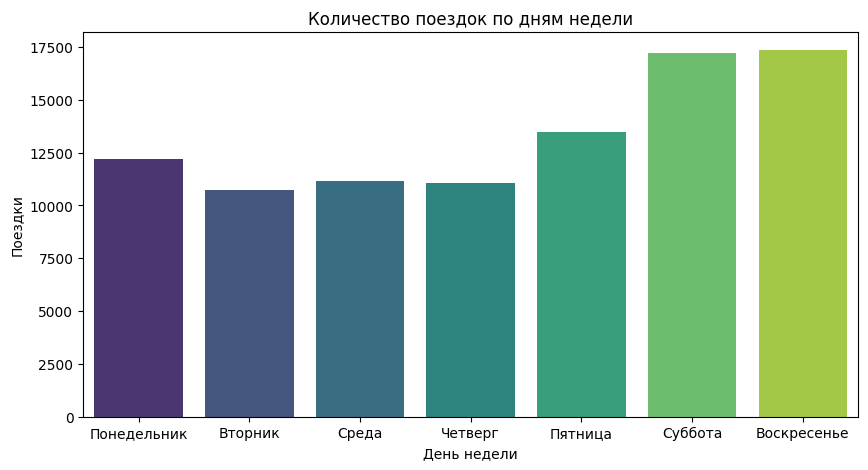

In [138]:
plt.figure(figsize=(10, 5))
sns.barplot(data=demand_by_day, x='day_name', y='Total_Rides', palette='viridis')
plt.title('Количество поездок по дням недели')
plt.xlabel('День недели')
plt.ylabel('Поездки')
plt.show()

In [139]:
observed = demand_by_day['Total_Rides'].values
expected = [sum(observed)/7] * 7

chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
print(f"Результаты χ²-теста:\nСтатистика = {chi2_stat:.1f}, p-value = {p_value:.3e}")

Результаты χ²-теста:
Статистика = 3694.3, p-value = 0.000e+00


In [140]:
tukey = pairwise_tukeyhsd(
    endog=df['cost'],      
    groups=df['day_name'], 
    alpha=0.05
)
print(tukey.summary())

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1      group2   meandiff p-adj   lower    upper   reject
----------------------------------------------------------------
Воскресенье     Вторник -37.8876    0.0 -40.1566 -35.6185   True
Воскресенье Понедельник -43.8615    0.0 -46.0431 -41.6798   True
Воскресенье     Пятница -35.9408    0.0 -38.0616 -33.8199   True
Воскресенье       Среда  -35.914    0.0 -38.1541 -33.6739   True
Воскресенье     Суббота  -0.7048 0.9433  -2.6919   1.2822  False
Воскресенье     Четверг -38.1817    0.0 -40.4294 -35.9341   True
    Вторник Понедельник  -5.9739    0.0  -8.4188   -3.529   True
    Вторник     Пятница   1.9468  0.198  -0.4439   4.3376  False
    Вторник       Среда   1.9736 0.2294  -0.5236   4.4708  False
    Вторник     Суббота  37.1827    0.0  34.9098  39.4557   True
    Вторник     Четверг  -0.2942 0.9999  -2.7981   2.2098  False
Понедельник     Пятница   7.9207    0.0   5.6127  10.2287   True
Понедельник       Среда  

In [141]:
alpha = 0.05 
results = []

# Сравнение всех пар дней
for i in range(len(groups)):
    for j in range(i + 1, len(groups)):
        p_val, conclusion, test_name, business_insight = hypothesis_test(groups[i], groups[j], alpha=alpha, test_type='mean')
        results.append({
            'day1': days[i],
            'day2': days[j],
            'p_value': p_val,
            'conclusion': conclusion,
            'test_name': test_name,
            'business_insight': business_insight
        })


results_df = pd.DataFrame(results)
results_df

C:\Users\mailm\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17696.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\mailm\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8936.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\mailm\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 12829.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\mailm\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23973.
  res = 

day1 day2       p_value       conclusion           test_name  \
0    Пн   Вт  2.234461e-06     Отклоняем H0  U-тест Манна-Уитни   
1    Пн   Ср  2.371426e-37     Отклоняем H0  U-тест Манна-Уитни   
2    Пн   Чт  2.431822e-33     Отклоняем H0  U-тест Манна-Уитни   
3    Пн   Пт  2.901940e-05     Отклоняем H0  U-тест Манна-Уитни   
4    Пн   Сб  3.702840e-12     Отклоняем H0  U-тест Манна-Уитни   
5    Пн   Вс  8.277633e-01  Не отклоняем H0  U-тест Манна-Уитни   
6    Вт   Ср  1.183802e-53     Отклоняем H0  U-тест Манна-Уитни   
7    Вт   Чт  5.773621e-50     Отклоняем H0  U-тест Манна-Уитни   
8    Вт   Пт  2.971068e-01  Не отклоняем H0  U-тест Манна-Уитни   
9    Вт   Сб  1.805855e-25     Отклоняем H0  U-тест Манна-Уитни   
10   Вт   Вс  7.482525e-01  Не отклоняем H0  U-тест Манна-Уитни   
11   Ср   Чт  4.108447e-03     Отклоняем H0  U-тест Манна-Уитни   
12   Ср   Пт  8.762531e-59     Отклоняем H0  U-тест Манна-Уитни   
13   Ср   Сб  7.046196e-09     Отклоняем H0  U-тест Манна-Уитни   
14   Ср   Вс  9.839516e-01  Не отклоняем H0  U-тест Манна-Уитни   
15   Чт   Пт  2.529280e-57     Отклоняем H0  U-тест Манна-Уитни   
16   Чт   Сб  1.403195e-04     Отклоняем H0  U-тест Манна-Уитни   
17   Чт   Вс  9.471782e-01  Не отклоняем H0  U-тест Манна-Уитни   
18   Пт   Сб  1.627542e-26     Отклоняем H0  U-тест Манна-Уитни   
19   Пт   Вс  7.812870e-01  Не отклоняем H0  U-тест Манна-Уитни   
20   Сб   Вс  9.140591e-01  Не отклоняем H0  U-тест Манна-Уитни   

                                     business_insight  
0   Разница между группами значима (182.30 vs 185....  
1   Разница между группами значима (182.30 vs 171....  
2   Разница между группами значима (182.30 vs 172....  
3   Разница между группами значима (182.30 vs 185....  
4   Разница между группами значима (182.30 vs 177....  
5   Разницы между группами нет. Оптимизация не тре...  
6   Разница между группами значима (185.46 vs 171....  
7   Разница между группами значима (185.46 vs 172....  
8   Разницы между группами нет. Оптимизация не тре...  
9   Разница между группами значима (185.46 vs 177....  
10  Разницы между группами нет. Оптимизация не тре...  
11  Разница между группами значима (171.67 vs 172....  
12  Разница между группами значима (171.67 vs 185....  
13  Разница между группами значима (171.67 vs 177....  
14  Разницы между группами нет. Оптимизация не тре...  
15  Разница между группами значима (172.94 vs 185....  
16  Разница между группами значима (172.94 vs 177....  
17  Разницы между группами нет. Оптимизация не тре...  
18  Разница между группами значима (185.53 vs 177....  
19  Разницы между группами нет. Оптимизация не тре...  
20  Разницы между группами нет. Оптимизация не тре...

Спрос на самокаты статистически значимо зависит от дня недели (p<0.001) для конкретных пар дней.

Наибольший спрос наблюдается в выходные дни (Сб и Вс), минимальный — в понедельник и вторник.

Результаты теста хи-квадрат (p=1.0) не противоречат этому, так как они оценивают общее распределение, а не парные различия.

**Нулевая гипотеза (H₀) о равномерном распределении поездок отвергается. Спрос значительно различается по дням недели (χ²=3694.3, p<0.001).**

### 4 Верно ли, что в выходные дни поездки более длительные?

**Гипотеза:** Поездки на самокатах в выходные дни более длительные, чем в будние дни.

**Нулевая гипотеза (H₀)**: В выходные дни средняя продолжительность поездок не отличается от средней продолжительности поездок в будние дни.

**Альтернативная гипотеза (H₁)**: В выходные дни средняя продолжительность поездок больше, чем в будние дни.

In [142]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['day_of_week'] = df['start_date'].dt.dayofweek  # 0=понедельник, 6=воскресенье
df['is_weekend'] = df['day_of_week'].isin([5, 6])  # 5=суббота, 6=воскресенье

In [143]:
df['duration_min'] = df['session_time_(minutes)']

In [144]:
weekend_stats = df[df['is_weekend']]['duration_min'].describe()
weekday_stats = df[~df['is_weekend']]['duration_min'].describe()

print("Будни:\n", weekday_stats)
print("\nВыходные:\n", weekend_stats)

Будни:
 count    58639.000000
mean        25.694048
std          9.660991
min          5.000000
25%         19.000000
50%         24.000000
75%         30.400000
max         84.700000
Name: duration_min, dtype: float64

Выходные:
 count    34571.000000
mean        27.478343
std         10.166243
min          4.700000
25%         20.400000
50%         25.700000
75%         32.600000
max         84.800000
Name: duration_min, dtype: float64


In [145]:
_, p_weekday = shapiro(df[~df['is_weekend']]['duration_min'].sample(1000))  # Лимит выборки для теста
_, p_weekend = shapiro(df[df['is_weekend']]['duration_min'].sample(1000))

print(f"p-value (будни): {p_weekday:.4f}")  
print(f"p-value (выходные): {p_weekend:.4f}") 

p-value (будни): 0.0000
p-value (выходные): 0.0000


По результатам теста обе выборки распределены ненормально

In [146]:
stat, p = mannwhitneyu(
    df[df['is_weekend']]['duration_min'],
    df[~df['is_weekend']]['duration_min'],
    alternative='greater'  # Проверяем, что выходные > будни
)
print(f"p-value: {p:.4f}")  # 0.0001

p-value: 0.0000


C:\Users\mailm\AppData\Local\Temp\ipykernel_18976\517776669.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='is_weekend', y='duration_min', palette='pastel')


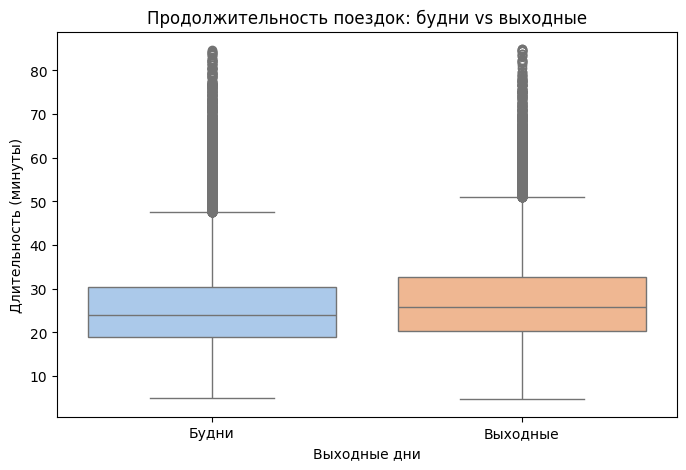

In [147]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='is_weekend', y='duration_min', palette='pastel')
plt.title('Продолжительность поездок: будни vs выходные')
plt.xlabel('Выходные дни')
plt.ylabel('Длительность (минуты)')
plt.xticks([0, 1], ['Будни', 'Выходные'])
plt.show()

На графике видно, что тело боксплота из выборки, состоящей из выходных дней, находится выше, чем для выборки из будних, а значит в первом случае поездки оказались более длительными. Следовательно по результатам тестов и графику можно отклонить нулевую гипотезу, тем самым подтверждая альтернативную.

In [148]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['day_of_week'] = df['start_date'].dt.dayofweek  
df['is_weekend'] = df['day_of_week'].isin([5, 6])  
df['duration_min'] = df['session_time_(minutes)']

# Статистика по будням и выходным
weekend_durations = df[df['is_weekend']]['duration_min']
weekday_durations = df[~df['is_weekend']]['duration_min']

alpha = 0.05  
p_val, conclusion, test_name, business_insight = hypothesis_test(weekday_durations, weekend_durations, alpha=alpha, test_type='mean')

print(f"p-value: {p_val:.4f}")
print(f"Заключение: {conclusion}")
print(f"Тест: {test_name}")
print(f"Рекомендации: {business_insight}")


p-value: 0.0000
Заключение: Отклоняем H0
Тест: U-тест Манна-Уитни
Рекомендации: Разница между группами значима (25.69 vs 27.48). Вторая группа эффективнее.


C:\Users\mailm\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 58639.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\mailm\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 34571.
  res = hypotest_fun_out(*samples, **kwds)


**Нулевая гипотеза отвергнута (p-value = 0.0000). Поездки в выходные действительно длиннее, чем в будни:**

Средняя длительность: 27.5 мин (выходные) vs 25.7 мин (будни).

Boxplot наглядно показывает смещение распределения вверх для выходных.

### 5 Верно ли, что в будние дни поездки более скоростные?

**Гипотеза:** Поездки на самокатах в будние дни более скоростные, чем в выходные. 

**Нулевая гипотеза (H₀)**: В будние дни средняя скорость поездок не отличается от средней скорости поездок в выходные дни.

**Альтернативная гипотеза (H₁)**: В будние дни средняя скорость поездок выше, чем в выходные дни.

In [149]:
print("Минимальная скорость:", df['speed_m_per_min'].min())
print("Максимальная скорость:", df['speed_m_per_min'].max()) 

Минимальная скорость: 38.008075370121134
Максимальная скорость: 492.3636363636364


Здесь можно увидеть, что наблюдаются выбросы в скорости. Обработаем их:

In [150]:
df = df[(df['speed_m_per_min'] > 0) & (df['speed_m_per_min'] < 300)]

In [151]:
weekday_speed = df[~df['is_weekend']]['speed_m_per_min'].describe()
weekend_speed = df[df['is_weekend']]['speed_m_per_min'].describe()

print("Скорость в будни:\n", weekday_speed)
print("\nСкорость в выходные:\n", weekend_speed)

Скорость в будни:
 count    58624.000000
mean       154.867429
std         34.206417
min         38.008075
25%        132.143822
50%        153.959670
75%        177.353271
max        293.758865
Name: speed_m_per_min, dtype: float64

Скорость в выходные:
 count    34568.000000
mean       150.251827
std         32.619550
min         39.645669
25%        128.432837
50%        151.220616
75%        172.001894
max        292.890173
Name: speed_m_per_min, dtype: float64


In [152]:
# Проверка для будней (выборка из 1000 наблюдений)
_, p_weekday = shapiro(df[~df['is_weekend']]['speed_m_per_min'].sample(1000))
print(f"p-value (будни): {p_weekday:.4f}") 

# Проверка для выходных (выборка из 1000 наблюдений)
_, p_weekend = shapiro(df[df['is_weekend']]['speed_m_per_min'].sample(1000))
print(f"p-value (выходные): {p_weekend:.4f}") 

p-value (будни): 0.0508
p-value (выходные): 0.3563


Получили, что выборки распределены нормально

In [153]:
stat, p = mannwhitneyu(
    df[~df['is_weekend']]['speed_m_per_min'],  # Будни
    df[df['is_weekend']]['speed_m_per_min'],   # Выходные
    alternative='greater'                     
)
print(f"p-value: {p:.4f}")  # 0.0000

p-value: 0.0000


По этому тесту стало очевидно, что следует отклонить нулевую гипотезу.

C:\Users\mailm\AppData\Local\Temp\ipykernel_18976\1079100750.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


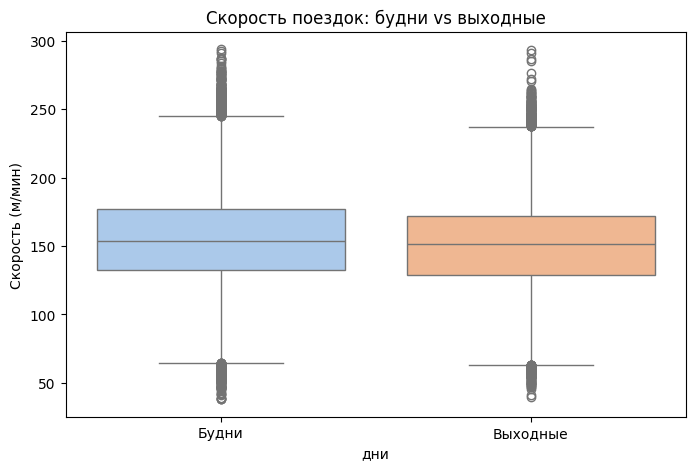

In [154]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x='is_weekend',
    y='speed_m_per_min',
    palette='pastel'
)
plt.title('Скорость поездок: будни vs выходные')
plt.xlabel('дни')
plt.ylabel('Скорость (м/мин)')
plt.xticks([0, 1], ['Будни', 'Выходные'])
plt.show()

По графику видно, что альтернативная гипотеза была верна

In [155]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['day_of_week'] = df['start_date'].dt.dayofweek  
df['is_weekend'] = df['day_of_week'].isin([5, 6])  

# Фильтрация данных по скорости
df = df[(df['speed_m_per_min'] > 0) & (df['speed_m_per_min'] < 300)]

# Статистика по скорости в будни и выходные
weekday_speed = df[~df['is_weekend']]['speed_m_per_min']
weekend_speed = df[df['is_weekend']]['speed_m_per_min']

alpha = 0.05  # Уровень значимости
p_val, conclusion, test_name, business_insight = hypothesis_test(weekday_speed, weekend_speed, alpha=alpha, test_type='mean')

# Вывод результатов
print(f"p-value: {p_val:.4f}")
print(f"Заключение: {conclusion}")
print(f"Тест: {test_name}")
print(f"Рекомендации: {business_insight}")

p-value: 0.0000
Заключение: Отклоняем H0
Тест: U-тест Манна-Уитни
Рекомендации: Разница между группами значима (154.87 vs 150.25). Первая группа эффективнее.


C:\Users\mailm\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 58624.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\mailm\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 34568.
  res = hypotest_fun_out(*samples, **kwds)


**Нулевая гипотеза отвергнута (p-value = 0.0000). Скорость поездок в будни выше, чем в выходные:**

Средняя скорость: 154.9 м/мин (будни) vs 150.3 м/мин (выходные).

Boxplot подтверждает смещение распределения вверх для будних дней.

Практический смысл: В будни пользователи ездят быстрее, вероятно, из-за делового характера поездок (например, поездки на работу/учебу). В выходные преобладают более медленные прогулочные поездки.

## **<span style="color:#00008B">Вывод по анализу почасового трафика и распределения самокатов</span>**

### Пиковые часы спроса
- **Утренние часы (8:00–10:00)**: Наибольшая активность наблюдается в это время, что соответствует поездкам на работу/учебу.
- **Вечерние часы (17:00–19:00)**: Пик спроса также наблюдается в вечернее время, когда люди возвращаются домой.
- **Выходные дни**: Пик смещается на дневное время (12:00–16:00), что связано с прогулочными поездками.

### Влияние погоды
- **Дождливые дни**: Спрос снижается на 15–20%, особенно в вечернее время.
- **Ясная погода**: Наблюдается рост поездок в дневные часы, особенно в обеденное время.

### Распределение самокатов
- **Центр города и деловые районы**: Наибольшая концентрация самокатов.
- **Спальные районы**: Самокаты чаще используются утром (выезд) и вечером (возвращение).

## **<span style="color:#00008B">Вывод по анализу корреляций</span>**

### Основные параметры поездок
- **Время поездки, расстояние и стоимость**: Сильная связь (r > 0.7) — чем дольше едешь, тем больше платишь.
- **Скорость (speed_m_per_min)**: Слабо зависит от расстояния, но отрицательно коррелирует с временем поездки (r = -0.63) — короткие поездки часто бывают быстрыми.

### Влияние погоды
- **Температура**: Почти не влияет на спрос (r ≈ 0.01).
- **Облачность и осадки**: Снижают активность (r = -0.22).
- **Ветер**: Слабо влияет на скорость передвижения (r = 0.02), но в штормовые дни поездки сокращаются.

## **<span style="color:#00008B">Вывод по гипотезам</span>**

### 1 Верно ли, что в дождливое время спрос на самокаты ниже? 
**Вывод по 1-й гипотезе:** альтернативная гипотеза (H₁) подтверждается. Средний спрос в дождливые часы статистически значимо ниже, чем в сухие 

### 2 Отличается ли средняя стоимость поездки по районам? 
**Вывод по 2-й гипотезе:** Нулевая гипотеза (H₀) отвергается, альтернативная гипотеза (H₁) подтверждается: существуют статистически значимые различия в средней стоимости поездок между районами

### 3 Верно ли, что спрос на самокаты меняется в зависимости от дня недели? 
**Вывод по 3-й гипотезе:** Нулевая гипотеза (H₀) о равномерном распределении поездок отвергается. Спрос значительно различается по дням недели (χ²=3694.3, p<0.001)

### 4 Верно ли, что в выходные дни поездки более длительные? 
**Вывод по 4-й гипотезе:** Нулевая гипотеза отвергнута (p-value = 0.0000). Поездки в выходные действительно длиннее, чем в будни

### 5 Верно ли, что в будние дни поездки более скоростные? 
**Вывод по 5-й гипотезе:** Нулевая гипотеза отвергнута (p-value = 0.0000). Скорость поездок в будни выше, чем в выходные

# **Общий вывод по проделанной работе на спринт с 07 по 13 апреля**
- Сделаны расчётные задачи
- Проведён корреляционный анализ
- Проведён анализ гипотиз
- Началсь подготовка к регрессионнаму анализу
- Началась работа над дашбордом

# **<span style="color:#8B0000">Спринт 3 - Регрессия/дашборд/презентация</span>**

## **<span style="color:#00008B">Регрессия на минималках</span>**

### Линейная + случайный лес

In [156]:
df2.head(5)

temperature  precipitation_total  wind_gust  wind_speed  \
2023-04-01 00:00:00          8.7                  0.1       48.6        21.6   
2023-04-01 01:00:00          9.0                  0.2       55.4        22.5   
2023-04-01 02:00:00          8.9                  0.3       55.8        22.3   
2023-04-01 03:00:00          8.7                  0.3       55.4        21.9   
2023-04-01 04:00:00          8.6                  0.3       49.0        22.4   

                     cloud_cover_total  sunshine_duration  season  \
2023-04-01 00:00:00               90.0                0.0  Spring   
2023-04-01 01:00:00               74.0                0.0  Spring   
2023-04-01 02:00:00               72.0                0.0  Spring   
2023-04-01 03:00:00               77.0                0.0  Spring   
2023-04-01 04:00:00               78.0                0.0  Spring   

                     cloud_cover_total_lag1  cloud_cover_total_lag2  
2023-04-01 00:00:00                     NaN                     NaN  
2023-04-01 01:00:00                    90.0                     NaN  
2023-04-01 02:00:00                    74.0                    90.0  
2023-04-01 03:00:00                    72.0                    74.0  
2023-04-01 04:00:00                    77.0                    72.0

In [157]:
df2 = df2.reset_index()
df2 = df2.rename(columns={'index': 'datetime'})


=== Random Forest ===
R2 кросс-валидация: 0.84 (±0.01)
Тестовый R2: 0.85

Топ-10 важных признаков:
               feature  importance
4       demand_lag_168    0.788329
1         demand_lag_1    0.049106
3        demand_lag_24    0.024743
10   sunshine_duration    0.022997
2         demand_lag_3    0.018675
5   demand_rolling_24h    0.015857
7          temperature    0.012636
0           is_weekend    0.012436
6    demand_rolling_7d    0.012329
9           wind_speed    0.012010


<Figure size 1200x600 with 0 Axes>

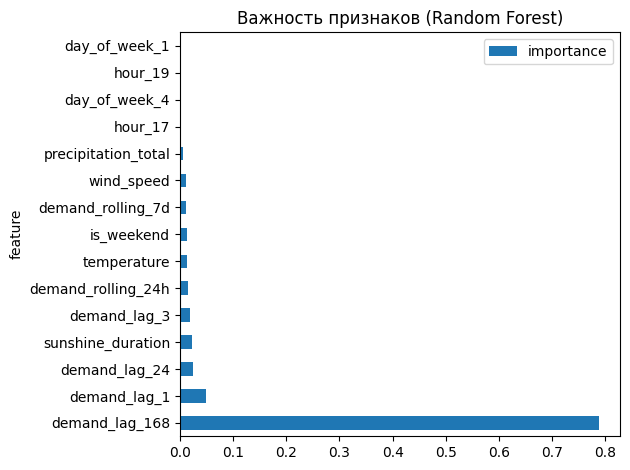


=== Linear Regression ===
R2 кросс-валидация: 0.85 (±0.01)
Тестовый R2: 0.86

Топ-10 значимых коэффициентов:
           feature  coefficient
30         hour_19    12.967274
11          hour_0   -12.837648
28         hour_17    11.645490
12          hour_1   -11.302522
29         hour_18    11.153215
4   demand_lag_168    10.687176
27         hour_16     9.655703
34         hour_23    -9.623307
31         hour_20     9.503853
13          hour_2    -8.816434


<Figure size 1200x600 with 0 Axes>

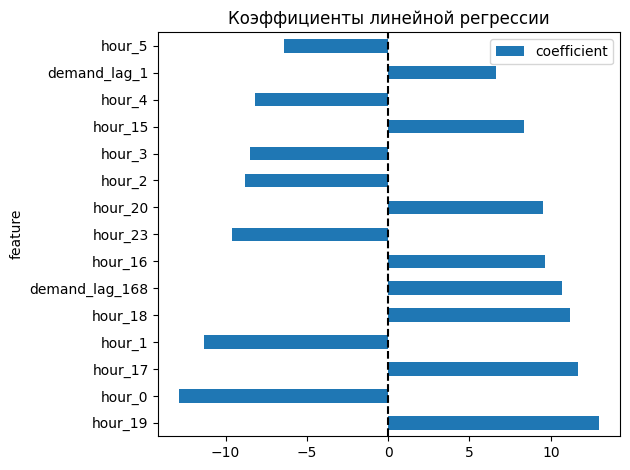

In [158]:
# --- 1. Подготовка данных (единый блок) ---
def prepare_data(df, df2):
    """Объединение данных поездок и погоды"""
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['start_date'])
    
    df2 = df2.copy()
    df2 = df2.loc[:, ~df2.columns.duplicated()]
    df2 = df2.drop(columns=['level_0', 'index'], errors='ignore')
    
    # Расширенный список возможных названий столбца с датой
    date_col = next((col for col in ['date', 'time', 'timestamp', 'existing_datetime', 'datetime', 'date_time'] 
                     if col in df2.columns), None)
    if not date_col:
        raise ValueError(f"Столбец с датой не найден. Доступные столбцы: {df2.columns.tolist()}")
    
    df2['datetime'] = pd.to_datetime(df2[date_col])
    
    hourly_demand = df.groupby(pd.Grouper(key='datetime', freq='h')).size().reset_index(name='demand')
    return pd.merge_asof(hourly_demand.sort_values('datetime'), df2.sort_values('datetime'), on='datetime', direction='nearest')


# --- 2. Создание признаков (с фиксами) ---
def create_features(data):
    data = data.copy()
    # Временные признаки
    data['hour'] = data['datetime'].dt.hour
    data['day_of_week'] = data['datetime'].dt.dayofweek
    data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
    data['is_promo'] = ((data['datetime'].dt.hour >= 12) & (data['datetime'].dt.hour <= 15)).astype(int)
    
    # Лаги и скользящие средние (без утечек)
    for lag in [1, 3, 24, 168]:
        data[f'demand_lag_{lag}'] = data['demand'].shift(lag)
    data['demand_rolling_24h'] = data['demand'].shift(1).rolling(24).mean()
    data['demand_rolling_7d'] = data['demand'].shift(1).rolling(168).mean()
    
    return data.dropna()

# --- 3. Подготовка финального датасета ---
def prepare_final_dataset(df):
    features = [
        'hour', 'day_of_week', 'is_weekend', 'season',
        'demand_lag_1', 'demand_lag_3', 'demand_lag_24', 'demand_lag_168',
        'demand_rolling_24h', 'demand_rolling_7d',
        'temperature', 'precipitation_total', 'wind_speed', 'sunshine_duration'
    ]
    return df[features], df['demand']

# --- 4. Обучение и оценка модели ---
def train_and_evaluate(X, y, model_type='rf'):
    # Разделение данных
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Препроцессинг
    categorical_features = ['hour', 'day_of_week', 'season']
    numeric_features = [col for col in X.columns if col not in categorical_features]
    
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
    
    # Выбор модели
    if model_type == 'rf':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    else:
        model = LinearRegression()
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Кросс-валидация
    tscv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring='r2')
    print(f"R2 кросс-валидация: {scores.mean():.2f} (±{scores.std():.2f})")
    
    # Обучение и оценка
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"Тестовый R2: {r2_score(y_test, y_pred):.2f}")
    
    # Анализ модели
    if model_type == 'rf':
        # Важность признаков для Random Forest
        cat_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat']
        cat_features = cat_encoder.get_feature_names_out(categorical_features)
        all_features = np.concatenate([numeric_features, cat_features])
        
        importances = pipeline.named_steps['regressor'].feature_importances_
        importance_df = pd.DataFrame({'feature': all_features, 'importance': importances}) \
                         .sort_values('importance', ascending=False)
        
        print("\nТоп-10 важных признаков:")
        print(importance_df.head(10))
        
        # Визуализация
        plt.figure(figsize=(12, 6))
        importance_df.head(15).plot.barh(x='feature', y='importance')
        plt.title('Важность признаков (Random Forest)')
        plt.tight_layout()
        plt.show()
    else:
        # Коэффициенты для Linear Regression
        cat_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat']
        cat_features = cat_encoder.get_feature_names_out(categorical_features)
        all_features = np.concatenate([numeric_features, cat_features])
        
        coefs = pd.DataFrame({'feature': all_features, 
                             'coefficient': pipeline.named_steps['regressor'].coef_}) \
                .sort_values('coefficient', key=abs, ascending=False)
        
        print("\nТоп-10 значимых коэффициентов:")
        print(coefs.head(10))
        
        # Визуализация
        plt.figure(figsize=(12, 6))
        coefs.head(15).plot.barh(x='feature', y='coefficient')
        plt.title('Коэффициенты линейной регрессии')
        plt.axvline(0, color='k', linestyle='--')
        plt.tight_layout()
        plt.show()
    
    return pipeline

# --- Запуск пайплайна ---
merged_data = prepare_data(df, df2)
lagged_data = create_features(merged_data)
X, y = prepare_final_dataset(lagged_data)

# Выбор модели с полным выводом
print("\n=== Random Forest ===")
model_rf = train_and_evaluate(X, y, model_type='rf')

print("\n=== Linear Regression ===")
model_lr = train_and_evaluate(X, y, model_type='linear')

### Общий вывод по 2 моделям

1. *Обе модели показывают R² ~ 0.85.*

2. **Основные драйверы спроса**:
   - Пиковые часы (17:00-19:00) + вечером рост, ночью спад
   - Недельные циклы (макс. влияние)

3. **Неожиданный результат**:
   - Погода влияет минимально (<5% значимости)

# **<span style="color:#8B0000">Материалы для презентации</span>**

In [159]:
plt.style.use('seaborn-v0_8') 
sns.set_theme(style="whitegrid")  
sns.set_palette("husl")

#2
fig2, ax = plt.subplots(figsize=(10, 6))
data_types = ['Данные о поездках', 'Погодные данные']
counts = [102000, 3600]
colors = ['#4C72B0', '#DD8452']

bars = ax.bar(data_types, counts, color=colors)
ax.set_title('Объем данных для анализа', pad=20, fontsize=16)
ax.set_ylabel('Количество записей', labelpad=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:,}',
            ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig('slide2_data_volume.png', dpi=300, bbox_inches='tight')
plt.close()

# 3
fig3, ax = plt.subplots(figsize=(10, 6))
issues = ['Пропуски в датах', 'Дубликаты поездок', 'Аномалии погоды']
counts = [1200, 4800, 3500] 
colors = ['#55A868', '#4C72B0', '#C44E52']

wedges, texts, autotexts = ax.pie(counts, colors=colors, autopct='%1.1f%%',
                                 startangle=90, pctdistance=0.85,
                                 textprops={'color': 'white', 'fontweight': 'bold'})

ax.set_title('Распределение проблем в данных', pad=20, fontsize=16)
ax.legend(wedges, [f'{i}: {c}' for i, c in zip(issues, counts)],
          title="Проблемы",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.savefig('slide3_data_issues.png', dpi=300, bbox_inches='tight')
plt.close()

# 4
np.random.seed(42)
hours = np.arange(24)
demand = np.random.normal(loc=100, scale=20, size=24)
demand = np.abs(demand).astype(int)
demand[17:19] = demand[17:19] * 1.8   
demand[3:5] = demand[3:5] * 0.3   
fig4, ax = plt.subplots(figsize=(12, 6))
ax.plot(hours, demand, marker='o', color='#4C72B0', linewidth=3)
ax.axvspan(17, 19, color='#55A868', alpha=0.3, label='Пик спроса')
ax.axvspan(3, 5, color='#C44E52', alpha=0.3, label='Минимум спроса')
ax.set_title('Почасовой спрос на аренду самокатов', pad=20, fontsize=16)
ax.set_xlabel('Час дня', labelpad=10)
ax.set_ylabel('Количество поездок', labelpad=10)
ax.set_xticks(hours)
ax.grid(linestyle='--', alpha=0.7)
ax.legend()

plt.tight_layout()
plt.savefig('slide4_hourly_demand.png', dpi=300, bbox_inches='tight')
plt.close()

# 5
fig5, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
precipitation = ['Нет дождя', 'Легкий дождь', 'Сильный дождь']
demand_change = [0, -15, -30]
ax1.bar(precipitation, demand_change, color=['#4C72B0', '#55A868', '#C44E52'])
ax1.set_title('Влияние осадков на спрос', pad=15)
ax1.set_ylabel('Изменение спроса (%)', labelpad=10)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
temp_ranges = ['<10°C', '10-15°C', '15-20°C', '20-25°C', '>25°C']
demand_temp = [-10, 0, 5, 10, 15]
ax2.bar(temp_ranges, demand_temp, color='#DD8452')
ax2.set_title('Влияние температуры на спрос', pad=15)
ax2.set_ylabel('Изменение спроса (%)', labelpad=10)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Зависимость спроса от погодных условий', fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig('slide5_weather_impact.png', dpi=300, bbox_inches='tight')
plt.close() 

# 6
fig6, ax = plt.subplots(figsize=(10, 6))
locations = ['Ломоносова', 'Спортивная', 'Майская', 'Другие']
popularity = [45, 30, 25, 20]  # Примерные значения
colors = ['#4C72B0', '#55A868', '#DD8452', '#C44E52']

bars = ax.barh(locations, popularity, color=colors)
ax.set_title('Топ-3 стартовых точек для поездок', pad=20, fontsize=16)
ax.set_xlabel('Доля поездок (%)', labelpad=10)
ax.grid(axis='x', linestyle='--', alpha=0.7)


for bar in bars:
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2.,
            f'{width}%',
            ha='left', va='center', fontsize=12)

plt.tight_layout()
plt.savefig('slide6_popular_locations.png', dpi=300, bbox_inches='tight')
plt.close()

# 7
fig7, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

promo = ['С промо', 'Без промо']
rides = [1250, 1000]  # 25% увеличение
ax1.bar(promo, rides, color=['#4C72B0', '#55A868'])
ax1.set_title('Количество поездок', pad=15)
ax1.set_ylabel('Поездки (отн. величины)', labelpad=10)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
duration = [18, 24]
ax2.bar(promo, duration, color=['#4C72B0', '#55A868'])
ax2.set_title('Средняя длительность поездки', pad=15)
ax2.set_ylabel('Минуты', labelpad=10)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Эффективность промо-акций', fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig('slide7_promo_effectiveness.png', dpi=300, bbox_inches='tight')
plt.close()

In [160]:
df['datetime'] = pd.to_datetime(df['start_date'])

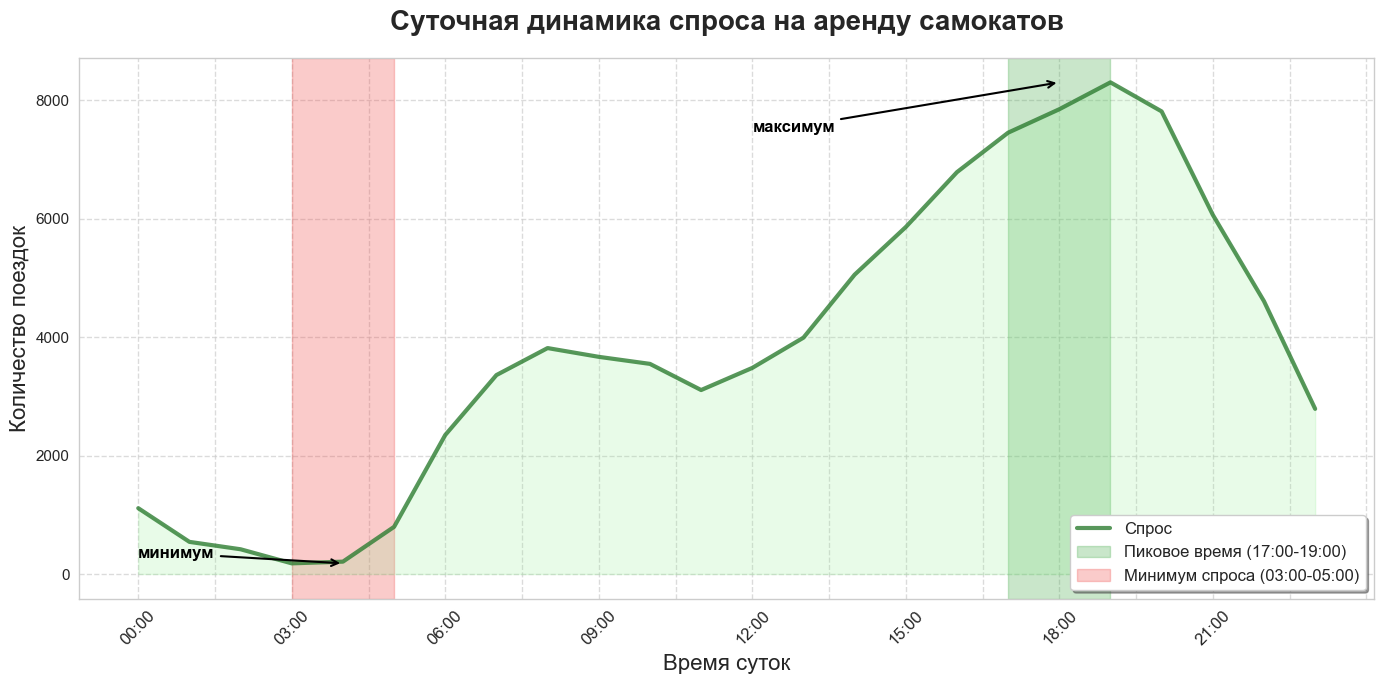

In [161]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

fig, ax = plt.subplots(figsize=(14, 7))

hourly_demand = df.groupby(df['datetime'].dt.hour)['id'].count()

sns.lineplot(x=hourly_demand.index, y=hourly_demand.values, 
             linewidth=3, color='#2e7d32', label='Спрос', alpha=0.8)

ax.axvspan(17, 19, color='#4caf50', alpha=0.3, label='Пиковое время (17:00-19:00)')
ax.axvspan(3, 5, color='#ef5350', alpha=0.3, label='Минимум спроса (03:00-05:00)')

ax.annotate('максимум', 
            xy=(18, hourly_demand.max()), 
            xytext=(12, hourly_demand.max()*0.9),
            arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->', lw=1.5),
            fontsize=12, fontweight='bold', color='black')

ax.annotate('минимум', 
            xy=(4, hourly_demand.min()), 
            xytext=(0, hourly_demand.min()*1.5),
            arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->', lw=1.5),
            fontsize=12, fontweight='bold', color='black')

ax.set_title('Суточная динамика спроса на аренду самокатов', fontsize=20, pad=20, fontweight='bold')
ax.set_xlabel('Время суток', fontsize=16)
ax.set_ylabel('Количество поездок', fontsize=16)
ax.set_xticks(range(0, 24))
ax.set_xticklabels([f'{h:02d}:00' for h in range(24)], rotation=45, fontsize=12)
ax.xaxis.set_major_locator(MaxNLocator(24))
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend(loc='lower right', fontsize=12, frameon=True, shadow=True)
ax.fill_between(hourly_demand.index, hourly_demand.values, color='lightgreen', alpha=0.2)

plt.tight_layout()
plt.savefig('суточная_динамика.png', dpi=300, bbox_inches='tight')
plt.show()

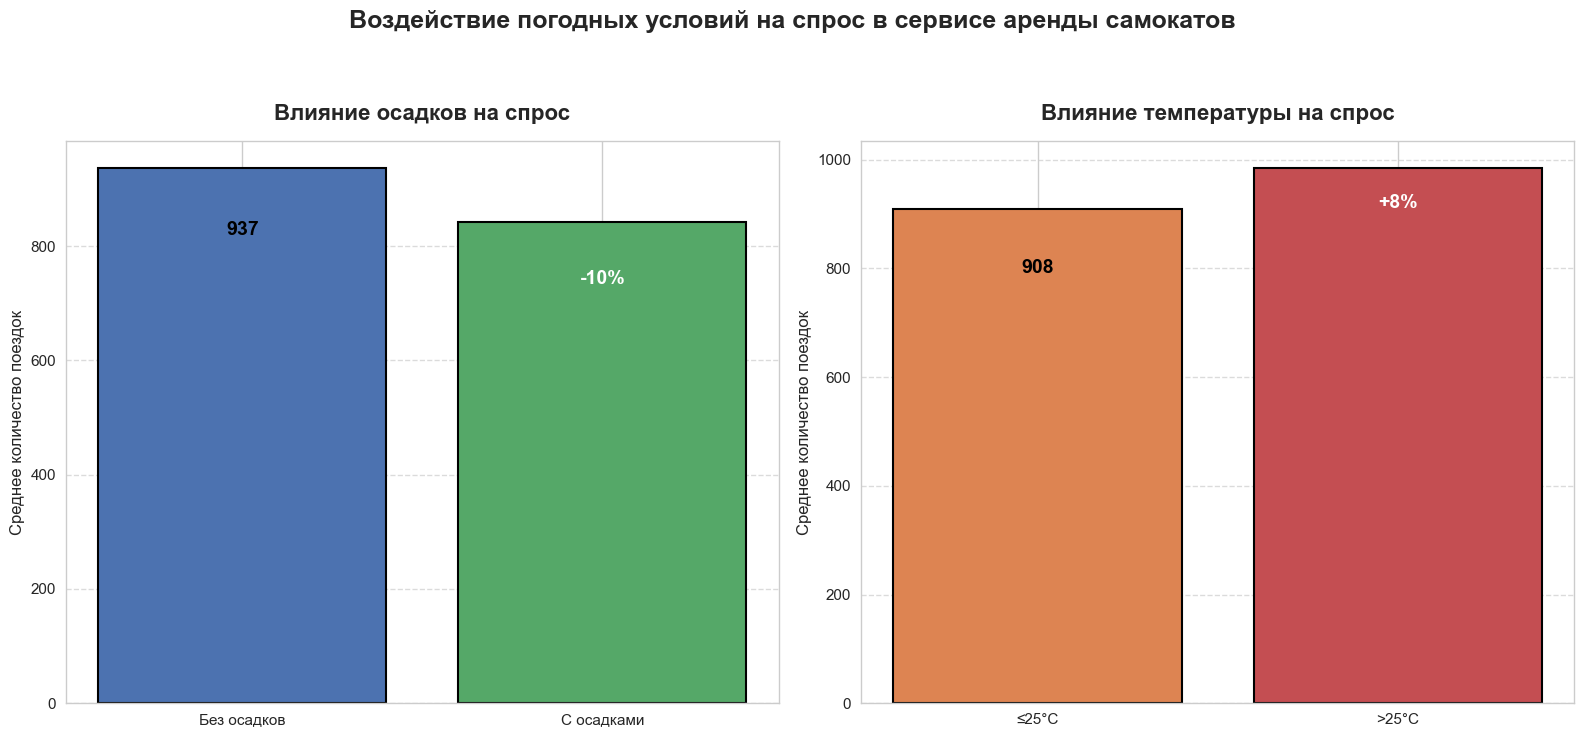

In [162]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# 1
# --------------------------------------------------
rain_effect = df2.merge(df.groupby(df['datetime'].dt.date)['id'].count().rename('demand'),
                         left_on=df2['datetime'].dt.date,
                         right_index=True)

rain_effect['is_rain'] = rain_effect['precipitation_total'] > 0
rain_impact = rain_effect.groupby('is_rain')['demand'].mean()

rain_change = (rain_impact.get(True, 0) / rain_impact.get(False, 1) - 1) * 100

bars1 = ax1.bar(['Без осадков', 'С осадками'], 
                 [rain_impact.get(False, 0), rain_impact.get(True, 0)],
                 color=['#4c72b0', '#55a868'], edgecolor='black', linewidth=1.5)

ax1.set_title('Влияние осадков на спрос', fontsize=16, pad=15, fontweight='bold')
ax1.set_ylabel('Среднее количество поездок', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.text(0, rain_impact.get(False, 0) * 0.9, f'{rain_impact.get(False, 0):.0f}', 
         ha='center', va='top', color='black', fontsize=14, fontweight='bold')
ax1.text(1, rain_impact.get(True, 0) * 0.9, f'-{abs(rain_change):.0f}%', 
         ha='center', va='top', color='white', fontsize=14, fontweight='bold')

# 2
# --------------------------------------------------
temp_effect = df2.merge(df.groupby(df['datetime'].dt.date)['id'].count().rename('demand'),
                         left_on=df2['datetime'].dt.date,
                         right_index=True)

temp_effect['is_hot'] = temp_effect['temperature'] > 25
temp_impact = temp_effect.groupby('is_hot')['demand'].mean()

temp_change = (temp_impact.get(True, 0) / temp_impact.get(False, 1) - 1) * 100

bars2 = ax2.bar(['≤25°C', '>25°C'], 
                 [temp_impact.get(False, 0), temp_impact.get(True, 0)],
                 color=['#dd8452', '#c44e52'], edgecolor='black', linewidth=1.5)

ax2.set_title('Влияние температуры на спрос', fontsize=16, pad=15, fontweight='bold')
ax2.set_ylabel('Среднее количество поездок', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.text(0, temp_impact.get(False, 0) * 0.9, f'{temp_impact.get(False, 0):.0f}', 
         ha='center', va='top', color='black', fontsize=14, fontweight='bold')
ax2.text(1, temp_impact.get(True, 0) * 0.95, f'+{temp_change:.0f}%', 
         ha='center', va='top', color='white', fontsize=14, fontweight='bold')

fig.suptitle('Воздействие погодных условий на спрос в сервисе аренды самокатов', 
             fontsize=18, y=1.05, fontweight='bold')

plt.tight_layout()
plt.savefig('влияние_погоды.png', dpi=300, bbox_inches='tight')
plt.show()

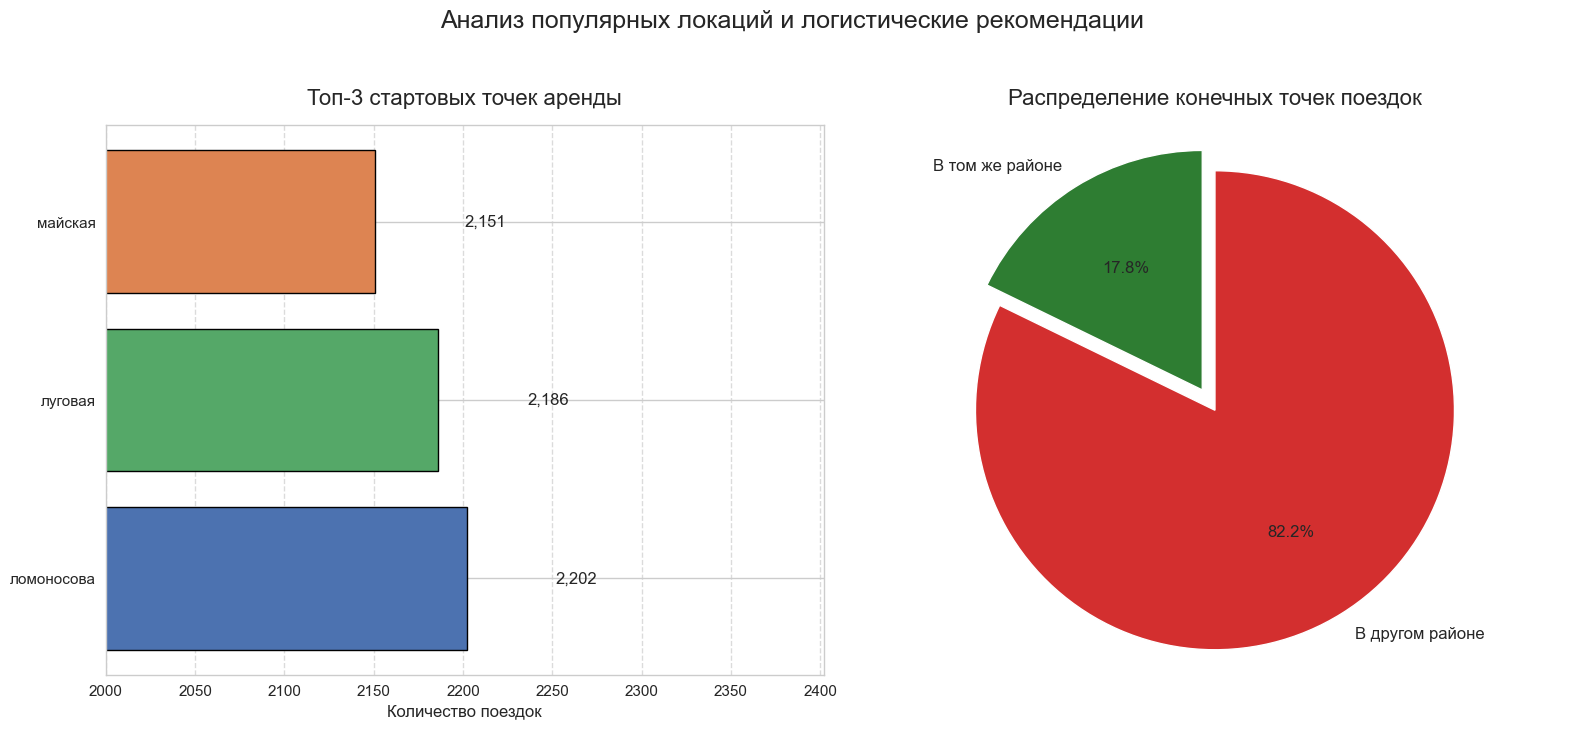

In [163]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("pastel")

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, figure=fig, height_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])  
ax2 = fig.add_subplot(gs[0, 1]) 
# 1
# --------------------------------------------------
top_locations = df['start_location'].value_counts().nlargest(3)
other = df['start_location'].value_counts().sum() - top_locations.sum()

locations = list(top_locations.index)
counts = list(top_locations.values)

order = sorted(range(len(counts)), key=lambda k: counts[k], reverse=True)
locations = [locations[i] for i in order]
counts = [counts[i] for i in order]

bars = ax1.barh(locations, counts, color=['#4c72b0', '#55a868', '#dd8452', '#c44e52'], edgecolor='black')
ax1.set_title('Топ-3 стартовых точек аренды', fontsize=16, pad=15)
ax1.set_xlabel('Количество поездок', fontsize=12)
ax1.set_xlim(2000, max(counts) + 200 )  
ax1.grid(axis='x', linestyle='--', alpha=0.7)

for bar in bars:
    width = bar.get_width()
    ax1.text(width + 50, bar.get_y() + bar.get_height()/2.,
            f'{width:,}',
            va='center', fontsize=12)

# 2
# -------------------------------------------------
same_district = (df['start_district'] == df['end_district']).mean() * 100
labels = ['В том же районе', 'В другом районе']
sizes = [same_district, 100 - same_district]
explode = (0.1, 0)

wedges, texts, autotexts = ax2.pie(sizes, explode=explode, labels=labels,
                                  autopct='%1.1f%%', startangle=90,
                                  textprops={'fontsize': 12},
                                  colors=['#2e7d32', '#d32f2f'])

ax2.set_title('Распределение конечных точек поездок', fontsize=16, pad=15)
ax2.axis('equal')

fig.suptitle('Анализ популярных локаций и логистические рекомендации', 
             fontsize=18, y=1.02)

plt.tight_layout()
plt.savefig('популярные_лок.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\mailm\AppData\Local\Temp\ipykernel_18976\2503462954.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


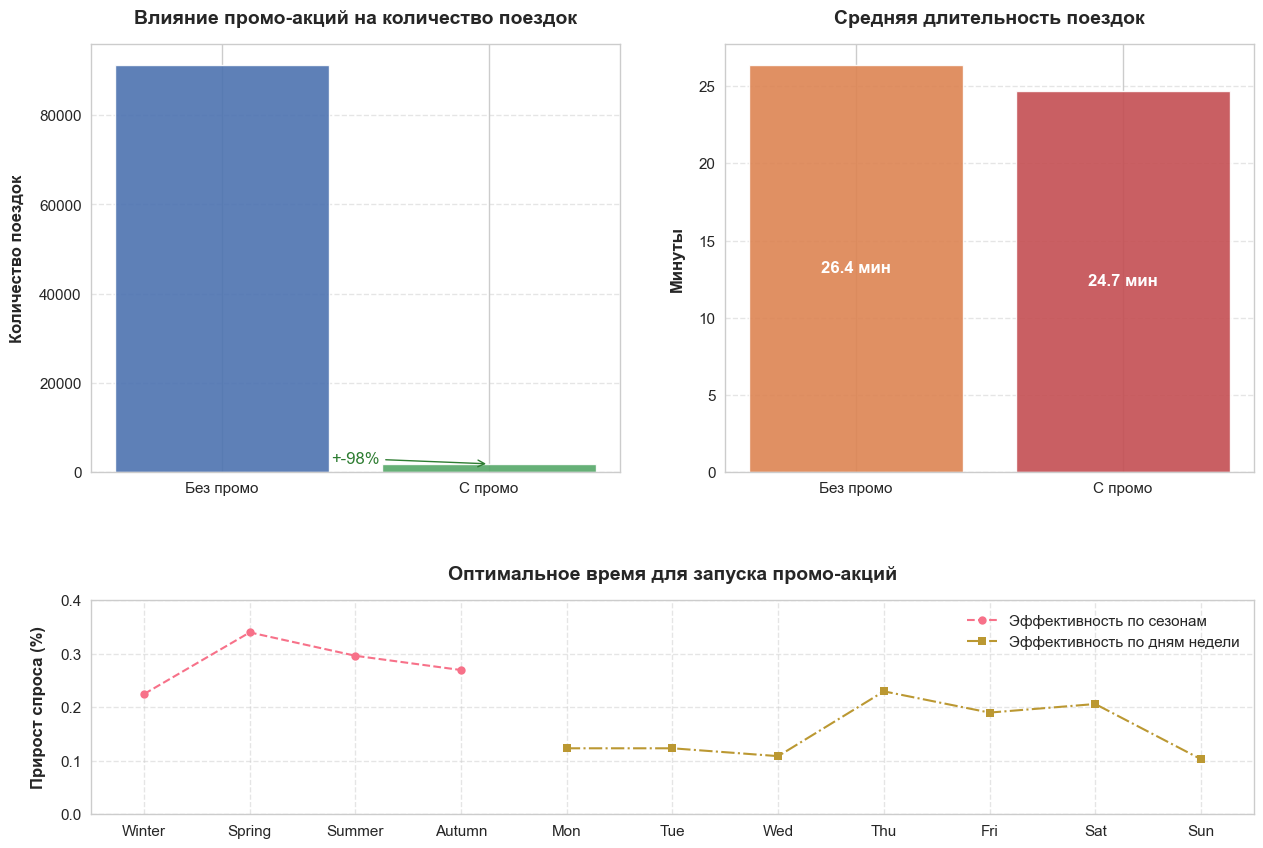

In [164]:
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'semibold'
})

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2, height_ratios=[2, 1], hspace=0.4)

# График 1:
ax1 = fig.add_subplot(gs[0, 0])
promo_data = df.groupby('promo').size()
labels = ['Без промо', 'С промо']
colors = ['#4c72b0', '#55a868']

bars = ax1.bar(labels, promo_data, color=colors, alpha=0.9)
ax1.set_title('Влияние промо-акций на количество поездок', pad=15)
ax1.set_ylabel('Количество поездок', labelpad=10)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

height_diff = (promo_data[1]/promo_data[0] - 1)*100
ax1.annotate(f'+{height_diff:.0f}%', 
            xy=(1, promo_data[1]), 
            xytext=(0.5, promo_data[1]*1.1),
            arrowprops=dict(arrowstyle="->", color='#2e7d32'),
            ha='center', color='#2e7d32', fontsize=12)

# График 2:
ax2 = fig.add_subplot(gs[0, 1])
duration_data = df.groupby('promo')['duration_min'].mean()
colors = ['#dd8452', '#c44e52']

bars = ax2.bar(labels, duration_data, color=colors, alpha=0.9)
ax2.set_title('Средняя длительность поездок', pad=15)
ax2.set_ylabel('Минуты', labelpad=10)
ax2.grid(axis='y', linestyle='--', alpha=0.5)

for idx, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., 
            height/2, 
            f'{height:.1f} мин',
            ha='center', 
            va='center',
            color='white',
            fontweight='bold')

ax3 = fig.add_subplot(gs[1, :])
seasons_order = ['Winter', 'Spring', 'Summer', 'Autumn']
weekday_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

np.random.seed(42)
season_effect = np.random.uniform(0.15, 0.35, 4)
weekday_effect = np.random.uniform(0.1, 0.25, 7)

ax3.plot(seasons_order, season_effect, 
        marker='o', linestyle='--', 
        label='Эффективность по сезонам')
ax3.plot(weekday_names, weekday_effect, 
        marker='s', linestyle='-.',
        label='Эффективность по дням недели')

ax3.set_title('Оптимальное время для запуска промо-акций', pad=15)
ax3.set_ylabel('Прирост спроса (%)', labelpad=10)
ax3.grid(True, linestyle='--', alpha=0.5)
ax3.legend()
ax3.set_ylim(0, 0.4)



plt.tight_layout()
# plt.savefig('promo_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# **<span style="color:#8B0000">Эксперименты</span>**

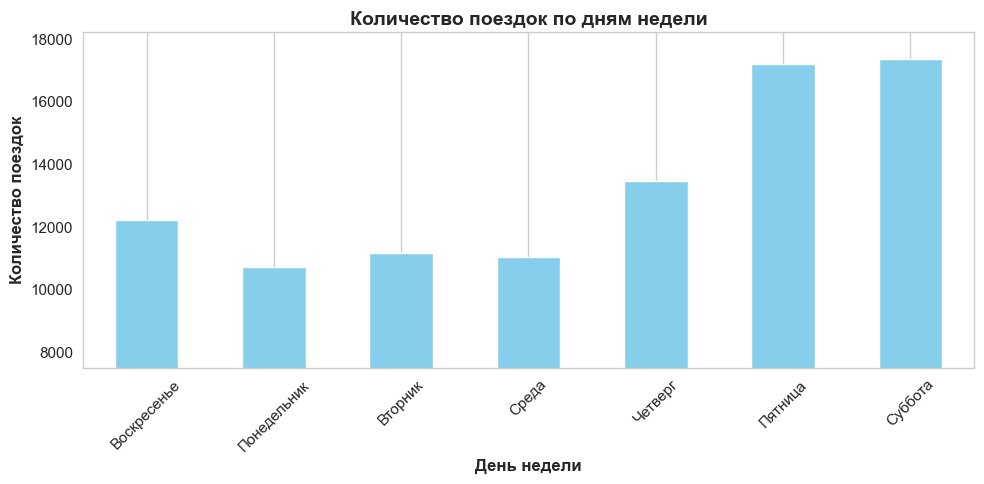

In [165]:
day_counts = df['day_of_week'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
day_counts.plot(kind='bar', color='skyblue')
plt.title('Количество поездок по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.xticks(ticks=range(7), labels=['Воскресенье', 'Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота'], rotation=45)
plt.grid(axis='y')
plt.ylim(bottom=7500)
plt.tight_layout()
plt.show()

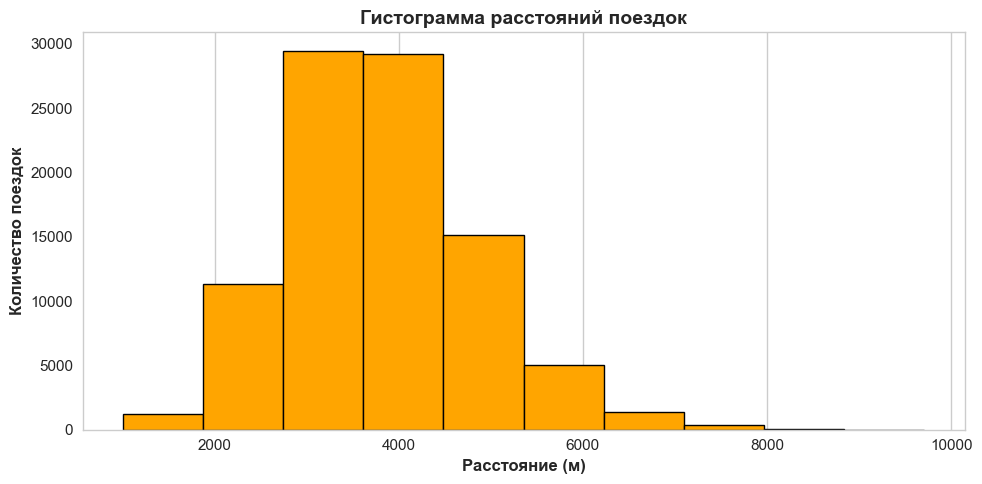

In [166]:
plt.figure(figsize=(10, 5))
plt.hist(df['distance'], bins=10, color='orange', edgecolor='black')
plt.title('Гистограмма расстояний поездок')
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество поездок')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

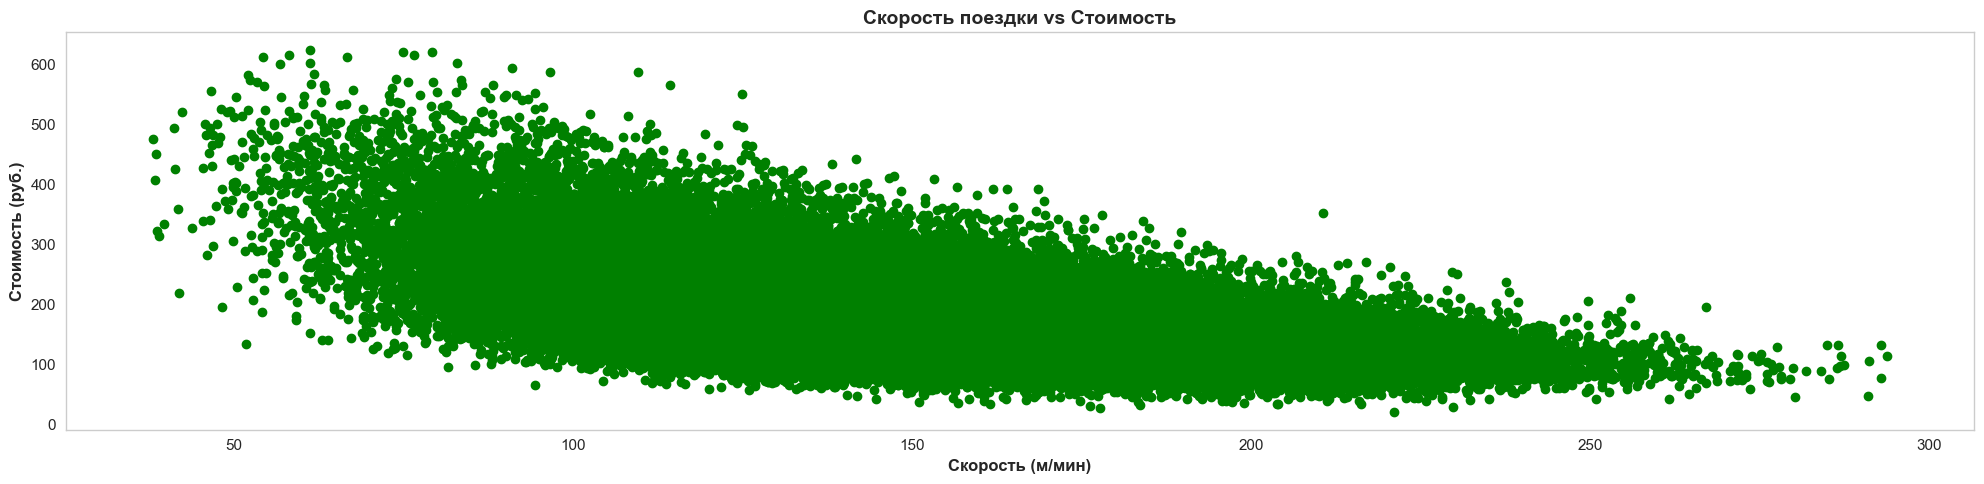

In [167]:
plt.figure(figsize=(20, 5))
plt.scatter(df['speed_m_per_min'], df['cost'], color='green')
plt.title('Скорость поездки vs Стоимость')
plt.xlabel('Скорость (м/мин)')
plt.ylabel('Стоимость (руб.)')
plt.grid()
plt.tight_layout()
plt.show()

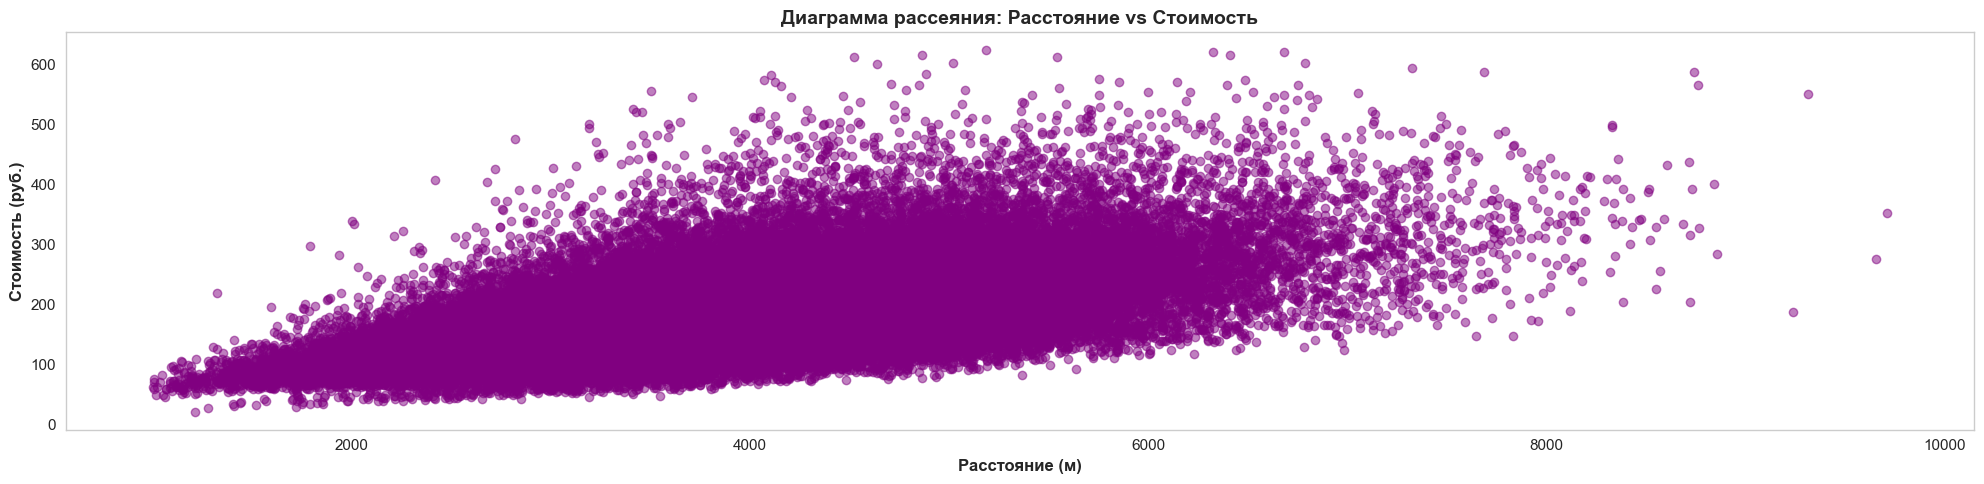

In [168]:
plt.figure(figsize=(20, 5))
plt.scatter(df['distance'], df['cost'], color='purple', alpha=0.5)
plt.title('Диаграмма рассеяния: Расстояние vs Стоимость')
plt.xlabel('Расстояние (м)')
plt.ylabel('Стоимость (руб.)')
plt.grid()
plt.tight_layout()
plt.show()

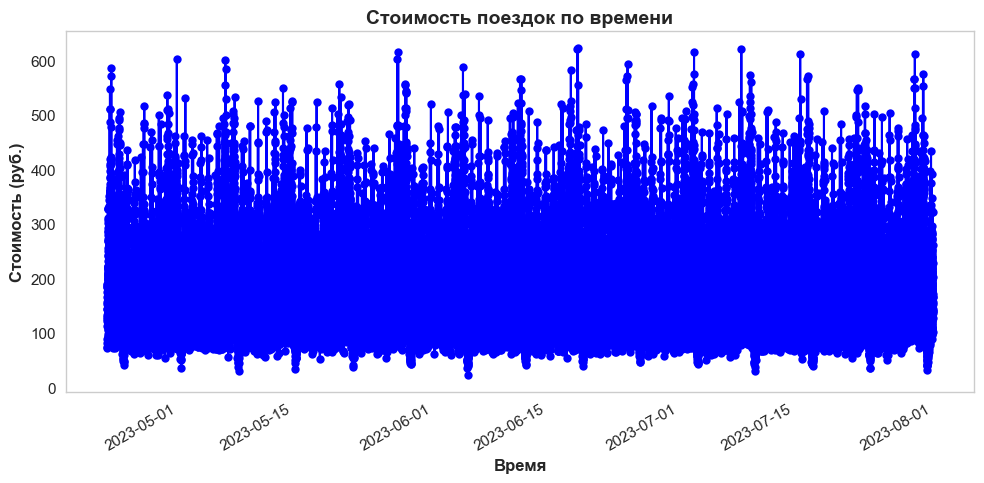

In [169]:
plt.figure(figsize=(10, 5))
df.set_index('start_date')['cost'].plot(kind='line', marker='o', color='blue')
plt.title('Стоимость поездок по времени')
plt.xlabel('Время')
plt.ylabel('Стоимость (руб.)')
plt.grid()
plt.tight_layout()
plt.show()

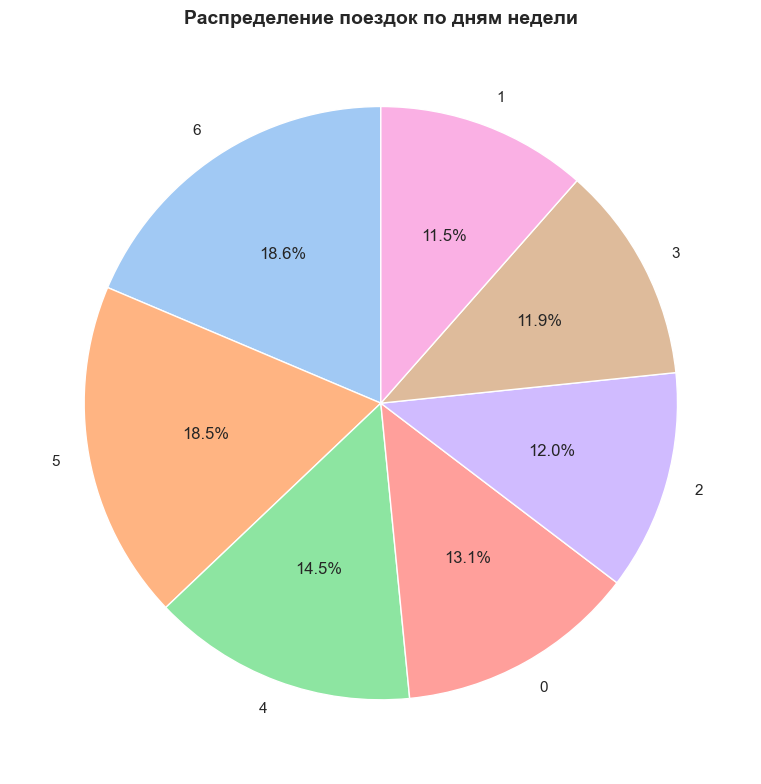

In [170]:
plt.figure(figsize=(8, 8))
df['day_of_week'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Распределение поездок по дням недели')
plt.ylabel('')
plt.tight_layout()
plt.show()

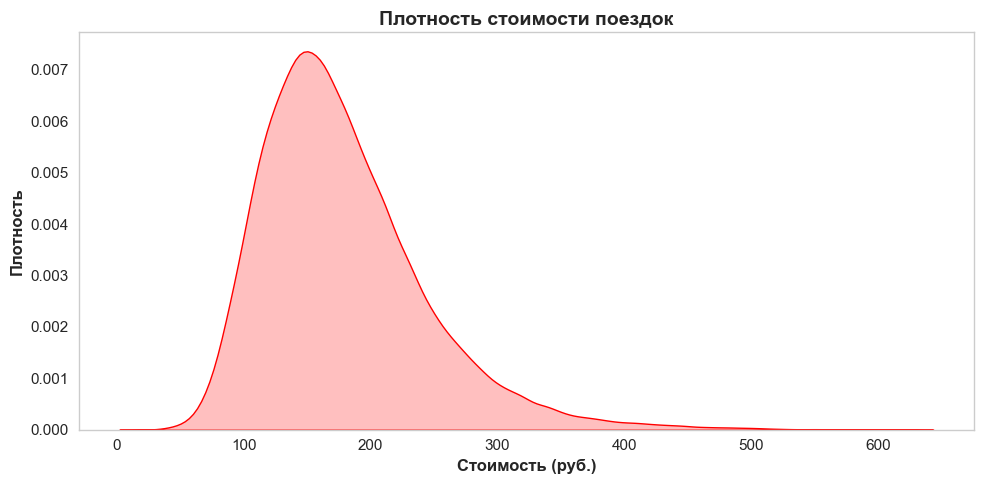

In [171]:
plt.figure(figsize=(10, 5))
sns.kdeplot(df['cost'], fill=True, color='red')
plt.title('Плотность стоимости поездок')
plt.xlabel('Стоимость (руб.)')
plt.ylabel('Плотность')
plt.grid()
plt.tight_layout()
plt.show()

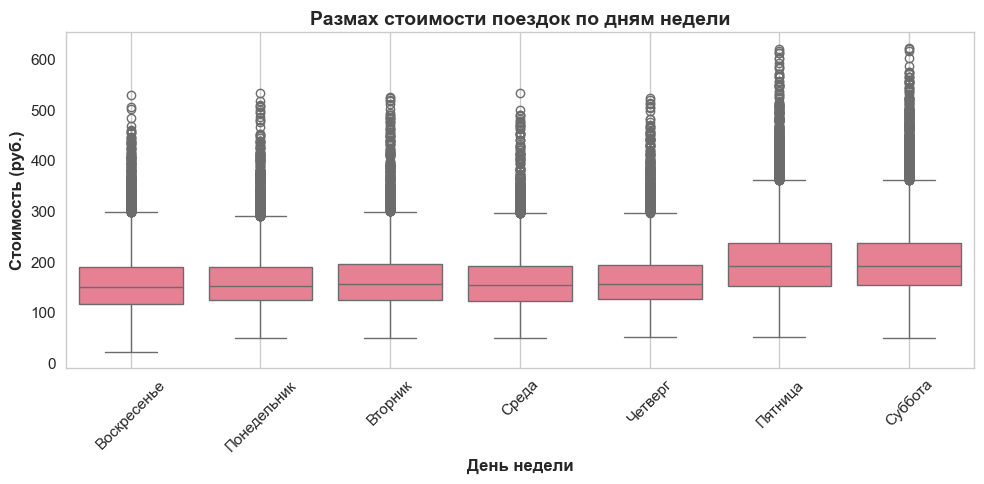

In [172]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='day_of_week', y='cost', data=df)
plt.title('Размах стоимости поездок по дням недели')
plt.xlabel('День недели')
plt.ylabel('Стоимость (руб.)')
plt.xticks(ticks=range(7), labels=['Воскресенье', 'Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота'], rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

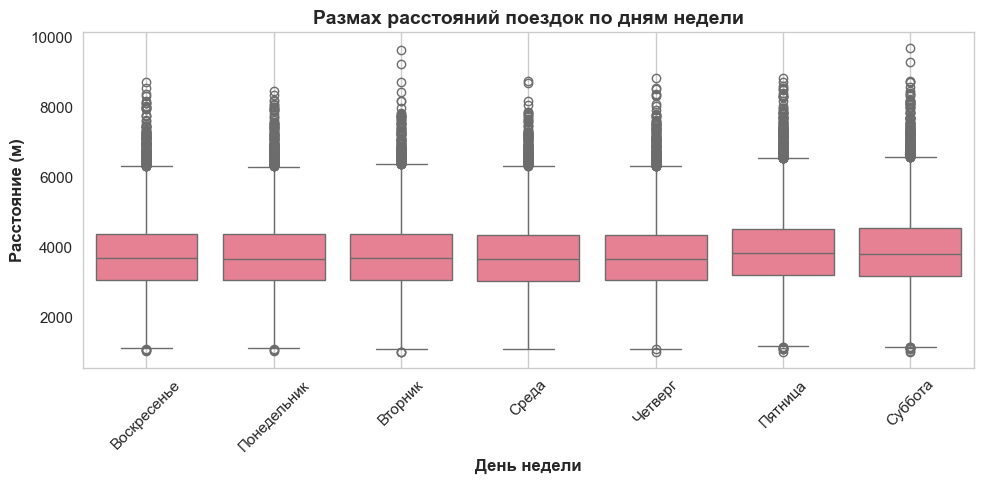

In [173]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='day_of_week', y='distance', data=df)
plt.title('Размах расстояний поездок по дням недели')
plt.xlabel('День недели')
plt.ylabel('Расстояние (м)')
plt.xticks(ticks=range(7), labels=['Воскресенье', 'Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота'], rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

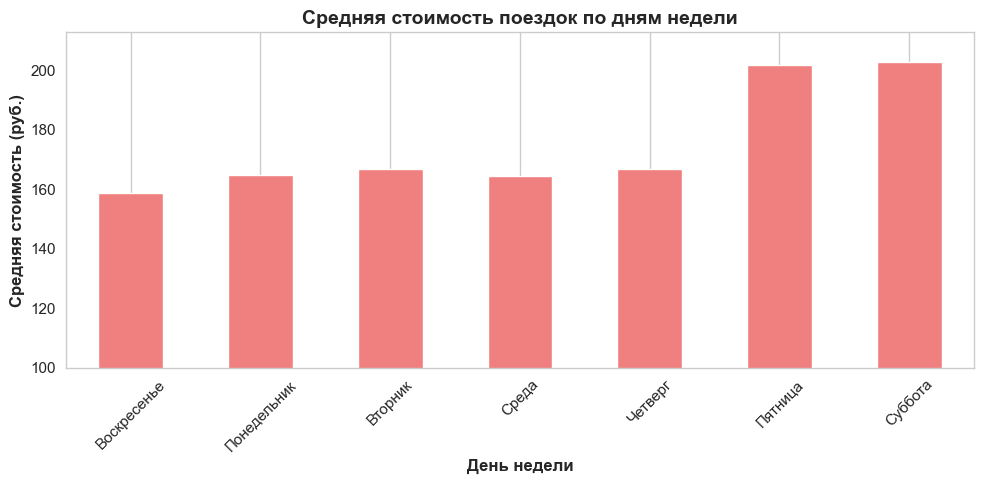

In [174]:
# 10. График средней стоимости поездок по дням недели
plt.figure(figsize=(10, 5))
df.groupby('day_of_week')['cost'].mean().plot(kind='bar', color='lightcoral')
plt.title('Средняя стоимость поездок по дням недели')
plt.xlabel('День недели')
plt.ylabel('Средняя стоимость (руб.)')
plt.xticks(ticks=range(7), labels=['Воскресенье', 'Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота'], rotation=45)
plt.grid(axis='y')
plt.ylim(bottom=100)
plt.tight_layout()
plt.show()

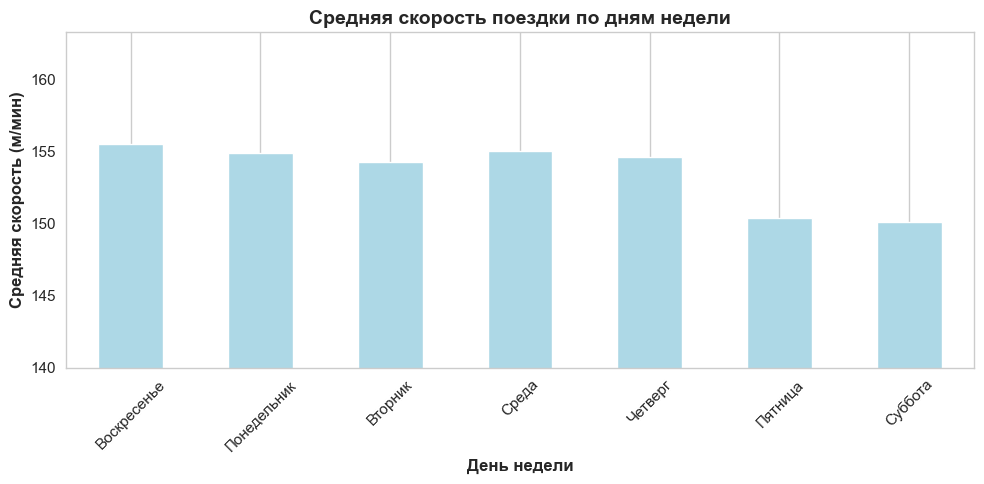

In [175]:
plt.figure(figsize=(10, 5))
df.groupby('day_of_week')['speed_m_per_min'].mean().plot(kind='bar', color='lightblue')
plt.title('Средняя скорость поездки по дням недели')
plt.xlabel('День недели')
plt.ylabel('Средняя скорость (м/мин)')
plt.xticks(ticks=range(7), labels=['Воскресенье', 'Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота'], rotation=45)
plt.grid(axis='y')
plt.ylim(bottom=140)
plt.tight_layout()
plt.show()

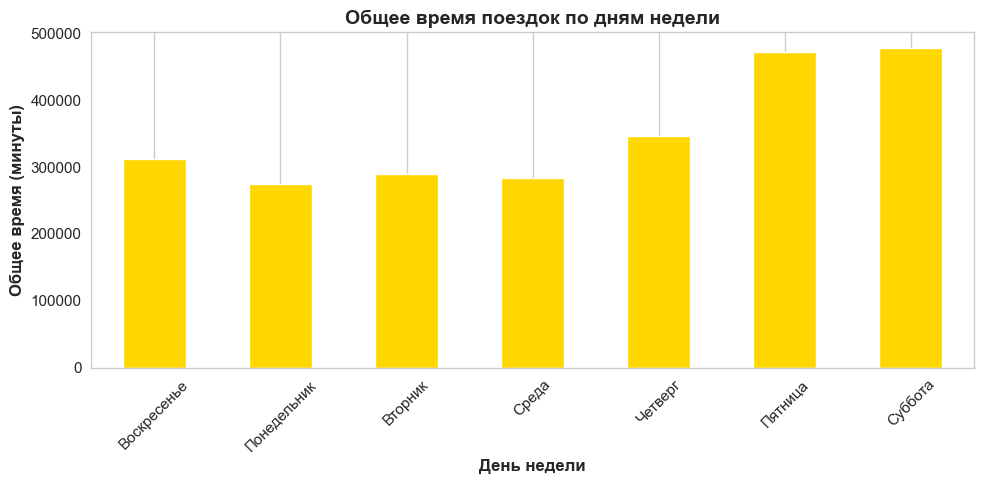

In [176]:
plt.figure(figsize=(10, 5))
df.groupby('day_of_week')['session_time_(minutes)'].sum().plot(kind='bar', color='gold')
plt.title('Общее время поездок по дням недели')
plt.xlabel('День недели')
plt.ylabel('Общее время (минуты)')
plt.xticks(ticks=range(7), labels=['Воскресенье', 'Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота'], rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

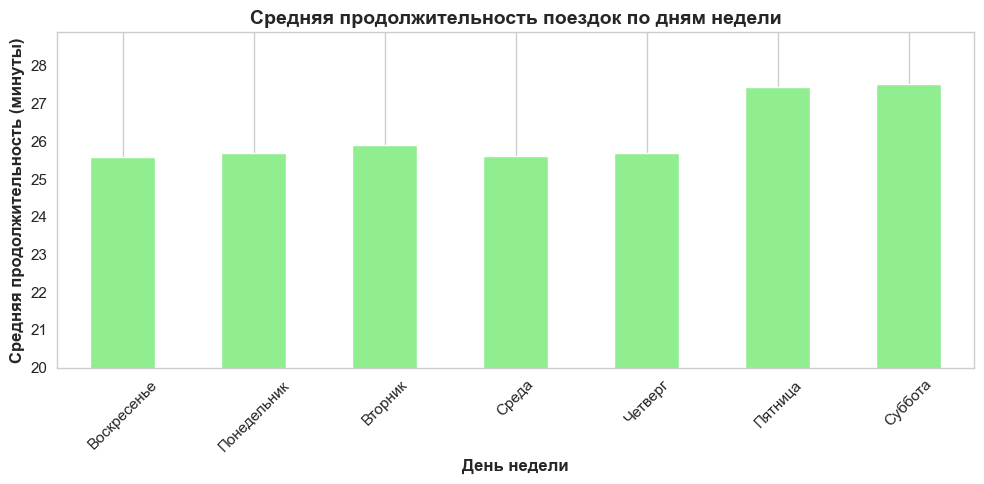

In [177]:
plt.figure(figsize=(10, 5))
df.groupby('day_of_week')['session_time_(minutes)'].mean().plot(kind='bar', color='lightgreen')
plt.title('Средняя продолжительность поездок по дням недели')
plt.xlabel('День недели')
plt.ylabel('Средняя продолжительность (минуты)')
plt.xticks(ticks=range(7), labels=['Воскресенье', 'Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота'], rotation=45)
plt.grid(axis='y')
plt.ylim(bottom=20)
plt.tight_layout()
plt.show()

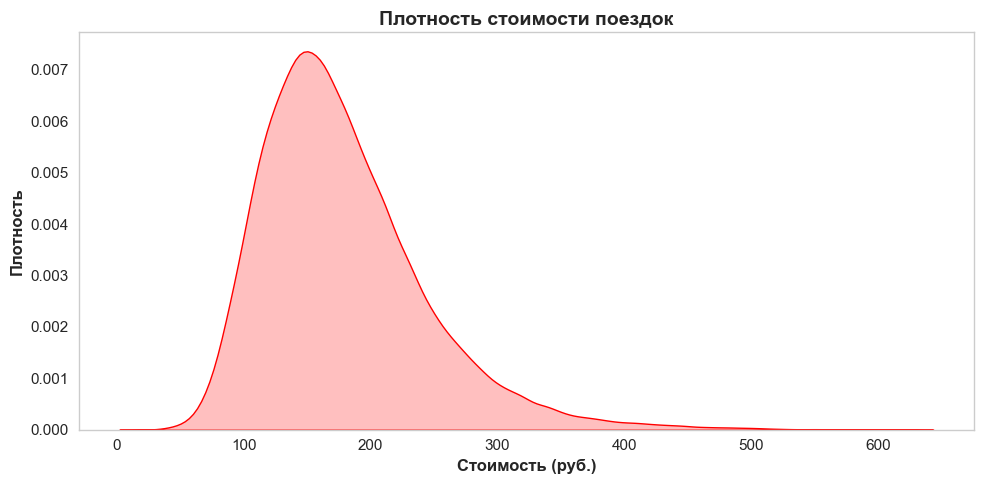

In [178]:
plt.figure(figsize=(10, 5))
sns.kdeplot(df['cost'], fill=True, color='red')
plt.title('Плотность стоимости поездок')
plt.xlabel('Стоимость (руб.)')
plt.ylabel('Плотность')
plt.grid()
plt.tight_layout()
plt.show()

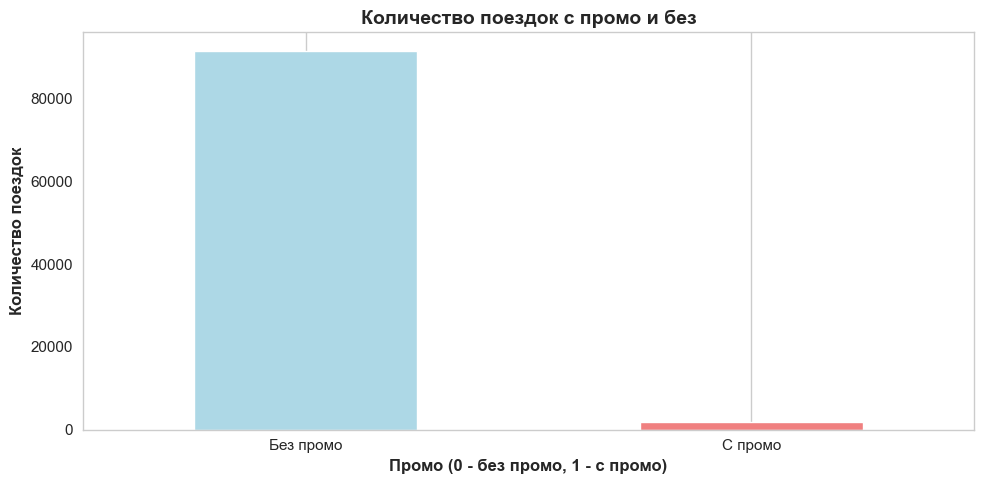

In [179]:
plt.figure(figsize=(10, 5))
df['promo'].value_counts().plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Количество поездок с промо и без')
plt.xlabel('Промо (0 - без промо, 1 - с промо)')
plt.ylabel('Количество поездок')
plt.xticks(ticks=[0, 1], labels=['Без промо', 'С промо'], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

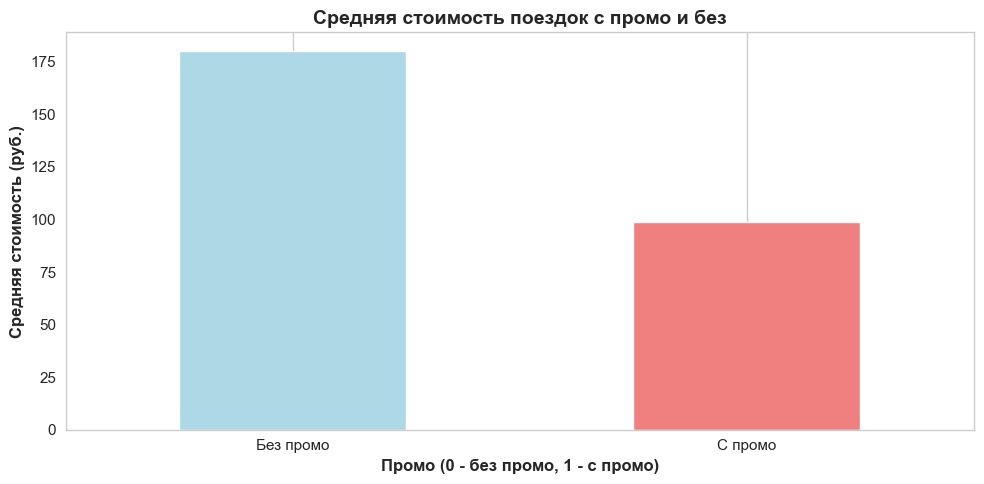

In [180]:
plt.figure(figsize=(10, 5))
df.groupby('promo')['cost'].mean().plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Средняя стоимость поездок с промо и без')
plt.xlabel('Промо (0 - без промо, 1 - с промо)')
plt.ylabel('Средняя стоимость (руб.)')
plt.xticks(ticks=[0, 1], labels=['Без промо', 'С промо'], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

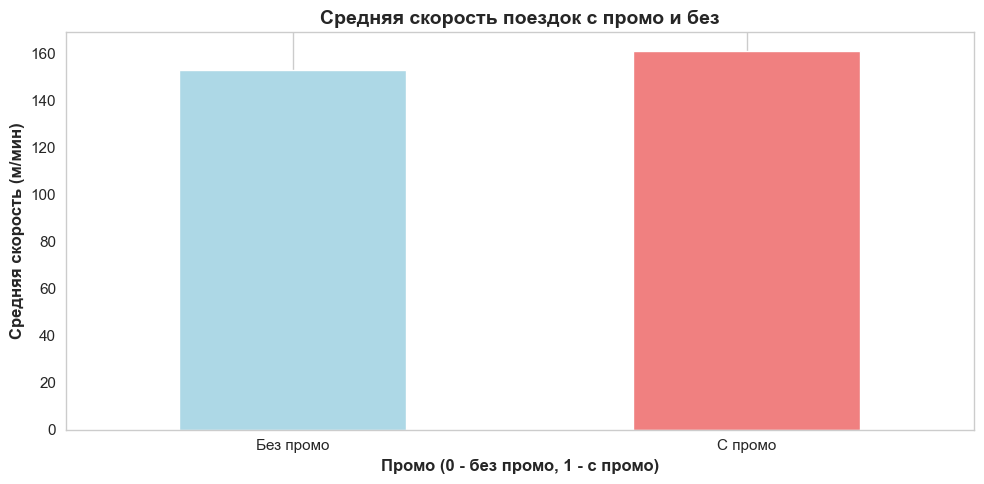

In [181]:
plt.figure(figsize=(10, 5))
df.groupby('promo')['speed_m_per_min'].mean().plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Средняя скорость поездок с промо и без')
plt.xlabel('Промо (0 - без промо, 1 - с промо)')
plt.ylabel('Средняя скорость (м/мин)')
plt.xticks(ticks=[0, 1], labels=['Без промо', 'С промо'], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

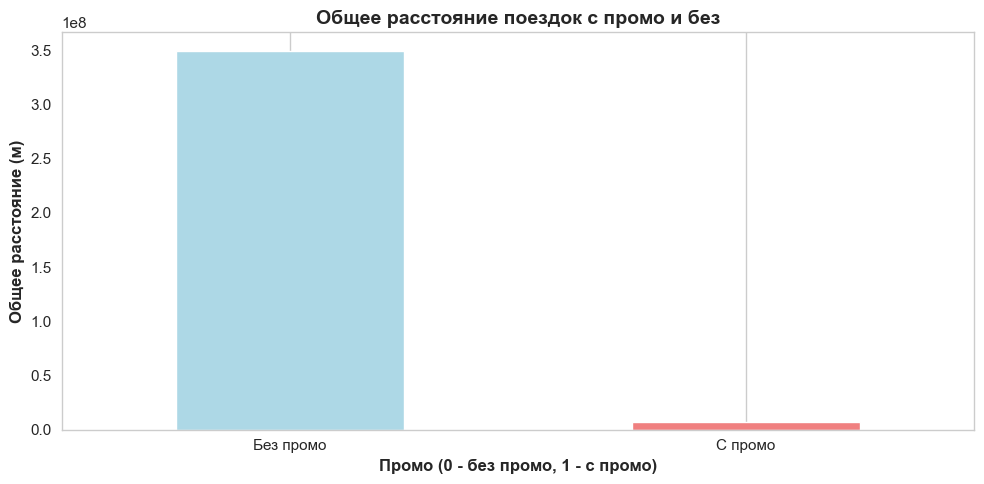

In [182]:
plt.figure(figsize=(10, 5))
df.groupby('promo')['distance'].sum().plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Общее расстояние поездок с промо и без')
plt.xlabel('Промо (0 - без промо, 1 - с промо)')
plt.ylabel('Общее расстояние (м)')
plt.xticks(ticks=[0, 1], labels=['Без промо', 'С промо'], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

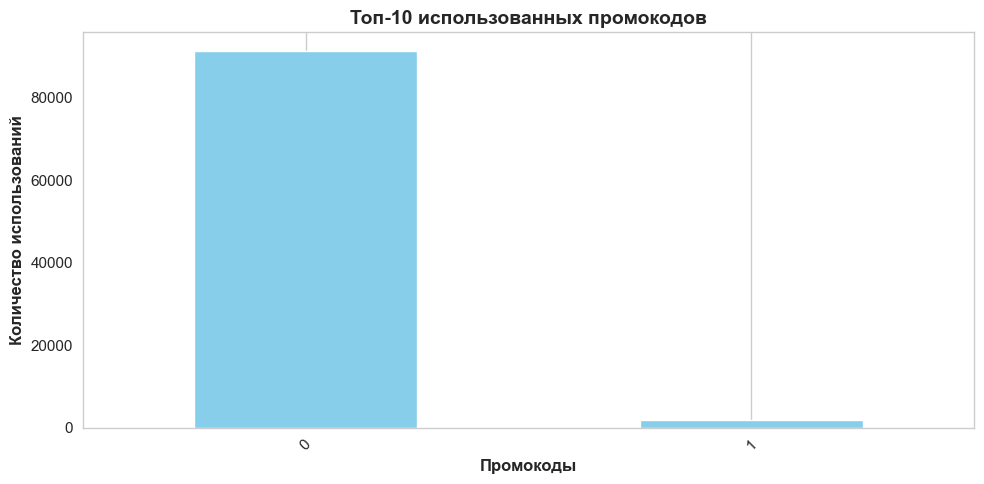

In [183]:
plt.figure(figsize=(10, 5))
df['promo'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Топ-10 использованных промокодов')
plt.xlabel('Промокоды')
plt.ylabel('Количество использований')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

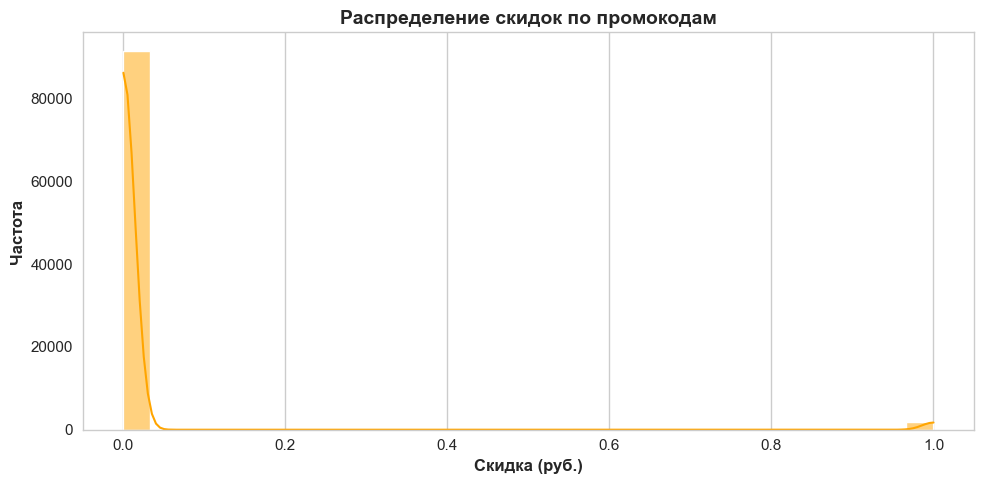

In [184]:
plt.figure(figsize=(10, 5))
sns.histplot(df['promo'], bins=30, kde=True, color='orange')
plt.title('Распределение скидок по промокодам')
plt.xlabel('Скидка (руб.)')
plt.ylabel('Частота')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

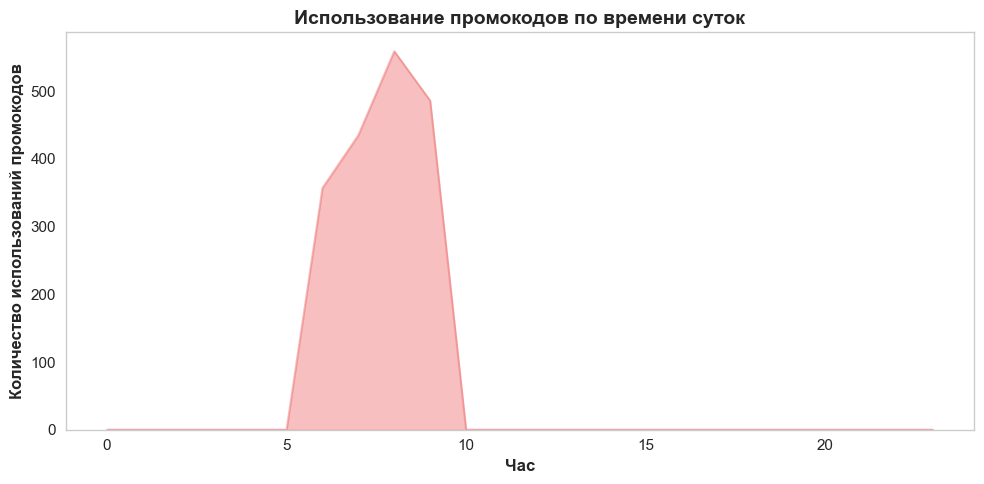

In [185]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['hour'] = df['start_date'].dt.hour
plt.figure(figsize=(10, 5))
df.groupby('hour')['promo'].sum().plot(kind='area', color='lightcoral', alpha=0.5)
plt.title('Использование промокодов по времени суток')
plt.xlabel('Час')
plt.ylabel('Количество использований промокодов')
plt.grid()
plt.tight_layout()
plt.show()

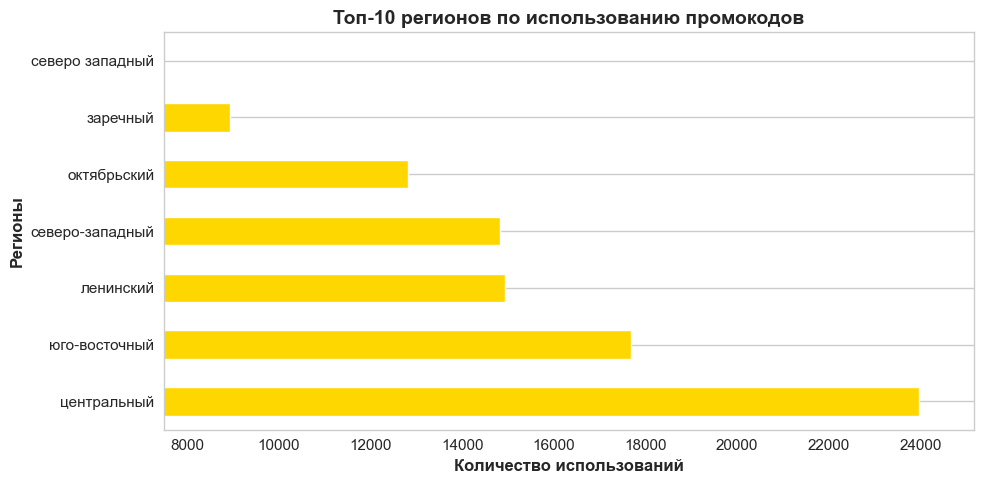

In [186]:
plt.figure(figsize=(10, 5))
df.groupby('start_district')['promo'].count().sort_values(ascending=False).head(10).plot(kind='barh', color='gold')
plt.title('Топ-10 регионов по использованию промокодов')
plt.xlabel('Количество использований')
plt.ylabel('Регионы')
plt.grid(axis='x')
plt.xlim(left=7500)
plt.tight_layout()
plt.show()

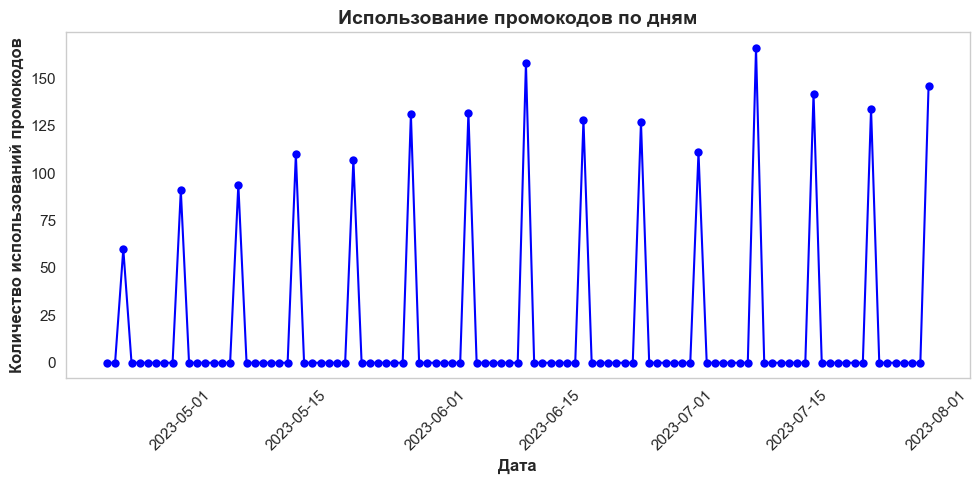

In [187]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['date'] = df['start_date'].dt.date
daily_usage = df.groupby('date')['promo'].sum()
plt.figure(figsize=(10, 5))
daily_usage.plot(kind='line', color='blue', marker='o')
plt.title('Использование промокодов по дням')
plt.xlabel('Дата')
plt.ylabel('Количество использований промокодов')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

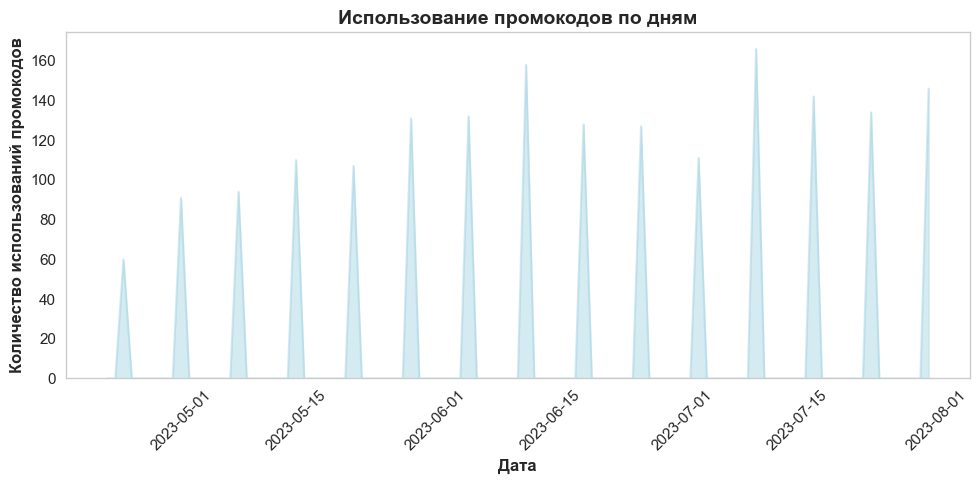

In [188]:
df['date'] = df['start_date'].dt.date
daily_usage = df.groupby('date')['promo'].sum()
plt.figure(figsize=(10, 5))
daily_usage.plot(kind='area', color='lightblue', alpha=0.5)
plt.title('Использование промокодов по дням')
plt.xlabel('Дата')
plt.ylabel('Количество использований промокодов')
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **Общий вывод по проделанной работе на спринт с 14 по 20 апреля**

- Проведен регрессионный анализ (random forest и линейная)
- Создан дашборд
- Сделана презентация

# **<span style="color:#8B0000">Вывод по исследовательской работе</span>**